In [1]:
import define_transformations_afolu as dta
import define_transformations_circular_economy as dtc
import define_transformations_energy as dte
import define_transformations_ippu as dti
import define_transformations_integrated as dtr

import os, os.path
import numpy as np
import pandas as pd
#from model_attributes import *
import model_attributes as ma
import model_afolu as mafl
import model_ippu as mi
import model_circular_economy as mc
import model_electricity as ml
import model_energy as me
import model_socioeconomic as se
import setup_analysis as sa
import sisepuede_data_api as api
import sisepuede_models as sm
import support_classes as sc
import support_functions as sf
import importlib
import time
import warnings
import matplotlib.pyplot as plt
from typing import Union
import inspect
import ingestion as ing
import logging
from sisepuede_file_structure import *
import transformations_base_afolu as tba
import transformations_base_circular_economy as tbc
import transformations_base_energy as tbe
import transformations_base_general as tbg
import transformations_base_ippu as tbi


importlib.reload(ma)
importlib.reload(sa)
importlib.reload(sf)
importlib.reload(mafl)
importlib.reload(mc)
importlib.reload(mi)
importlib.reload(me)
importlib.reload(se)
importlib.reload(tbc)
importlib.reload(tbe)


import sisepuede as ssp


def _setup_logger(namespace: str, fn_out: Union[str, None] = None) -> None:
    global logger
    
    format_str = "%(asctime)s - %(levelname)s - %(message)s"
    # configure
    if fn_out is not None:
        logging.basicConfig(
            filename = fn_out,
            filemode = "w",
            format = format_str,
            level = logging.DEBUG
        )
    else:
        logging.basicConfig(
            format = format_str,
            level = logging.DEBUG
        )
        
    logger = logging.getLogger(namespace)
    # create console handler and set level to debug
    ch = logging.StreamHandler()
    ch.setLevel(logging.DEBUG)
    # create formatter
    formatter = logging.Formatter(format_str)
    # add formatter to ch
    ch.setFormatter(formatter)
    # add ch to logger
    logger.addHandler(ch)

    return logger

_setup_logger(__name__, os.path.join(os.getcwd(), "log_build_sisepuede_transformations.log"))


/Users/jsyme/Documents/Projects/git_jbus/sisepuede/python/model_attributes.py:2635: UserWarning: Invalid subsector attribute 'key_varreqs_partial'. Valid return type values are:'pycategory_primary', 'abv_subsector', 'sector', 'abv_sector', 'key_varreqs_all'
  warnings.warn(f"Invalid subsector attribute '{return_type}'. Valid return type values are:{valid_rts}")
/Users/jsyme/Documents/Projects/git_jbus/sisepuede/python/model_attributes.py:2392: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for desig, df in df_by_designation:
/Users/jsyme/Documents/Projects/git_jbus/sisepuede/python/model_attributes.py:2635: UserWarning: Invalid subsector attribute 'key_varreqs_partial'. Valid return type values are:'pycategory_primary', 'abv_subsector', 'sector', 'abv_sector', 'key_varreqs_all'
  warnings.warn(f"Invalid subsector a

<Logger __main__ (DEBUG)>

# Use the TransformationsIntegrated class to build input templates

- allows to specify any strategies/regions for which to build templates

- writes in-line to Excel templates

- for all strategies, about 5-min per (can and will improve this runtime)

- use `transformations_integrated.build_strategies_to_templates()` to build (docstring included with `?`)


**NOTE**: The `TransformationsIntegrated` class will instantiate a new SISEPUEDE AnalysisID, but the id does not correspond with a directory or any model runs. Ignore it

# NOTE TO JAMES:
- FIX ERROR WHERE transformations_integrated CANNOT INSTANTIATE A TEMPLATE IF IT DOESN'T EXIST
- Should be able to initialize a template with base_input_database_demo or input_template

In [2]:
importlib.reload(sf)
importlib.reload(tba)
importlib.reload(dta)
importlib.reload(dtr)

regions_lac = [
    "argentina",
    "bahamas",
    "barbados",
    "belize",
    "bolivia",
    "brazil",
    "chile",
    "colombia",
    "costa_rica",
    "dominican_republic",
    "ecuador",
    "el_salvador",
    "guatemala",
    "guyana",
    "haiti",
    "honduras",
    "jamaica",
    "mexico",
    "nicaragua",
    "panama",
    "paraguay",
    "peru",
    "suriname",
    "trinidad_and_tobago",
    "uruguay",
    "venezuela"
]



year_0_ramp = 2025
dir_calibs = "/Users/jsyme/Documents/Projects/FY21/SWCHE131_1000/Data/calibrated_input_files_from_edmundo"
fp_inputs = os.path.join(dir_calibs, "input_all_sectors.csv")
df_input = pd.read_csv(fp_inputs)
field_region = "nation"

regions_run = [
    x for x in sorted(regions_lac) if x in list(df_input[field_region].unique())
]
#regions_run = ["turkey", "india"]

# reduce inputs
df_input = df_input[
    df_input[field_region].isin(regions_run)
].reset_index(drop = True)

warnings.filterwarnings("ignore")

if True:
    # set some parameters (WILL SET TO READ FROM A CONFIG OR STRATEGY DEFINITION FILE)
    dict_config_te = {
        "categories_entc_max_investment_ramp": [
            "pp_hydropower",
            "pp_nuclear"
        ],
        "categories_entc_renewable": [
            "pp_geothermal",
            "pp_hydropower",
            "pp_ocean",
            "pp_solar",
            "pp_wind"
        ],
        "categories_inen_high_heat": [
            "cement", 
            "chemicals", 
            "glass", 
            "lime_and_carbonite", 
            "metals"
        ],
        "dict_entc_renewable_target_msp": {
            "pp_solar": 0.15,
            "pp_geothermal": 0.1,
            "pp_wind": 0.15
        },
        "frac_inen_high_temp_elec_hydg": 0.5*0.45,
        "frac_inen_low_temp_elec": 0.95*0.45,
        "n_tp_ramp": None,
        "vir_renewable_cap_delta_frac": 0.01,
        "vir_renewable_cap_max_frac": 0.05,
        "year_0_ramp": year_0_ramp
    }



    transformations_integrated = dtr.TransformationsIntegrated(
        dict_config_te,
        df_input = df_input,
        field_region = field_region,
        logger = logger,
        regions = regions_run,
    )



2023-09-28 11:23:54,964 - INFO - Successfully initialized Analysis ID 'sisepuede_run_2023-09-28T11:23:54.964024'
2023-09-28 11:23:54,965 - INFO - Verification of SISEPUEDE directory structure completed successfully with 0 errors.
2023-09-28 11:23:56,216 - INFO - NemoMod reference file checks completed successfully.
2023-09-28 11:23:56,217 - INFO - Successfully initialized SISEPUEDEFileStructure.
2023-09-28 11:23:56,220 - INFO - Initializing BaseInputDatabase


In [3]:
reg = sc.Regions(sa.model_attributes)
",".join([reg.return_region_or_iso(x, return_type = "iso") for x in regions_run])
          
          
          
          

'ARG,BOL,BRA,CHL,COL,CRI,DOM,ECU,SLV,GTM,HND,JAM,MEX,NIC,PAN,PRY,PER,URY'

In [4]:
df_regions_run = pd.DataFrame({regions.key: regions_run})
df_regions_run.to_csv(
    os.path.join(sa.dir_tmp, "regions_run.csv"),
    index = None,
    encoding = "UTF-8"
)

NameError: name 'regions' is not defined

In [5]:
def get_strategies_from_codes(
    strategy_codes: Union[List[str], str],
) -> Union[List[int], None]:
    """
    Map codes to id as input
    """
    attr_strat = sa.model_attributes.dict_attributes.get("dim_strategy_id")
    dict_map = attr_strat.field_maps.get(f"strategy_code_to_{attr_strat.key}")
    
    # check specification of codes
    strategy_codes = (
        [strategy_codes] 
        if isinstance(strategy_codes, str)
        else (
            strategy_codes
            if sf.islistlike(strategy_codes)
            else None
        )
    )
    
    if strategy_codes is None:
        return None
    
    # get ids to build
    strategies_build = [dict_map.get(x) for x in strategy_codes]
    strategies_build = [x for x in strategies_build if x is not None]
    out = (
        None
        if len(strategies_build) == 0
        else strategies_build
    )
    
    return out



    
strategy_codes_keep = [
    "BASE",
    "LNDU:PLUR",
    "PFLO:BETTER_BASE",
    "PFLO:CHANGE_CONSUMPTION",
    "PFLO:SUPPLY_SIDE_TECH",
    "PFLO:ALL_NO_STOPPING_DEFORESTATION_PLUR",
    "PFLO:ALL_PLUR"
]
strategies_keep = get_strategies_from_codes(strategy_codes_keep)

if True:
    transformations_integrated.build_strategies_to_templates(
        strategies = strategies_keep
    )

   

2023-09-28 01:48:56,389 - INFO - Starting build of 6 strategies in 18 regions...
2023-09-28 01:48:56,405 - INFO - Starting build for region argentina
2023-09-28 01:48:56,420 - INFO - 	Successfully built transformation strategy_id = 1014 ('LNDU: Partial land use reallocation') in 0.01 seconds.
2023-09-28 01:48:59,724 - INFO - 	Successfully built transformation strategy_id = 5001 ('PFLO: Better baseline') in 0.22 seconds.
2023-09-28 01:49:02,834 - INFO - 	Successfully built transformation strategy_id = 5004 ('PFLO: Change consumer behavior') in 0.14 seconds.
2023-09-28 01:49:06,587 - INFO - 	Successfully built transformation strategy_id = 5006 ('PFLO: Supply side technologies and transformations') in 0.76 seconds.
2023-09-28 01:49:10,893 - INFO - 	Successfully built transformation strategy_id = 5007 ('PFLO: All transformations without stopping deforestation and partial land use reallocation') in 1.14 seconds.
2023-09-28 01:49:14,817 - INFO - 	Successfully built transformation strategy_id

['turkey', 'india']

# Option to run SISEPUEDE

In [7]:

import sisepuede as ssp
"""
fn_log = os.path.join(os.getcwd(), "log_sisepuede.log")
os.remove(fn_log) if os.path.exists(fn_log) else None

def _setup_logger(namespace: str, fn_out: Union[str, None] = None) -> None:
    global logger
    
    format_str = "%(asctime)s - %(levelname)s - %(message)s"
    # configure
    if fn_out is not None:
        logging.basicConfig(
            filename = fn_out,
            filemode = "w",
            format = format_str,
            level = logging.DEBUG
        )
    else:
        logging.basicConfig(
            format = format_str,
            level = logging.DEBUG
        )
        
    logger = logging.getLogger(namespace)
    # create console handler and set level to debug
    ch = logging.StreamHandler()
    ch.setLevel(logging.DEBUG)
    # create formatter
    formatter = logging.Formatter(format_str)
    # add formatter to ch
    ch.setFormatter(formatter)
    # add ch to logger
    logger.addHandler(ch)

    return logger

_setup_logger(__name__, fn_log)
""";

sisepuede = ssp.SISEPUEDE(
    "calibrated", 
    logger = logger,
    #n_trials = 1000,
    #id_str = transformations_integrated.file_struct.id, "sisepuede_run_2023-07-11T14:30:38.534039",#id_str = "sisepuede_run_2023-06-13T00:55:37.051768",
    regions = regions_run,#["brazil", "dominican_republic", "chile", "ecuador", "mexico"]
)






# STRATS TO RUN

attr_strat = sisepuede.model_attributes.dict_attributes.get("dim_strategy_id")
dict_code_to_id = attr_strat.field_maps.get(f"strategy_code_to_{attr_strat.key}")
strat_codes_ignore = [
    # AFOLU
    "LNDU:INC_LAND_REHABILITIATION",
    "LSMM:INC_MANAGEMENT_CATTLE_PIGS",
    "LSMM:INC_MANAGEMENT_OTHER",
    "LSMM:INC_MANAGEMENT_POULTRY",
    "LSMM:INC_CAPTURE_BIOGAS",
    "TRWW:INC_COMPLIANCE_SEPTIC",
    "IPPU:DEC_OTHER_FCS",
    "IPPU:DEC_HFCS",
    "IPPU:DEC_PFCS",
    
    # ENERGY
    "TRNS:BUNDLE_DEMAND_MANAGEMENT",
    "TRNS:BUNDLE_DEMAND_MANAGEMENT_REP",
    "TRNS:BUNDLE_EFFICIENCY",
    "TRNS:BUNDLE_EFFICIENCY_REP",
    "TRNS:BUNDLE_FUEL_SWITCH",
    "TRNS:BUNDLE_FUEL_SWITCH_REP",
    "TRNS:BUNDLE_MODE_SHIFT",
    "TRNS:BUNDLE_MODE_SHIFT_REP"
]
strat_ids_drop = [
    dict_code_to_id.get(x) for x in strat_codes_ignore
]
strats_run = [x for x in attr_strat.key_values if x not in strat_ids_drop]




2023-09-28 11:36:59,634 - INFO - Successfully initialized SISEPUEDEFileStructure.
2023-09-28 11:36:59,637 - WARNING - Missing key dict_dimensional_keys: key time_series not found. Tables that rely on the time_series will not have index checking.
2023-09-28 11:36:59,638 - INFO - 	Setting export engine to 'sqlite'.
2023-09-28 11:36:59,640 - WARNING - No index fields defined. Index field values will not be checked when writing to tables.
2023-09-28 11:36:59,641 - INFO - Successfully instantiated table ANALYSIS_METADATA
2023-09-28 11:36:59,643 - WARNING - No index fields found in ATTRIBUTE_DESIGN. Initializing index fields.
2023-09-28 11:36:59,643 - INFO - Successfully instantiated table ATTRIBUTE_DESIGN
2023-09-28 11:36:59,645 - WARNING - No index fields found in ATTRIBUTE_LHC_SAMPLES_EXOGENOUS_UNCERTAINTIES. Initializing index fields.
2023-09-28 11:36:59,646 - INFO - Successfully instantiated table ATTRIBUTE_LHC_SAMPLES_EXOGENOUS_UNCERTAINTIES
2023-09-28 11:36:59,648 - WARNING - No index

In [29]:
"""
##  SOME IterativeDatabaseTable THINGS

query = f"select * from {tab_output.table_name} limit 0;"
with tab_output.engine.connect() as con:
    df_columns = pd.read_sql_query(query, con)
    
    
for k in tab_output.columns:
    w = np.where(np.array(tab_output.columns) == k)[0]
    if len(w) > 1:
        print(k)

tab_output = sisepuede.database.db.dict_iterative_database_tables.get("MODEL_OUTPUT")
tab_output._initialize_table() # sispuede randomly started failing at some points
""";

In [81]:
# drop table
#idt_output = sisepuede.database.db.dict_iterative_database_tables.get("MODEL_OUTPUT")
#idt_output._drop_indices([("turkey", 127127)])

# write to output
#
#
df_in = sisepuede.experimental_manager.dict_future_trajectories.get(region).generate_future_from_lhs_vector(None, None, None, baseline_future_q = False)#True)
df_in.to_csv(
    os.path.join(sisepuede.file_struct.dir_tmp, "temporary_full_inputs.csv"),
    index = None,
    encoding = "UTF-8"
)

In [9]:
warnings.filterwarnings("ignore")

In [8]:

dict_filt = {
    "future_id": [0],
    "design_id": [0], 
    "strategy_id": [0, 1014, 5001, 5004, 5006, 5007, 5009]
}


dict_primary_keys_out = sisepuede(
    dict_filt,
    chunk_size = 2,
    reinitialize_output_table_on_verification_failure = True,
    #regions = ["mexico"],
    thresholds = (10**(-5), 10**4.5),
)


2023-09-28 12:25:17,065 - INFO - 
***	STARTING REGION argentina	***

2023-09-28 12:25:18,808 - INFO - Trying run primary_id = 0 in region argentina
2023-09-28 12:25:18,810 - INFO - Running AFOLU model
2023-09-28 12:25:19,176 - INFO - AFOLU model run successfully completed
2023-09-28 12:25:19,177 - INFO - Running CircularEconomy model
2023-09-28 12:25:19,280 - INFO - CircularEconomy model run successfully completed
2023-09-28 12:25:19,280 - INFO - Running IPPU model
2023-09-28 12:25:19,449 - INFO - IPPU model run successfully completed
2023-09-28 12:25:19,450 - INFO - Running Energy model (NonElectricEnergy without Fugitive Emissions)
2023-09-28 12:25:19,491 - DEBUG - Missing elasticity information found in 'project_energy_consumption_by_fuel_from_effvars': using specified future demands.
2023-09-28 12:25:19,704 - INFO - NonElectricEnergy without Fugitive Emissions model run successfully completed
2023-09-28 12:25:19,704 - INFO - Running Energy model (Electricity and Fuel Production: tr

2023-28-Sep 12:25:19.785 Opened SQLite database at /Users/jsyme/Documents/Projects/git_jbus/sisepuede/tmp/nemomod_intermediate_database.sqlite.
2023-28-Sep 12:25:19.840 Added NEMO structure to SQLite database at /Users/jsyme/Documents/Projects/git_jbus/sisepuede/tmp/nemomod_intermediate_database.sqlite.
Set parameter TimeLimit to value 900
2023-28-Sep 12:25:22.060 Started modeling scenario.
2023-28-Sep 12:26:31.202 Finished modeling scenario.


┌ Warning: Model period emission limits (ModelPeriodEmissionLimit parameter) are not enforced when modeling selected years.
└ @ NemoMod ~/.julia/packages/NemoMod/d2ky8/src/scenario_calculation.jl:6181
2023-09-28 12:26:31,654 - INFO - NemoMod ran successfully with the following status: <PyCall.jlwrap OPTIMAL>
2023-09-28 12:26:31,680 - INFO - ElectricEnergy model run successfully completed
2023-09-28 12:26:31,681 - INFO - Running Energy (Fugitive Emissions)
2023-09-28 12:26:31,779 - INFO - Fugitive Emissions from Energy model run successfully completed
2023-09-28 12:26:31,780 - INFO - Appending Socioeconomic outputs
2023-09-28 12:26:31,796 - INFO - Socioeconomic outputs successfully appended.
2023-09-28 12:26:31,803 - INFO - Model run for primary_id = 0 successfully completed in 72.99 seconds (n_tries = 1).
2023-09-28 12:26:31,817 - INFO - Trying run primary_id = 14014 in region argentina
2023-09-28 12:26:31,817 - INFO - Running AFOLU model
2023-09-28 12:26:32,170 - INFO - AFOLU model ru

Set parameter TimeLimit to value 900
2023-28-Sep 12:26:35.094 Started modeling scenario.

┌ Warning: Model period emission limits (ModelPeriodEmissionLimit parameter) are not enforced when modeling selected years.
└ @ NemoMod ~/.julia/packages/NemoMod/d2ky8/src/scenario_calculation.jl:6181



2023-28-Sep 12:28:21.214 Finished modeling scenario.


2023-09-28 12:28:21,721 - INFO - NemoMod ran successfully with the following status: <PyCall.jlwrap OPTIMAL>
2023-09-28 12:28:21,771 - INFO - ElectricEnergy model run successfully completed
2023-09-28 12:28:21,771 - INFO - Running Energy (Fugitive Emissions)
2023-09-28 12:28:21,883 - INFO - Fugitive Emissions from Energy model run successfully completed
2023-09-28 12:28:21,884 - INFO - Appending Socioeconomic outputs
2023-09-28 12:28:21,901 - INFO - Socioeconomic outputs successfully appended.
2023-09-28 12:28:21,908 - INFO - Model run for primary_id = 14014 successfully completed in 110.09 seconds (n_tries = 1).
2023-09-28 12:28:23,013 - INFO - Table MODEL_OUTPUT successfully written to database.
2023-09-28 12:28:23,079 - INFO - Trying run primary_id = 119119 in region argentina
2023-09-28 12:28:23,080 - INFO - Running AFOLU model
2023-09-28 12:28:23,454 - INFO - AFOLU model run successfully completed
2023-09-28 12:28:23,455 - INFO - Running CircularEconomy model
2023-09-28 12:28:23,5

Set parameter TimeLimit to value 900


┌ Warning: Model period emission limits (ModelPeriodEmissionLimit parameter) are not enforced when modeling selected years.
└ @ NemoMod ~/.julia/packages/NemoMod/d2ky8/src/scenario_calculation.jl:6181


2023-28-Sep 12:28:27.255 Started modeling scenario.
2023-28-Sep 12:29:33.708 Finished modeling scenario.


2023-09-28 12:29:34,058 - INFO - NemoMod ran successfully with the following status: <PyCall.jlwrap OPTIMAL>
2023-09-28 12:29:34,079 - INFO - ElectricEnergy model run successfully completed
2023-09-28 12:29:34,079 - INFO - Running Energy (Fugitive Emissions)
2023-09-28 12:29:34,160 - INFO - Fugitive Emissions from Energy model run successfully completed
2023-09-28 12:29:34,160 - INFO - Appending Socioeconomic outputs
2023-09-28 12:29:34,173 - INFO - Socioeconomic outputs successfully appended.
2023-09-28 12:29:34,177 - INFO - Model run for primary_id = 119119 successfully completed in 71.1 seconds (n_tries = 1).
2023-09-28 12:29:34,183 - INFO - Trying run primary_id = 122122 in region argentina
2023-09-28 12:29:34,183 - INFO - Running AFOLU model
2023-09-28 12:29:34,516 - INFO - AFOLU model run successfully completed
2023-09-28 12:29:34,517 - INFO - Running CircularEconomy model
2023-09-28 12:29:34,599 - INFO - CircularEconomy model run successfully completed
2023-09-28 12:29:34,599 - 

Set parameter TimeLimit to value 900
2023-28-Sep 12:29:36.866 Started modeling scenario.
2023-28-Sep 12:30:41.272 Finished modeling scenario.


┌ Warning: Model period emission limits (ModelPeriodEmissionLimit parameter) are not enforced when modeling selected years.
└ @ NemoMod ~/.julia/packages/NemoMod/d2ky8/src/scenario_calculation.jl:6181
2023-09-28 12:30:41,677 - INFO - NemoMod ran successfully with the following status: <PyCall.jlwrap OPTIMAL>
2023-09-28 12:30:41,700 - INFO - ElectricEnergy model run successfully completed
2023-09-28 12:30:41,701 - INFO - Running Energy (Fugitive Emissions)
2023-09-28 12:30:41,811 - INFO - Fugitive Emissions from Energy model run successfully completed
2023-09-28 12:30:41,812 - INFO - Appending Socioeconomic outputs
2023-09-28 12:30:41,831 - INFO - Socioeconomic outputs successfully appended.
2023-09-28 12:30:41,838 - INFO - Model run for primary_id = 122122 successfully completed in 67.66 seconds (n_tries = 1).
2023-09-28 12:30:42,467 - INFO - Table MODEL_OUTPUT successfully appended to database.
2023-09-28 12:30:42,471 - INFO - Trying run primary_id = 124124 in region argentina
2023-09

Set parameter TimeLimit to value 900
2023-28-Sep 12:30:45.491 Started modeling scenario.
2023-28-Sep 12:32:24.037 Finished modeling scenario.


┌ Warning: Model period emission limits (ModelPeriodEmissionLimit parameter) are not enforced when modeling selected years.
└ @ NemoMod ~/.julia/packages/NemoMod/d2ky8/src/scenario_calculation.jl:6181
2023-09-28 12:32:24,413 - INFO - NemoMod ran successfully with the following status: <PyCall.jlwrap OPTIMAL>
2023-09-28 12:32:24,437 - INFO - ElectricEnergy model run successfully completed
2023-09-28 12:32:24,437 - INFO - Running Energy (Fugitive Emissions)
2023-09-28 12:32:24,527 - INFO - Fugitive Emissions from Energy model run successfully completed
2023-09-28 12:32:24,527 - INFO - Appending Socioeconomic outputs
2023-09-28 12:32:24,545 - INFO - Socioeconomic outputs successfully appended.
2023-09-28 12:32:24,553 - INFO - Model run for primary_id = 124124 successfully completed in 102.08 seconds (n_tries = 1).
2023-09-28 12:32:24,557 - INFO - Trying run primary_id = 125125 in region argentina
2023-09-28 12:32:24,558 - INFO - Running AFOLU model
2023-09-28 12:32:24,921 - INFO - AFOLU m

Set parameter TimeLimit to value 900
2023-28-Sep 12:32:27.599 Started modeling scenario.
2023-28-Sep 12:33:35.798 Finished modeling scenario.


┌ Warning: Model period emission limits (ModelPeriodEmissionLimit parameter) are not enforced when modeling selected years.
└ @ NemoMod ~/.julia/packages/NemoMod/d2ky8/src/scenario_calculation.jl:6181
2023-09-28 12:33:36,181 - INFO - NemoMod ran successfully with the following status: <PyCall.jlwrap OPTIMAL>
2023-09-28 12:33:36,208 - INFO - ElectricEnergy model run successfully completed
2023-09-28 12:33:36,209 - INFO - Running Energy (Fugitive Emissions)
2023-09-28 12:33:36,302 - INFO - Fugitive Emissions from Energy model run successfully completed
2023-09-28 12:33:36,303 - INFO - Appending Socioeconomic outputs
2023-09-28 12:33:36,318 - INFO - Socioeconomic outputs successfully appended.
2023-09-28 12:33:36,324 - INFO - Model run for primary_id = 125125 successfully completed in 71.77 seconds (n_tries = 1).
2023-09-28 12:33:36,986 - INFO - Table MODEL_OUTPUT successfully appended to database.
2023-09-28 12:33:36,991 - INFO - Trying run primary_id = 127127 in region argentina
2023-09

Set parameter TimeLimit to value 900
2023-28-Sep 12:33:39.853 Started modeling scenario.

┌ Warning: Model period emission limits (ModelPeriodEmissionLimit parameter) are not enforced when modeling selected years.
└ @ NemoMod ~/.julia/packages/NemoMod/d2ky8/src/scenario_calculation.jl:6181



2023-28-Sep 12:34:48.616 Finished modeling scenario.


2023-09-28 12:34:49,099 - INFO - NemoMod ran successfully with the following status: <PyCall.jlwrap OPTIMAL>
2023-09-28 12:34:49,127 - INFO - ElectricEnergy model run successfully completed
2023-09-28 12:34:49,127 - INFO - Running Energy (Fugitive Emissions)
2023-09-28 12:34:49,216 - INFO - Fugitive Emissions from Energy model run successfully completed
2023-09-28 12:34:49,216 - INFO - Appending Socioeconomic outputs
2023-09-28 12:34:49,231 - INFO - Socioeconomic outputs successfully appended.
2023-09-28 12:34:49,237 - INFO - Model run for primary_id = 127127 successfully completed in 72.24 seconds (n_tries = 1).
2023-09-28 12:34:49,238 - INFO - 
***	 REGION argentina COMPLETE	***

2023-09-28 12:34:49,240 - INFO - 
***	STARTING REGION bolivia	***

2023-09-28 12:34:51,321 - INFO - Trying run primary_id = 0 in region bolivia
2023-09-28 12:34:51,321 - INFO - Running AFOLU model
2023-09-28 12:34:51,679 - INFO - AFOLU model run successfully completed
2023-09-28 12:34:51,680 - INFO - Running

Set parameter TimeLimit to value 900
2023-28-Sep 12:34:54.704 Started modeling scenario.
2023-28-Sep 12:36:18.518 Finished modeling scenario.


┌ Warning: Model period emission limits (ModelPeriodEmissionLimit parameter) are not enforced when modeling selected years.
└ @ NemoMod ~/.julia/packages/NemoMod/d2ky8/src/scenario_calculation.jl:6181
2023-09-28 12:36:18,869 - INFO - NemoMod ran successfully with the following status: <PyCall.jlwrap OPTIMAL>
2023-09-28 12:36:18,891 - INFO - ElectricEnergy model run successfully completed
2023-09-28 12:36:18,892 - INFO - Running Energy (Fugitive Emissions)
2023-09-28 12:36:18,971 - INFO - Fugitive Emissions from Energy model run successfully completed
2023-09-28 12:36:18,972 - INFO - Appending Socioeconomic outputs
2023-09-28 12:36:18,985 - INFO - Socioeconomic outputs successfully appended.
2023-09-28 12:36:18,990 - INFO - Model run for primary_id = 0 successfully completed in 87.67 seconds (n_tries = 1).
2023-09-28 12:36:19,569 - INFO - Table MODEL_OUTPUT successfully appended to database.
2023-09-28 12:36:19,580 - INFO - Trying run primary_id = 14014 in region bolivia
2023-09-28 12:3

Set parameter TimeLimit to value 900
2023-28-Sep 12:36:22.297 Started modeling scenario.
2023-28-Sep 12:38:07.413 Finished modeling scenario.


┌ Warning: Model period emission limits (ModelPeriodEmissionLimit parameter) are not enforced when modeling selected years.
└ @ NemoMod ~/.julia/packages/NemoMod/d2ky8/src/scenario_calculation.jl:6181
2023-09-28 12:38:07,738 - INFO - NemoMod ran successfully with the following status: <PyCall.jlwrap OPTIMAL>
2023-09-28 12:38:07,762 - INFO - ElectricEnergy model run successfully completed
2023-09-28 12:38:07,763 - INFO - Running Energy (Fugitive Emissions)
2023-09-28 12:38:07,844 - INFO - Fugitive Emissions from Energy model run successfully completed
2023-09-28 12:38:07,844 - INFO - Appending Socioeconomic outputs
2023-09-28 12:38:07,858 - INFO - Socioeconomic outputs successfully appended.
2023-09-28 12:38:07,864 - INFO - Model run for primary_id = 14014 successfully completed in 108.28 seconds (n_tries = 1).
2023-09-28 12:38:07,918 - INFO - Trying run primary_id = 119119 in region bolivia
2023-09-28 12:38:07,918 - INFO - Running AFOLU model
2023-09-28 12:38:08,226 - INFO - AFOLU mode

Set parameter TimeLimit to value 900
2023-28-Sep 12:38:10.616 Started modeling scenario.
2023-28-Sep 12:39:30.249 Finished modeling scenario.


┌ Warning: Model period emission limits (ModelPeriodEmissionLimit parameter) are not enforced when modeling selected years.
└ @ NemoMod ~/.julia/packages/NemoMod/d2ky8/src/scenario_calculation.jl:6181
2023-09-28 12:39:30,649 - INFO - NemoMod ran successfully with the following status: <PyCall.jlwrap OPTIMAL>
2023-09-28 12:39:30,679 - INFO - ElectricEnergy model run successfully completed
2023-09-28 12:39:30,680 - INFO - Running Energy (Fugitive Emissions)
2023-09-28 12:39:30,765 - INFO - Fugitive Emissions from Energy model run successfully completed
2023-09-28 12:39:30,765 - INFO - Appending Socioeconomic outputs
2023-09-28 12:39:30,781 - INFO - Socioeconomic outputs successfully appended.
2023-09-28 12:39:30,790 - INFO - Model run for primary_id = 119119 successfully completed in 82.87 seconds (n_tries = 1).
2023-09-28 12:39:31,428 - INFO - Table MODEL_OUTPUT successfully appended to database.
2023-09-28 12:39:31,434 - INFO - Trying run primary_id = 122122 in region bolivia
2023-09-2

Set parameter TimeLimit to value 900
2023-28-Sep 12:39:34.482 Started modeling scenario.

┌ Warning: Model period emission limits (ModelPeriodEmissionLimit parameter) are not enforced when modeling selected years.
└ @ NemoMod ~/.julia/packages/NemoMod/d2ky8/src/scenario_calculation.jl:6181



2023-28-Sep 12:41:03.071 Finished modeling scenario.


2023-09-28 12:41:03,492 - INFO - NemoMod ran successfully with the following status: <PyCall.jlwrap OPTIMAL>
2023-09-28 12:41:03,526 - INFO - ElectricEnergy model run successfully completed
2023-09-28 12:41:03,527 - INFO - Running Energy (Fugitive Emissions)
2023-09-28 12:41:03,635 - INFO - Fugitive Emissions from Energy model run successfully completed
2023-09-28 12:41:03,636 - INFO - Appending Socioeconomic outputs
2023-09-28 12:41:03,655 - INFO - Socioeconomic outputs successfully appended.
2023-09-28 12:41:03,664 - INFO - Model run for primary_id = 122122 successfully completed in 92.23 seconds (n_tries = 1).
2023-09-28 12:41:03,669 - INFO - Trying run primary_id = 124124 in region bolivia
2023-09-28 12:41:03,670 - INFO - Running AFOLU model
2023-09-28 12:41:04,034 - INFO - AFOLU model run successfully completed
2023-09-28 12:41:04,035 - INFO - Running CircularEconomy model
2023-09-28 12:41:04,147 - INFO - CircularEconomy model run successfully completed
2023-09-28 12:41:04,148 - I

Set parameter TimeLimit to value 900
2023-28-Sep 12:41:06.707 Started modeling scenario.
2023-28-Sep 12:48:04.685 Finished modeling scenario.


┌ Warning: Model period emission limits (ModelPeriodEmissionLimit parameter) are not enforced when modeling selected years.
└ @ NemoMod ~/.julia/packages/NemoMod/d2ky8/src/scenario_calculation.jl:6181
2023-09-28 12:48:05,077 - INFO - NemoMod ran successfully with the following status: <PyCall.jlwrap OPTIMAL>
2023-09-28 12:48:05,113 - INFO - ElectricEnergy model run successfully completed
2023-09-28 12:48:05,113 - INFO - Running Energy (Fugitive Emissions)
2023-09-28 12:48:05,199 - INFO - Fugitive Emissions from Energy model run successfully completed
2023-09-28 12:48:05,200 - INFO - Appending Socioeconomic outputs
2023-09-28 12:48:05,214 - INFO - Socioeconomic outputs successfully appended.
2023-09-28 12:48:05,219 - INFO - Running AFOLU model
2023-09-28 12:48:05,539 - INFO - AFOLU model run successfully completed
2023-09-28 12:48:05,540 - INFO - Running CircularEconomy model
2023-09-28 12:48:05,636 - INFO - CircularEconomy model run successfully completed
2023-09-28 12:48:05,636 - INFO

Set parameter TimeLimit to value 900
2023-28-Sep 12:48:08.107 Started modeling scenario.
2023-28-Sep 12:54:48.173 Finished modeling scenario.


2023-09-28 12:54:48,518 - INFO - NemoMod ran successfully with the following status: <PyCall.jlwrap OPTIMAL>
2023-09-28 12:54:48,541 - INFO - ElectricEnergy model run successfully completed
2023-09-28 12:54:48,542 - INFO - Running Energy (Fugitive Emissions)
2023-09-28 12:54:48,624 - INFO - Fugitive Emissions from Energy model run successfully completed
2023-09-28 12:54:48,625 - INFO - Appending Socioeconomic outputs
2023-09-28 12:54:48,640 - INFO - Socioeconomic outputs successfully appended.
2023-09-28 12:54:48,646 - ERROR - Model run for primary_id = 124124 failed with the following error: Maximum number of attempts 2 reached without successful run. Skipping...
2023-09-28 12:54:48,651 - INFO - Trying run primary_id = 125125 in region bolivia
2023-09-28 12:54:48,651 - INFO - Running AFOLU model
2023-09-28 12:54:48,972 - INFO - AFOLU model run successfully completed
2023-09-28 12:54:48,973 - INFO - Running CircularEconomy model
2023-09-28 12:54:49,061 - INFO - CircularEconomy model ru

Set parameter TimeLimit to value 900
2023-28-Sep 12:54:51.494 Started modeling scenario.

┌ Warning: Model period emission limits (ModelPeriodEmissionLimit parameter) are not enforced when modeling selected years.
└ @ NemoMod ~/.julia/packages/NemoMod/d2ky8/src/scenario_calculation.jl:6181



2023-28-Sep 13:04:55.195 Finished modeling scenario.


2023-09-28 13:04:55,540 - INFO - NemoMod ran successfully with the following status: <PyCall.jlwrap OPTIMAL>
2023-09-28 13:04:55,565 - INFO - ElectricEnergy model run successfully completed
2023-09-28 13:04:55,566 - INFO - Running Energy (Fugitive Emissions)
2023-09-28 13:04:55,654 - INFO - Fugitive Emissions from Energy model run successfully completed
2023-09-28 13:04:55,655 - INFO - Appending Socioeconomic outputs
2023-09-28 13:04:55,668 - INFO - Socioeconomic outputs successfully appended.
2023-09-28 13:04:55,675 - INFO - Model run for primary_id = 125125 successfully completed in 607.02 seconds (n_tries = 1).
2023-09-28 13:04:56,271 - INFO - Table MODEL_OUTPUT successfully appended to database.
2023-09-28 13:04:56,276 - INFO - Trying run primary_id = 127127 in region bolivia
2023-09-28 13:04:56,277 - INFO - Running AFOLU model
2023-09-28 13:04:56,593 - INFO - AFOLU model run successfully completed
2023-09-28 13:04:56,594 - INFO - Running CircularEconomy model
2023-09-28 13:04:56,6

Set parameter TimeLimit to value 900
2023-28-Sep 13:04:59.262 Started modeling scenario.
2023-28-Sep 13:20:17.556 Solver did not find an optimal solution for model. No results will be saved to database.
2023-28-Sep 13:20:17.560 Finished modeling scenario.


2023-09-28 13:20:19,614 - INFO - Trying run primary_id = 0 in region brazil
2023-09-28 13:20:19,614 - INFO - Running AFOLU model
2023-09-28 13:20:19,997 - INFO - AFOLU model run successfully completed
2023-09-28 13:20:19,998 - INFO - Running CircularEconomy model
2023-09-28 13:20:20,097 - INFO - CircularEconomy model run successfully completed
2023-09-28 13:20:20,097 - INFO - Running IPPU model
2023-09-28 13:20:20,254 - INFO - IPPU model run successfully completed
2023-09-28 13:20:20,254 - INFO - Running Energy model (NonElectricEnergy without Fugitive Emissions)
2023-09-28 13:20:20,293 - DEBUG - Missing elasticity information found in 'project_energy_consumption_by_fuel_from_effvars': using specified future demands.
2023-09-28 13:20:20,496 - INFO - NonElectricEnergy without Fugitive Emissions model run successfully completed
2023-09-28 13:20:20,496 - INFO - Running Energy model (Electricity and Fuel Production: trying to call Julia)


Set parameter TimeLimit to value 900


┌ Warning: Model period emission limits (ModelPeriodEmissionLimit parameter) are not enforced when modeling selected years.
└ @ NemoMod ~/.julia/packages/NemoMod/d2ky8/src/scenario_calculation.jl:6181


2023-28-Sep 13:20:22.531 Started modeling scenario.
2023-28-Sep 13:21:30.361 Finished modeling scenario.


2023-09-28 13:21:30,721 - INFO - NemoMod ran successfully with the following status: <PyCall.jlwrap OPTIMAL>
2023-09-28 13:21:30,741 - INFO - ElectricEnergy model run successfully completed
2023-09-28 13:21:30,741 - INFO - Running Energy (Fugitive Emissions)
2023-09-28 13:21:30,826 - INFO - Fugitive Emissions from Energy model run successfully completed
2023-09-28 13:21:30,827 - INFO - Appending Socioeconomic outputs
2023-09-28 13:21:30,842 - INFO - Socioeconomic outputs successfully appended.
2023-09-28 13:21:30,847 - INFO - Model run for primary_id = 0 successfully completed in 71.23 seconds (n_tries = 1).
2023-09-28 13:21:45,465 - INFO - Table MODEL_OUTPUT successfully appended to database.
2023-09-28 13:21:45,479 - INFO - Trying run primary_id = 14014 in region brazil
2023-09-28 13:21:45,481 - INFO - Running AFOLU model
2023-09-28 13:21:45,811 - INFO - AFOLU model run successfully completed
2023-09-28 13:21:45,812 - INFO - Running CircularEconomy model
2023-09-28 13:21:45,910 - INF

Set parameter TimeLimit to value 900
2023-28-Sep 13:21:48.277 Started modeling scenario.

┌ Warning: Model period emission limits (ModelPeriodEmissionLimit parameter) are not enforced when modeling selected years.
└ @ NemoMod ~/.julia/packages/NemoMod/d2ky8/src/scenario_calculation.jl:6181



2023-28-Sep 13:23:00.559 Finished modeling scenario.


2023-09-28 13:23:00,925 - INFO - NemoMod ran successfully with the following status: <PyCall.jlwrap OPTIMAL>
2023-09-28 13:23:00,949 - INFO - ElectricEnergy model run successfully completed
2023-09-28 13:23:00,950 - INFO - Running Energy (Fugitive Emissions)
2023-09-28 13:23:01,036 - INFO - Fugitive Emissions from Energy model run successfully completed
2023-09-28 13:23:01,036 - INFO - Appending Socioeconomic outputs
2023-09-28 13:23:01,051 - INFO - Socioeconomic outputs successfully appended.
2023-09-28 13:23:01,058 - INFO - Model run for primary_id = 14014 successfully completed in 75.58 seconds (n_tries = 1).
2023-09-28 13:23:01,122 - INFO - Trying run primary_id = 119119 in region brazil
2023-09-28 13:23:01,123 - INFO - Running AFOLU model
2023-09-28 13:23:01,455 - INFO - AFOLU model run successfully completed
2023-09-28 13:23:01,456 - INFO - Running CircularEconomy model
2023-09-28 13:23:01,553 - INFO - CircularEconomy model run successfully completed
2023-09-28 13:23:01,554 - INF

Set parameter TimeLimit to value 900
2023-28-Sep 13:23:03.942 Started modeling scenario.
2023-28-Sep 13:24:11.035 Finished modeling scenario.


┌ Warning: Model period emission limits (ModelPeriodEmissionLimit parameter) are not enforced when modeling selected years.
└ @ NemoMod ~/.julia/packages/NemoMod/d2ky8/src/scenario_calculation.jl:6181
2023-09-28 13:24:11,371 - INFO - NemoMod ran successfully with the following status: <PyCall.jlwrap OPTIMAL>
2023-09-28 13:24:11,393 - INFO - ElectricEnergy model run successfully completed
2023-09-28 13:24:11,394 - INFO - Running Energy (Fugitive Emissions)
2023-09-28 13:24:11,476 - INFO - Fugitive Emissions from Energy model run successfully completed
2023-09-28 13:24:11,477 - INFO - Appending Socioeconomic outputs
2023-09-28 13:24:11,492 - INFO - Socioeconomic outputs successfully appended.
2023-09-28 13:24:11,497 - INFO - Model run for primary_id = 119119 successfully completed in 70.37 seconds (n_tries = 1).
2023-09-28 13:24:12,140 - INFO - Table MODEL_OUTPUT successfully appended to database.
2023-09-28 13:24:12,145 - INFO - Trying run primary_id = 122122 in region brazil
2023-09-28

Set parameter TimeLimit to value 900
2023-28-Sep 13:24:14.883 Started modeling scenario.
2023-28-Sep 13:25:22.758 Finished modeling scenario.


2023-09-28 13:25:23,129 - INFO - NemoMod ran successfully with the following status: <PyCall.jlwrap OPTIMAL>
2023-09-28 13:25:23,151 - INFO - ElectricEnergy model run successfully completed
2023-09-28 13:25:23,152 - INFO - Running Energy (Fugitive Emissions)
2023-09-28 13:25:23,233 - INFO - Fugitive Emissions from Energy model run successfully completed
2023-09-28 13:25:23,233 - INFO - Appending Socioeconomic outputs
2023-09-28 13:25:23,248 - INFO - Socioeconomic outputs successfully appended.
2023-09-28 13:25:23,253 - INFO - Model run for primary_id = 122122 successfully completed in 71.11 seconds (n_tries = 1).
2023-09-28 13:25:23,258 - INFO - Trying run primary_id = 124124 in region brazil
2023-09-28 13:25:23,258 - INFO - Running AFOLU model
2023-09-28 13:25:23,607 - INFO - AFOLU model run successfully completed
2023-09-28 13:25:23,608 - INFO - Running CircularEconomy model
2023-09-28 13:25:23,692 - INFO - CircularEconomy model run successfully completed
2023-09-28 13:25:23,692 - IN

Set parameter TimeLimit to value 900
2023-28-Sep 13:25:26.107 Started modeling scenario.
2023-28-Sep 13:26:29.681 Finished modeling scenario.


┌ Warning: Model period emission limits (ModelPeriodEmissionLimit parameter) are not enforced when modeling selected years.
└ @ NemoMod ~/.julia/packages/NemoMod/d2ky8/src/scenario_calculation.jl:6181
2023-09-28 13:26:29,998 - INFO - NemoMod ran successfully with the following status: <PyCall.jlwrap OPTIMAL>
2023-09-28 13:26:30,016 - INFO - ElectricEnergy model run successfully completed
2023-09-28 13:26:30,017 - INFO - Running Energy (Fugitive Emissions)
2023-09-28 13:26:30,088 - INFO - Fugitive Emissions from Energy model run successfully completed
2023-09-28 13:26:30,089 - INFO - Appending Socioeconomic outputs
2023-09-28 13:26:30,102 - INFO - Socioeconomic outputs successfully appended.
2023-09-28 13:26:30,107 - INFO - Model run for primary_id = 124124 successfully completed in 66.85 seconds (n_tries = 1).
2023-09-28 13:26:30,678 - INFO - Table MODEL_OUTPUT successfully appended to database.
2023-09-28 13:26:30,681 - INFO - Trying run primary_id = 125125 in region brazil
2023-09-28

Set parameter TimeLimit to value 900


┌ Warning: Model period emission limits (ModelPeriodEmissionLimit parameter) are not enforced when modeling selected years.
└ @ NemoMod ~/.julia/packages/NemoMod/d2ky8/src/scenario_calculation.jl:6181


2023-28-Sep 13:26:33.394 Started modeling scenario.
2023-28-Sep 13:27:37.936 Finished modeling scenario.


2023-09-28 13:27:38,267 - INFO - NemoMod ran successfully with the following status: <PyCall.jlwrap OPTIMAL>
2023-09-28 13:27:38,288 - INFO - ElectricEnergy model run successfully completed
2023-09-28 13:27:38,289 - INFO - Running Energy (Fugitive Emissions)
2023-09-28 13:27:38,362 - INFO - Fugitive Emissions from Energy model run successfully completed
2023-09-28 13:27:38,363 - INFO - Appending Socioeconomic outputs
2023-09-28 13:27:38,375 - INFO - Socioeconomic outputs successfully appended.
2023-09-28 13:27:38,380 - INFO - Model run for primary_id = 125125 successfully completed in 67.7 seconds (n_tries = 1).
2023-09-28 13:27:38,384 - INFO - Trying run primary_id = 127127 in region brazil
2023-09-28 13:27:38,385 - INFO - Running AFOLU model
2023-09-28 13:27:38,687 - INFO - AFOLU model run successfully completed
2023-09-28 13:27:38,687 - INFO - Running CircularEconomy model
2023-09-28 13:27:38,773 - INFO - CircularEconomy model run successfully completed
2023-09-28 13:27:38,774 - INF

Set parameter TimeLimit to value 900
2023-28-Sep 13:27:40.978 Started modeling scenario.
2023-28-Sep 13:28:45.123 Finished modeling scenario.


┌ Warning: Model period emission limits (ModelPeriodEmissionLimit parameter) are not enforced when modeling selected years.
└ @ NemoMod ~/.julia/packages/NemoMod/d2ky8/src/scenario_calculation.jl:6181
2023-09-28 13:28:45,441 - INFO - NemoMod ran successfully with the following status: <PyCall.jlwrap OPTIMAL>
2023-09-28 13:28:45,462 - INFO - ElectricEnergy model run successfully completed
2023-09-28 13:28:45,463 - INFO - Running Energy (Fugitive Emissions)
2023-09-28 13:28:45,535 - INFO - Fugitive Emissions from Energy model run successfully completed
2023-09-28 13:28:45,536 - INFO - Appending Socioeconomic outputs
2023-09-28 13:28:45,549 - INFO - Socioeconomic outputs successfully appended.
2023-09-28 13:28:45,553 - INFO - Model run for primary_id = 127127 successfully completed in 67.17 seconds (n_tries = 1).
2023-09-28 13:28:46,140 - INFO - Table MODEL_OUTPUT successfully appended to database.
2023-09-28 13:28:46,141 - INFO - 
***	 REGION brazil COMPLETE	***

2023-09-28 13:28:46,141 

Set parameter TimeLimit to value 900
2023-28-Sep 13:28:50.232 Started modeling scenario.
2023-28-Sep 13:29:53.427 Finished modeling scenario.


2023-09-28 13:29:53,757 - INFO - NemoMod ran successfully with the following status: <PyCall.jlwrap OPTIMAL>
2023-09-28 13:29:53,775 - INFO - ElectricEnergy model run successfully completed
2023-09-28 13:29:53,776 - INFO - Running Energy (Fugitive Emissions)
2023-09-28 13:29:53,849 - INFO - Fugitive Emissions from Energy model run successfully completed
2023-09-28 13:29:53,850 - INFO - Appending Socioeconomic outputs
2023-09-28 13:29:53,862 - INFO - Socioeconomic outputs successfully appended.
2023-09-28 13:29:53,868 - INFO - Model run for primary_id = 0 successfully completed in 66.35 seconds (n_tries = 1).
2023-09-28 13:29:53,877 - INFO - Trying run primary_id = 14014 in region chile
2023-09-28 13:29:53,878 - INFO - Running AFOLU model
2023-09-28 13:29:54,190 - INFO - AFOLU model run successfully completed
2023-09-28 13:29:54,191 - INFO - Running CircularEconomy model
2023-09-28 13:29:54,273 - INFO - CircularEconomy model run successfully completed
2023-09-28 13:29:54,274 - INFO - Ru

Set parameter TimeLimit to value 900
2023-28-Sep 13:29:56.544 Started modeling scenario.
2023-28-Sep 13:32:06.815 Finished modeling scenario.


┌ Warning: Model period emission limits (ModelPeriodEmissionLimit parameter) are not enforced when modeling selected years.
└ @ NemoMod ~/.julia/packages/NemoMod/d2ky8/src/scenario_calculation.jl:6181
2023-09-28 13:32:07,159 - INFO - NemoMod ran successfully with the following status: <PyCall.jlwrap OPTIMAL>
2023-09-28 13:32:07,182 - INFO - ElectricEnergy model run successfully completed
2023-09-28 13:32:07,182 - INFO - Running Energy (Fugitive Emissions)
2023-09-28 13:32:07,255 - INFO - Fugitive Emissions from Energy model run successfully completed
2023-09-28 13:32:07,256 - INFO - Appending Socioeconomic outputs
2023-09-28 13:32:07,269 - INFO - Socioeconomic outputs successfully appended.
2023-09-28 13:32:07,274 - INFO - Model run for primary_id = 14014 successfully completed in 133.4 seconds (n_tries = 1).
2023-09-28 13:32:07,838 - INFO - Table MODEL_OUTPUT successfully appended to database.
2023-09-28 13:32:07,892 - INFO - Trying run primary_id = 119119 in region chile
2023-09-28 1

Set parameter TimeLimit to value 900
2023-28-Sep 13:32:10.487 Started modeling scenario.
2023-28-Sep 13:33:11.988 Finished modeling scenario.


┌ Warning: Model period emission limits (ModelPeriodEmissionLimit parameter) are not enforced when modeling selected years.
└ @ NemoMod ~/.julia/packages/NemoMod/d2ky8/src/scenario_calculation.jl:6181
2023-09-28 13:33:12,304 - INFO - NemoMod ran successfully with the following status: <PyCall.jlwrap OPTIMAL>
2023-09-28 13:33:12,323 - INFO - ElectricEnergy model run successfully completed
2023-09-28 13:33:12,324 - INFO - Running Energy (Fugitive Emissions)
2023-09-28 13:33:12,401 - INFO - Fugitive Emissions from Energy model run successfully completed
2023-09-28 13:33:12,402 - INFO - Appending Socioeconomic outputs
2023-09-28 13:33:12,417 - INFO - Socioeconomic outputs successfully appended.
2023-09-28 13:33:12,423 - INFO - Model run for primary_id = 119119 successfully completed in 64.53 seconds (n_tries = 1).
2023-09-28 13:33:12,428 - INFO - Trying run primary_id = 122122 in region chile
2023-09-28 13:33:12,429 - INFO - Running AFOLU model
2023-09-28 13:33:12,770 - INFO - AFOLU model 

Set parameter TimeLimit to value 900
2023-28-Sep 13:33:15.252 Started modeling scenario.
2023-28-Sep 13:35:16.234 Finished modeling scenario.


2023-09-28 13:35:16,554 - INFO - NemoMod ran successfully with the following status: <PyCall.jlwrap OPTIMAL>
2023-09-28 13:35:16,573 - INFO - ElectricEnergy model run successfully completed
2023-09-28 13:35:16,573 - INFO - Running Energy (Fugitive Emissions)
2023-09-28 13:35:16,648 - INFO - Fugitive Emissions from Energy model run successfully completed
2023-09-28 13:35:16,649 - INFO - Appending Socioeconomic outputs
2023-09-28 13:35:16,661 - INFO - Socioeconomic outputs successfully appended.
2023-09-28 13:35:16,666 - INFO - Model run for primary_id = 122122 successfully completed in 124.24 seconds (n_tries = 1).
2023-09-28 13:35:17,226 - INFO - Table MODEL_OUTPUT successfully appended to database.
2023-09-28 13:35:17,231 - INFO - Trying run primary_id = 124124 in region chile
2023-09-28 13:35:17,232 - INFO - Running AFOLU model
2023-09-28 13:35:17,538 - INFO - AFOLU model run successfully completed
2023-09-28 13:35:17,539 - INFO - Running CircularEconomy model
2023-09-28 13:35:17,622

Set parameter TimeLimit to value 900
2023-28-Sep 13:35:19.832 Started modeling scenario.
2023-28-Sep 13:37:47.827 Finished modeling scenario.


┌ Warning: Model period emission limits (ModelPeriodEmissionLimit parameter) are not enforced when modeling selected years.
└ @ NemoMod ~/.julia/packages/NemoMod/d2ky8/src/scenario_calculation.jl:6181
2023-09-28 13:37:48,169 - INFO - NemoMod ran successfully with the following status: <PyCall.jlwrap OPTIMAL>
2023-09-28 13:37:48,188 - INFO - ElectricEnergy model run successfully completed
2023-09-28 13:37:48,188 - INFO - Running Energy (Fugitive Emissions)
2023-09-28 13:37:48,261 - INFO - Fugitive Emissions from Energy model run successfully completed
2023-09-28 13:37:48,261 - INFO - Appending Socioeconomic outputs
2023-09-28 13:37:48,274 - INFO - Socioeconomic outputs successfully appended.
2023-09-28 13:37:48,278 - INFO - Model run for primary_id = 124124 successfully completed in 151.05 seconds (n_tries = 1).
2023-09-28 13:37:48,281 - INFO - Trying run primary_id = 125125 in region chile
2023-09-28 13:37:48,282 - INFO - Running AFOLU model
2023-09-28 13:37:48,588 - INFO - AFOLU model

Set parameter TimeLimit to value 900
2023-28-Sep 13:37:50.872 Started modeling scenario.
2023-28-Sep 13:38:57.072 Finished modeling scenario.


┌ Warning: Model period emission limits (ModelPeriodEmissionLimit parameter) are not enforced when modeling selected years.
└ @ NemoMod ~/.julia/packages/NemoMod/d2ky8/src/scenario_calculation.jl:6181
2023-09-28 13:38:57,432 - INFO - NemoMod ran successfully with the following status: <PyCall.jlwrap OPTIMAL>
2023-09-28 13:38:57,454 - INFO - ElectricEnergy model run successfully completed
2023-09-28 13:38:57,455 - INFO - Running Energy (Fugitive Emissions)
2023-09-28 13:38:57,537 - INFO - Fugitive Emissions from Energy model run successfully completed
2023-09-28 13:38:57,538 - INFO - Appending Socioeconomic outputs
2023-09-28 13:38:57,552 - INFO - Socioeconomic outputs successfully appended.
2023-09-28 13:38:57,557 - INFO - Model run for primary_id = 125125 successfully completed in 69.28 seconds (n_tries = 1).
2023-09-28 13:38:58,143 - INFO - Table MODEL_OUTPUT successfully appended to database.
2023-09-28 13:38:58,148 - INFO - Trying run primary_id = 127127 in region chile
2023-09-28 

Set parameter TimeLimit to value 900


┌ Warning: Model period emission limits (ModelPeriodEmissionLimit parameter) are not enforced when modeling selected years.
└ @ NemoMod ~/.julia/packages/NemoMod/d2ky8/src/scenario_calculation.jl:6181
2023-09-28 13:54:18,027 - ERROR - Error running ElectricEnergy model: 'NoneType' object is not subscriptable
2023-09-28 13:54:18,128 - INFO - Running Energy (Fugitive Emissions)


2023-28-Sep 13:39:00.829 Started modeling scenario.
2023-28-Sep 13:54:17.880 Solver did not find an optimal solution for model. No results will be saved to database.
2023-28-Sep 13:54:17.930 Finished modeling scenario.


2023-09-28 13:54:18,201 - WARNING - Warning in project_enfu_production_and_demands: Variable 'Energy Demand by Fuel in Energy Technology' not found in the data frame. Its fuel demands will not be included.
2023-09-28 13:54:18,268 - INFO - Fugitive Emissions from Energy model run successfully completed
2023-09-28 13:54:18,269 - INFO - Appending Socioeconomic outputs
2023-09-28 13:54:18,290 - INFO - Socioeconomic outputs successfully appended.
2023-09-28 13:54:18,301 - INFO - Model run for primary_id = 127127 successfully completed in 920.15 seconds (n_tries = 1).
2023-09-28 13:54:18,302 - INFO - 
***	 REGION chile COMPLETE	***

2023-09-28 13:54:18,303 - INFO - 
***	STARTING REGION colombia	***

2023-09-28 13:54:20,347 - INFO - Trying run primary_id = 0 in region colombia
2023-09-28 13:54:20,348 - INFO - Running AFOLU model
2023-09-28 13:54:20,717 - INFO - AFOLU model run successfully completed
2023-09-28 13:54:20,718 - INFO - Running CircularEconomy model
2023-09-28 13:54:20,824 - INFO 

Set parameter TimeLimit to value 900
2023-28-Sep 13:54:23.654 Started modeling scenario.
2023-28-Sep 13:55:35.227 Finished modeling scenario.


┌ Warning: Model period emission limits (ModelPeriodEmissionLimit parameter) are not enforced when modeling selected years.
└ @ NemoMod ~/.julia/packages/NemoMod/d2ky8/src/scenario_calculation.jl:6181
2023-09-28 13:55:35,621 - INFO - NemoMod ran successfully with the following status: <PyCall.jlwrap OPTIMAL>
2023-09-28 13:55:35,644 - INFO - ElectricEnergy model run successfully completed
2023-09-28 13:55:35,644 - INFO - Running Energy (Fugitive Emissions)
2023-09-28 13:55:35,728 - INFO - Fugitive Emissions from Energy model run successfully completed
2023-09-28 13:55:35,729 - INFO - Appending Socioeconomic outputs
2023-09-28 13:55:35,742 - INFO - Socioeconomic outputs successfully appended.
2023-09-28 13:55:35,747 - INFO - Model run for primary_id = 0 successfully completed in 75.4 seconds (n_tries = 1).
2023-09-28 13:55:36,485 - INFO - Table MODEL_OUTPUT successfully appended to database.
2023-09-28 13:55:36,528 - INFO - Trying run primary_id = 14014 in region colombia
2023-09-28 13:5

Set parameter TimeLimit to value 900
2023-28-Sep 13:55:39.527 Started modeling scenario.
2023-28-Sep 13:56:43.554 Finished modeling scenario.


┌ Warning: Model period emission limits (ModelPeriodEmissionLimit parameter) are not enforced when modeling selected years.
└ @ NemoMod ~/.julia/packages/NemoMod/d2ky8/src/scenario_calculation.jl:6181
2023-09-28 13:56:43,917 - INFO - NemoMod ran successfully with the following status: <PyCall.jlwrap OPTIMAL>
2023-09-28 13:56:43,941 - INFO - ElectricEnergy model run successfully completed
2023-09-28 13:56:43,942 - INFO - Running Energy (Fugitive Emissions)
2023-09-28 13:56:44,018 - INFO - Fugitive Emissions from Energy model run successfully completed
2023-09-28 13:56:44,018 - INFO - Appending Socioeconomic outputs
2023-09-28 13:56:44,036 - INFO - Socioeconomic outputs successfully appended.
2023-09-28 13:56:44,042 - INFO - Model run for primary_id = 14014 successfully completed in 67.51 seconds (n_tries = 1).
2023-09-28 13:56:44,144 - INFO - Trying run primary_id = 119119 in region colombia
2023-09-28 13:56:44,145 - INFO - Running AFOLU model
2023-09-28 13:56:44,481 - INFO - AFOLU mode

Set parameter TimeLimit to value 900


┌ Warning: Model period emission limits (ModelPeriodEmissionLimit parameter) are not enforced when modeling selected years.
└ @ NemoMod ~/.julia/packages/NemoMod/d2ky8/src/scenario_calculation.jl:6181


2023-28-Sep 13:56:46.945 Started modeling scenario.
2023-28-Sep 13:57:48.884 Finished modeling scenario.


2023-09-28 13:57:49,228 - INFO - NemoMod ran successfully with the following status: <PyCall.jlwrap OPTIMAL>
2023-09-28 13:57:49,246 - INFO - ElectricEnergy model run successfully completed
2023-09-28 13:57:49,246 - INFO - Running Energy (Fugitive Emissions)
2023-09-28 13:57:49,322 - INFO - Fugitive Emissions from Energy model run successfully completed
2023-09-28 13:57:49,323 - INFO - Appending Socioeconomic outputs
2023-09-28 13:57:49,336 - INFO - Socioeconomic outputs successfully appended.
2023-09-28 13:57:49,341 - INFO - Model run for primary_id = 119119 successfully completed in 65.2 seconds (n_tries = 1).
2023-09-28 13:57:49,940 - INFO - Table MODEL_OUTPUT successfully appended to database.
2023-09-28 13:57:49,945 - INFO - Trying run primary_id = 122122 in region colombia
2023-09-28 13:57:49,947 - INFO - Running AFOLU model
2023-09-28 13:57:50,274 - INFO - AFOLU model run successfully completed
2023-09-28 13:57:50,274 - INFO - Running CircularEconomy model
2023-09-28 13:57:50,36

Set parameter TimeLimit to value 900
2023-28-Sep 13:57:52.791 Started modeling scenario.
2023-28-Sep 13:59:04.866 Finished modeling scenario.


┌ Warning: Model period emission limits (ModelPeriodEmissionLimit parameter) are not enforced when modeling selected years.
└ @ NemoMod ~/.julia/packages/NemoMod/d2ky8/src/scenario_calculation.jl:6181
2023-09-28 13:59:05,206 - INFO - NemoMod ran successfully with the following status: <PyCall.jlwrap OPTIMAL>
2023-09-28 13:59:05,225 - INFO - ElectricEnergy model run successfully completed
2023-09-28 13:59:05,226 - INFO - Running Energy (Fugitive Emissions)
2023-09-28 13:59:05,303 - INFO - Fugitive Emissions from Energy model run successfully completed
2023-09-28 13:59:05,303 - INFO - Appending Socioeconomic outputs
2023-09-28 13:59:05,317 - INFO - Socioeconomic outputs successfully appended.
2023-09-28 13:59:05,323 - INFO - Model run for primary_id = 122122 successfully completed in 75.38 seconds (n_tries = 1).
2023-09-28 13:59:05,327 - INFO - Trying run primary_id = 124124 in region colombia
2023-09-28 13:59:05,328 - INFO - Running AFOLU model
2023-09-28 13:59:05,663 - INFO - AFOLU mod

Set parameter TimeLimit to value 900
2023-28-Sep 13:59:08.128 Started modeling scenario.
2023-28-Sep 14:00:27.339 Finished modeling scenario.


2023-09-28 14:00:27,702 - INFO - NemoMod ran successfully with the following status: <PyCall.jlwrap OPTIMAL>
2023-09-28 14:00:27,721 - INFO - ElectricEnergy model run successfully completed
2023-09-28 14:00:27,721 - INFO - Running Energy (Fugitive Emissions)
2023-09-28 14:00:27,794 - INFO - Fugitive Emissions from Energy model run successfully completed
2023-09-28 14:00:27,795 - INFO - Appending Socioeconomic outputs
2023-09-28 14:00:27,807 - INFO - Socioeconomic outputs successfully appended.
2023-09-28 14:00:27,814 - INFO - Model run for primary_id = 124124 successfully completed in 82.49 seconds (n_tries = 1).
2023-09-28 14:00:40,622 - INFO - Table MODEL_OUTPUT successfully appended to database.
2023-09-28 14:00:40,627 - INFO - Trying run primary_id = 125125 in region colombia
2023-09-28 14:00:40,627 - INFO - Running AFOLU model
2023-09-28 14:00:40,945 - INFO - AFOLU model run successfully completed
2023-09-28 14:00:40,946 - INFO - Running CircularEconomy model
2023-09-28 14:00:41,0

Set parameter TimeLimit to value 900
2023-28-Sep 14:00:43.384 Started modeling scenario.
2023-28-Sep 14:01:55.294 Finished modeling scenario.


┌ Warning: Model period emission limits (ModelPeriodEmissionLimit parameter) are not enforced when modeling selected years.
└ @ NemoMod ~/.julia/packages/NemoMod/d2ky8/src/scenario_calculation.jl:6181
2023-09-28 14:01:55,666 - INFO - NemoMod ran successfully with the following status: <PyCall.jlwrap OPTIMAL>
2023-09-28 14:01:55,691 - INFO - ElectricEnergy model run successfully completed
2023-09-28 14:01:55,691 - INFO - Running Energy (Fugitive Emissions)
2023-09-28 14:01:55,776 - INFO - Fugitive Emissions from Energy model run successfully completed
2023-09-28 14:01:55,776 - INFO - Appending Socioeconomic outputs
2023-09-28 14:01:55,790 - INFO - Socioeconomic outputs successfully appended.
2023-09-28 14:01:55,796 - INFO - Model run for primary_id = 125125 successfully completed in 75.17 seconds (n_tries = 1).
2023-09-28 14:01:55,802 - INFO - Trying run primary_id = 127127 in region colombia
2023-09-28 14:01:55,803 - INFO - Running AFOLU model
2023-09-28 14:01:56,149 - INFO - AFOLU mod

Set parameter TimeLimit to value 900
2023-28-Sep 14:01:58.629 Started modeling scenario.
2023-28-Sep 14:03:40.538 Finished modeling scenario.


┌ Warning: Model period emission limits (ModelPeriodEmissionLimit parameter) are not enforced when modeling selected years.
└ @ NemoMod ~/.julia/packages/NemoMod/d2ky8/src/scenario_calculation.jl:6181
2023-09-28 14:03:40,893 - INFO - NemoMod ran successfully with the following status: <PyCall.jlwrap OPTIMAL>
2023-09-28 14:03:40,924 - INFO - ElectricEnergy model run successfully completed
2023-09-28 14:03:40,925 - INFO - Running Energy (Fugitive Emissions)
2023-09-28 14:03:40,999 - INFO - Fugitive Emissions from Energy model run successfully completed
2023-09-28 14:03:41,000 - INFO - Appending Socioeconomic outputs
2023-09-28 14:03:41,012 - INFO - Socioeconomic outputs successfully appended.
2023-09-28 14:03:41,017 - INFO - Model run for primary_id = 127127 successfully completed in 105.21 seconds (n_tries = 1).
2023-09-28 14:03:41,632 - INFO - Table MODEL_OUTPUT successfully appended to database.
2023-09-28 14:03:41,633 - INFO - 
***	 REGION colombia COMPLETE	***

2023-09-28 14:03:41,6

Set parameter TimeLimit to value 900
2023-28-Sep 14:03:46.538 Started modeling scenario.
2023-28-Sep 14:04:56.303 Finished modeling scenario.


┌ Warning: Model period emission limits (ModelPeriodEmissionLimit parameter) are not enforced when modeling selected years.
└ @ NemoMod ~/.julia/packages/NemoMod/d2ky8/src/scenario_calculation.jl:6181
2023-09-28 14:04:56,746 - INFO - NemoMod ran successfully with the following status: <PyCall.jlwrap OPTIMAL>
2023-09-28 14:04:56,786 - INFO - ElectricEnergy model run successfully completed
2023-09-28 14:04:56,787 - INFO - Running Energy (Fugitive Emissions)
2023-09-28 14:04:56,886 - INFO - Fugitive Emissions from Energy model run successfully completed
2023-09-28 14:04:56,887 - INFO - Appending Socioeconomic outputs
2023-09-28 14:04:56,902 - INFO - Socioeconomic outputs successfully appended.
2023-09-28 14:04:56,909 - INFO - Model run for primary_id = 0 successfully completed in 73.41 seconds (n_tries = 1).
2023-09-28 14:04:56,926 - INFO - Trying run primary_id = 14014 in region costa_rica
2023-09-28 14:04:56,927 - INFO - Running AFOLU model
2023-09-28 14:04:57,289 - INFO - AFOLU model r

Set parameter TimeLimit to value 900


┌ Warning: Model period emission limits (ModelPeriodEmissionLimit parameter) are not enforced when modeling selected years.
└ @ NemoMod ~/.julia/packages/NemoMod/d2ky8/src/scenario_calculation.jl:6181


2023-28-Sep 14:05:00.887 Started modeling scenario.
2023-28-Sep 14:06:09.725 Finished modeling scenario.


2023-09-28 14:06:10,153 - INFO - NemoMod ran successfully with the following status: <PyCall.jlwrap OPTIMAL>
2023-09-28 14:06:10,193 - INFO - ElectricEnergy model run successfully completed
2023-09-28 14:06:10,193 - INFO - Running Energy (Fugitive Emissions)
2023-09-28 14:06:10,295 - INFO - Fugitive Emissions from Energy model run successfully completed
2023-09-28 14:06:10,296 - INFO - Appending Socioeconomic outputs
2023-09-28 14:06:10,313 - INFO - Socioeconomic outputs successfully appended.
2023-09-28 14:06:10,320 - INFO - Model run for primary_id = 14014 successfully completed in 73.39 seconds (n_tries = 1).
2023-09-28 14:06:11,040 - INFO - Table MODEL_OUTPUT successfully appended to database.
2023-09-28 14:06:11,105 - INFO - Trying run primary_id = 119119 in region costa_rica
2023-09-28 14:06:11,106 - INFO - Running AFOLU model
2023-09-28 14:06:11,472 - INFO - AFOLU model run successfully completed
2023-09-28 14:06:11,472 - INFO - Running CircularEconomy model
2023-09-28 14:06:11,

Set parameter TimeLimit to value 900


┌ Warning: Model period emission limits (ModelPeriodEmissionLimit parameter) are not enforced when modeling selected years.
└ @ NemoMod ~/.julia/packages/NemoMod/d2ky8/src/scenario_calculation.jl:6181


2023-28-Sep 14:06:14.944 Started modeling scenario.
2023-28-Sep 14:07:06.612 Finished modeling scenario.


2023-09-28 14:07:06,952 - INFO - NemoMod ran successfully with the following status: <PyCall.jlwrap OPTIMAL>
2023-09-28 14:07:06,976 - INFO - ElectricEnergy model run successfully completed
2023-09-28 14:07:06,976 - INFO - Running Energy (Fugitive Emissions)
2023-09-28 14:07:07,053 - INFO - Fugitive Emissions from Energy model run successfully completed
2023-09-28 14:07:07,054 - INFO - Appending Socioeconomic outputs
2023-09-28 14:07:07,068 - INFO - Socioeconomic outputs successfully appended.
2023-09-28 14:07:07,074 - INFO - Model run for primary_id = 119119 successfully completed in 55.97 seconds (n_tries = 1).
2023-09-28 14:07:07,078 - INFO - Trying run primary_id = 122122 in region costa_rica
2023-09-28 14:07:07,078 - INFO - Running AFOLU model
2023-09-28 14:07:07,428 - INFO - AFOLU model run successfully completed
2023-09-28 14:07:07,429 - INFO - Running CircularEconomy model
2023-09-28 14:07:07,519 - INFO - CircularEconomy model run successfully completed
2023-09-28 14:07:07,520 

Set parameter TimeLimit to value 900
2023-28-Sep 14:07:09.886 Started modeling scenario.
2023-28-Sep 14:08:09.886 Finished modeling scenario.


2023-09-28 14:08:10,245 - INFO - NemoMod ran successfully with the following status: <PyCall.jlwrap OPTIMAL>
2023-09-28 14:08:10,265 - INFO - ElectricEnergy model run successfully completed
2023-09-28 14:08:10,266 - INFO - Running Energy (Fugitive Emissions)
2023-09-28 14:08:10,353 - INFO - Fugitive Emissions from Energy model run successfully completed
2023-09-28 14:08:10,354 - INFO - Appending Socioeconomic outputs
2023-09-28 14:08:10,369 - INFO - Socioeconomic outputs successfully appended.
2023-09-28 14:08:10,375 - INFO - Model run for primary_id = 122122 successfully completed in 63.3 seconds (n_tries = 1).
2023-09-28 14:08:11,016 - INFO - Table MODEL_OUTPUT successfully appended to database.
2023-09-28 14:08:11,022 - INFO - Trying run primary_id = 124124 in region costa_rica
2023-09-28 14:08:11,023 - INFO - Running AFOLU model
2023-09-28 14:08:11,390 - INFO - AFOLU model run successfully completed
2023-09-28 14:08:11,392 - INFO - Running CircularEconomy model
2023-09-28 14:08:11,

Set parameter TimeLimit to value 900
2023-28-Sep 14:08:14.075 Started modeling scenario.
2023-28-Sep 14:09:10.434 Finished modeling scenario.


2023-09-28 14:09:10,851 - INFO - NemoMod ran successfully with the following status: <PyCall.jlwrap OPTIMAL>
2023-09-28 14:09:10,879 - INFO - ElectricEnergy model run successfully completed
2023-09-28 14:09:10,879 - INFO - Running Energy (Fugitive Emissions)
2023-09-28 14:09:10,971 - INFO - Fugitive Emissions from Energy model run successfully completed
2023-09-28 14:09:10,972 - INFO - Appending Socioeconomic outputs
2023-09-28 14:09:10,987 - INFO - Socioeconomic outputs successfully appended.
2023-09-28 14:09:10,993 - INFO - Model run for primary_id = 124124 successfully completed in 59.97 seconds (n_tries = 1).
2023-09-28 14:09:10,998 - INFO - Trying run primary_id = 125125 in region costa_rica
2023-09-28 14:09:11,000 - INFO - Running AFOLU model
2023-09-28 14:09:11,380 - INFO - AFOLU model run successfully completed
2023-09-28 14:09:11,382 - INFO - Running CircularEconomy model
2023-09-28 14:09:11,491 - INFO - CircularEconomy model run successfully completed
2023-09-28 14:09:11,492 

Set parameter TimeLimit to value 900
2023-28-Sep 14:09:14.112 Started modeling scenario.

┌ Warning: Model period emission limits (ModelPeriodEmissionLimit parameter) are not enforced when modeling selected years.
└ @ NemoMod ~/.julia/packages/NemoMod/d2ky8/src/scenario_calculation.jl:6181



2023-28-Sep 14:10:09.265 Finished modeling scenario.


2023-09-28 14:10:09,778 - INFO - NemoMod ran successfully with the following status: <PyCall.jlwrap OPTIMAL>
2023-09-28 14:10:09,822 - INFO - ElectricEnergy model run successfully completed
2023-09-28 14:10:09,823 - INFO - Running Energy (Fugitive Emissions)
2023-09-28 14:10:09,946 - INFO - Fugitive Emissions from Energy model run successfully completed
2023-09-28 14:10:09,947 - INFO - Appending Socioeconomic outputs
2023-09-28 14:10:09,968 - INFO - Socioeconomic outputs successfully appended.
2023-09-28 14:10:09,976 - INFO - Model run for primary_id = 125125 successfully completed in 58.98 seconds (n_tries = 1).
2023-09-28 14:10:10,884 - INFO - Table MODEL_OUTPUT successfully appended to database.
2023-09-28 14:10:10,890 - INFO - Trying run primary_id = 127127 in region costa_rica
2023-09-28 14:10:10,891 - INFO - Running AFOLU model
2023-09-28 14:10:11,385 - INFO - AFOLU model run successfully completed
2023-09-28 14:10:11,386 - INFO - Running CircularEconomy model
2023-09-28 14:10:11

Set parameter TimeLimit to value 900
2023-28-Sep 14:10:15.110 Started modeling scenario.
2023-28-Sep 14:11:23.842 Finished modeling scenario.


┌ Warning: Model period emission limits (ModelPeriodEmissionLimit parameter) are not enforced when modeling selected years.
└ @ NemoMod ~/.julia/packages/NemoMod/d2ky8/src/scenario_calculation.jl:6181
2023-09-28 14:11:24,462 - INFO - NemoMod ran successfully with the following status: <PyCall.jlwrap OPTIMAL>
2023-09-28 14:11:24,497 - INFO - ElectricEnergy model run successfully completed
2023-09-28 14:11:24,498 - INFO - Running Energy (Fugitive Emissions)
2023-09-28 14:11:24,632 - INFO - Fugitive Emissions from Energy model run successfully completed
2023-09-28 14:11:24,633 - INFO - Appending Socioeconomic outputs
2023-09-28 14:11:24,655 - INFO - Socioeconomic outputs successfully appended.
2023-09-28 14:11:24,664 - INFO - Model run for primary_id = 127127 successfully completed in 73.77 seconds (n_tries = 1).
2023-09-28 14:11:24,666 - INFO - 
***	 REGION costa_rica COMPLETE	***

2023-09-28 14:11:24,669 - INFO - 
***	STARTING REGION dominican_republic	***

2023-09-28 14:11:27,599 - INF

Set parameter TimeLimit to value 900


┌ Warning: Model period emission limits (ModelPeriodEmissionLimit parameter) are not enforced when modeling selected years.
└ @ NemoMod ~/.julia/packages/NemoMod/d2ky8/src/scenario_calculation.jl:6181


2023-28-Sep 14:11:32.912 Started modeling scenario.
2023-28-Sep 14:12:47.125 Finished modeling scenario.


2023-09-28 14:12:47,645 - INFO - NemoMod ran successfully with the following status: <PyCall.jlwrap OPTIMAL>
2023-09-28 14:12:47,675 - INFO - ElectricEnergy model run successfully completed
2023-09-28 14:12:47,676 - INFO - Running Energy (Fugitive Emissions)
2023-09-28 14:12:47,790 - INFO - Fugitive Emissions from Energy model run successfully completed
2023-09-28 14:12:47,790 - INFO - Appending Socioeconomic outputs
2023-09-28 14:12:47,811 - INFO - Socioeconomic outputs successfully appended.
2023-09-28 14:12:47,820 - INFO - Model run for primary_id = 0 successfully completed in 80.22 seconds (n_tries = 1).
2023-09-28 14:12:48,698 - INFO - Table MODEL_OUTPUT successfully appended to database.
2023-09-28 14:12:48,713 - INFO - Trying run primary_id = 14014 in region dominican_republic
2023-09-28 14:12:48,714 - INFO - Running AFOLU model
2023-09-28 14:12:49,198 - INFO - AFOLU model run successfully completed
2023-09-28 14:12:49,198 - INFO - Running CircularEconomy model
2023-09-28 14:12:

Set parameter TimeLimit to value 900
2023-28-Sep 14:12:52.770 Started modeling scenario.
2023-28-Sep 14:14:06.387 Finished modeling scenario.


┌ Warning: Model period emission limits (ModelPeriodEmissionLimit parameter) are not enforced when modeling selected years.
└ @ NemoMod ~/.julia/packages/NemoMod/d2ky8/src/scenario_calculation.jl:6181
2023-09-28 14:14:06,888 - INFO - NemoMod ran successfully with the following status: <PyCall.jlwrap OPTIMAL>
2023-09-28 14:14:06,918 - INFO - ElectricEnergy model run successfully completed
2023-09-28 14:14:06,919 - INFO - Running Energy (Fugitive Emissions)
2023-09-28 14:14:07,031 - INFO - Fugitive Emissions from Energy model run successfully completed
2023-09-28 14:14:07,032 - INFO - Appending Socioeconomic outputs
2023-09-28 14:14:07,051 - INFO - Socioeconomic outputs successfully appended.
2023-09-28 14:14:07,058 - INFO - Model run for primary_id = 14014 successfully completed in 78.34 seconds (n_tries = 1).
2023-09-28 14:14:07,133 - INFO - Trying run primary_id = 119119 in region dominican_republic
2023-09-28 14:14:07,134 - INFO - Running AFOLU model
2023-09-28 14:14:07,622 - INFO - 

Set parameter TimeLimit to value 900
2023-28-Sep 14:14:11.094 Started modeling scenario.
2023-28-Sep 14:15:18.504 Finished modeling scenario.


2023-09-28 14:15:18,993 - INFO - NemoMod ran successfully with the following status: <PyCall.jlwrap OPTIMAL>
2023-09-28 14:15:19,022 - INFO - ElectricEnergy model run successfully completed
2023-09-28 14:15:19,024 - INFO - Running Energy (Fugitive Emissions)
2023-09-28 14:15:19,136 - INFO - Fugitive Emissions from Energy model run successfully completed
2023-09-28 14:15:19,136 - INFO - Appending Socioeconomic outputs
2023-09-28 14:15:19,156 - INFO - Socioeconomic outputs successfully appended.
2023-09-28 14:15:19,163 - INFO - Model run for primary_id = 119119 successfully completed in 72.03 seconds (n_tries = 1).
2023-09-28 14:15:20,013 - INFO - Table MODEL_OUTPUT successfully appended to database.
2023-09-28 14:15:20,019 - INFO - Trying run primary_id = 122122 in region dominican_republic
2023-09-28 14:15:20,021 - INFO - Running AFOLU model
2023-09-28 14:15:20,491 - INFO - AFOLU model run successfully completed
2023-09-28 14:15:20,492 - INFO - Running CircularEconomy model
2023-09-28 

Set parameter TimeLimit to value 900
2023-28-Sep 14:15:23.983 Started modeling scenario.
2023-28-Sep 14:16:49.169 Finished modeling scenario.


┌ Warning: Model period emission limits (ModelPeriodEmissionLimit parameter) are not enforced when modeling selected years.
└ @ NemoMod ~/.julia/packages/NemoMod/d2ky8/src/scenario_calculation.jl:6181
2023-09-28 14:16:49,665 - INFO - NemoMod ran successfully with the following status: <PyCall.jlwrap OPTIMAL>
2023-09-28 14:16:49,693 - INFO - ElectricEnergy model run successfully completed
2023-09-28 14:16:49,693 - INFO - Running Energy (Fugitive Emissions)
2023-09-28 14:16:49,805 - INFO - Fugitive Emissions from Energy model run successfully completed
2023-09-28 14:16:49,807 - INFO - Appending Socioeconomic outputs
2023-09-28 14:16:49,826 - INFO - Socioeconomic outputs successfully appended.
2023-09-28 14:16:49,831 - INFO - Running AFOLU model
2023-09-28 14:16:50,306 - INFO - AFOLU model run successfully completed
2023-09-28 14:16:50,307 - INFO - Running CircularEconomy model
2023-09-28 14:16:50,433 - INFO - CircularEconomy model run successfully completed
2023-09-28 14:16:50,434 - INFO

Set parameter TimeLimit to value 900
2023-28-Sep 14:16:53.702 Started modeling scenario.
2023-28-Sep 14:18:18.393 Finished modeling scenario.


┌ Warning: Model period emission limits (ModelPeriodEmissionLimit parameter) are not enforced when modeling selected years.
└ @ NemoMod ~/.julia/packages/NemoMod/d2ky8/src/scenario_calculation.jl:6181
2023-09-28 14:18:18,895 - INFO - NemoMod ran successfully with the following status: <PyCall.jlwrap OPTIMAL>
2023-09-28 14:18:18,924 - INFO - ElectricEnergy model run successfully completed
2023-09-28 14:18:18,925 - INFO - Running Energy (Fugitive Emissions)
2023-09-28 14:18:19,042 - INFO - Fugitive Emissions from Energy model run successfully completed
2023-09-28 14:18:19,043 - INFO - Appending Socioeconomic outputs
2023-09-28 14:18:19,065 - INFO - Socioeconomic outputs successfully appended.
2023-09-28 14:18:19,069 - ERROR - Model run for primary_id = 122122 failed with the following error: Maximum number of attempts 2 reached without successful run. Skipping...
2023-09-28 14:18:19,075 - INFO - Trying run primary_id = 124124 in region dominican_republic
2023-09-28 14:18:19,076 - INFO - 

Set parameter TimeLimit to value 900
2023-28-Sep 14:18:23.117 Started modeling scenario.
2023-28-Sep 14:33:44.014 Solver did not find an optimal solution for model. No results will be saved to database.
2023-28-Sep 14:33:44.018 Finished modeling scenario.


2023-09-28 14:33:44,662 - INFO - AFOLU model run successfully completed
2023-09-28 14:33:44,662 - INFO - Running CircularEconomy model
2023-09-28 14:33:44,787 - INFO - CircularEconomy model run successfully completed
2023-09-28 14:33:44,788 - INFO - Running IPPU model
2023-09-28 14:33:45,002 - INFO - IPPU model run successfully completed
2023-09-28 14:33:45,003 - INFO - Running Energy model (NonElectricEnergy without Fugitive Emissions)
2023-09-28 14:33:45,051 - DEBUG - Missing elasticity information found in 'project_energy_consumption_by_fuel_from_effvars': using specified future demands.
2023-09-28 14:33:45,339 - INFO - NonElectricEnergy without Fugitive Emissions model run successfully completed
2023-09-28 14:33:45,340 - INFO - Running Energy model (Electricity and Fuel Production: trying to call Julia)
┌ Warning: Model period emission limits (ModelPeriodEmissionLimit parameter) are not enforced when modeling selected years.
└ @ NemoMod ~/.julia/packages/NemoMod/d2ky8/src/scenario_

Set parameter TimeLimit to value 900
2023-28-Sep 14:33:48.032 Started modeling scenario.
2023-28-Sep 14:49:09.096 Solver did not find an optimal solution for model. No results will be saved to database.
2023-28-Sep 14:49:09.100 Finished modeling scenario.


2023-09-28 14:49:09,617 - INFO - AFOLU model run successfully completed
2023-09-28 14:49:09,618 - INFO - Running CircularEconomy model
2023-09-28 14:49:09,697 - INFO - CircularEconomy model run successfully completed
2023-09-28 14:49:09,698 - INFO - Running IPPU model
2023-09-28 14:49:09,841 - INFO - IPPU model run successfully completed
2023-09-28 14:49:09,841 - INFO - Running Energy model (NonElectricEnergy without Fugitive Emissions)
2023-09-28 14:49:09,874 - DEBUG - Missing elasticity information found in 'project_energy_consumption_by_fuel_from_effvars': using specified future demands.
2023-09-28 14:49:10,063 - INFO - NonElectricEnergy without Fugitive Emissions model run successfully completed
2023-09-28 14:49:10,064 - INFO - Running Energy model (Electricity and Fuel Production: trying to call Julia)


Set parameter TimeLimit to value 900
2023-28-Sep 14:49:11.979 Started modeling scenario.
2023-28-Sep 14:51:11.601 Finished modeling scenario.


┌ Warning: Model period emission limits (ModelPeriodEmissionLimit parameter) are not enforced when modeling selected years.
└ @ NemoMod ~/.julia/packages/NemoMod/d2ky8/src/scenario_calculation.jl:6181
2023-09-28 14:51:11,927 - INFO - NemoMod ran successfully with the following status: <PyCall.jlwrap OPTIMAL>
2023-09-28 14:51:11,945 - INFO - ElectricEnergy model run successfully completed
2023-09-28 14:51:11,945 - INFO - Running Energy (Fugitive Emissions)
2023-09-28 14:51:12,017 - INFO - Fugitive Emissions from Energy model run successfully completed
2023-09-28 14:51:12,018 - INFO - Appending Socioeconomic outputs
2023-09-28 14:51:12,031 - INFO - Socioeconomic outputs successfully appended.
2023-09-28 14:51:12,036 - INFO - Model run for primary_id = 127127 successfully completed in 122.76 seconds (n_tries = 1).
2023-09-28 14:51:12,038 - INFO - 
***	 REGION dominican_republic COMPLETE	***

2023-09-28 14:51:12,040 - INFO - 
***	STARTING REGION ecuador	***

2023-09-28 14:51:14,370 - INFO 

Set parameter TimeLimit to value 900
2023-28-Sep 14:51:17.004 Started modeling scenario.
2023-28-Sep 14:52:19.401 Finished modeling scenario.


2023-09-28 14:52:19,720 - INFO - NemoMod ran successfully with the following status: <PyCall.jlwrap OPTIMAL>
2023-09-28 14:52:19,738 - INFO - ElectricEnergy model run successfully completed
2023-09-28 14:52:19,738 - INFO - Running Energy (Fugitive Emissions)
2023-09-28 14:52:19,810 - INFO - Fugitive Emissions from Energy model run successfully completed
2023-09-28 14:52:19,811 - INFO - Appending Socioeconomic outputs
2023-09-28 14:52:19,824 - INFO - Socioeconomic outputs successfully appended.
2023-09-28 14:52:19,829 - INFO - Model run for primary_id = 0 successfully completed in 65.46 seconds (n_tries = 1).
2023-09-28 14:52:20,418 - INFO - Table MODEL_OUTPUT successfully appended to database.
2023-09-28 14:52:20,432 - INFO - Trying run primary_id = 14014 in region ecuador
2023-09-28 14:52:20,433 - INFO - Running AFOLU model
2023-09-28 14:52:20,733 - INFO - AFOLU model run successfully completed
2023-09-28 14:52:20,734 - INFO - Running CircularEconomy model
2023-09-28 14:52:20,818 - IN

Set parameter TimeLimit to value 900
2023-28-Sep 14:52:23.128 Started modeling scenario.
2023-28-Sep 14:53:23.898 Finished modeling scenario.


┌ Warning: Model period emission limits (ModelPeriodEmissionLimit parameter) are not enforced when modeling selected years.
└ @ NemoMod ~/.julia/packages/NemoMod/d2ky8/src/scenario_calculation.jl:6181
2023-09-28 14:53:24,244 - INFO - NemoMod ran successfully with the following status: <PyCall.jlwrap OPTIMAL>
2023-09-28 14:53:24,265 - INFO - ElectricEnergy model run successfully completed
2023-09-28 14:53:24,266 - INFO - Running Energy (Fugitive Emissions)
2023-09-28 14:53:24,346 - INFO - Fugitive Emissions from Energy model run successfully completed
2023-09-28 14:53:24,348 - INFO - Appending Socioeconomic outputs
2023-09-28 14:53:24,362 - INFO - Socioeconomic outputs successfully appended.
2023-09-28 14:53:24,368 - INFO - Model run for primary_id = 14014 successfully completed in 63.94 seconds (n_tries = 1).
2023-09-28 14:53:24,424 - INFO - Trying run primary_id = 119119 in region ecuador
2023-09-28 14:53:24,424 - INFO - Running AFOLU model
2023-09-28 14:53:24,745 - INFO - AFOLU model

Set parameter TimeLimit to value 900
2023-28-Sep 14:53:27.223 Started modeling scenario.
2023-28-Sep 14:54:28.993 Finished modeling scenario.


┌ Warning: Model period emission limits (ModelPeriodEmissionLimit parameter) are not enforced when modeling selected years.
└ @ NemoMod ~/.julia/packages/NemoMod/d2ky8/src/scenario_calculation.jl:6181
2023-09-28 14:54:29,424 - INFO - NemoMod ran successfully with the following status: <PyCall.jlwrap OPTIMAL>
2023-09-28 14:54:29,452 - INFO - ElectricEnergy model run successfully completed
2023-09-28 14:54:29,453 - INFO - Running Energy (Fugitive Emissions)
2023-09-28 14:54:29,553 - INFO - Fugitive Emissions from Energy model run successfully completed
2023-09-28 14:54:29,554 - INFO - Appending Socioeconomic outputs
2023-09-28 14:54:29,571 - INFO - Socioeconomic outputs successfully appended.
2023-09-28 14:54:29,578 - INFO - Model run for primary_id = 119119 successfully completed in 65.15 seconds (n_tries = 1).
2023-09-28 14:54:30,330 - INFO - Table MODEL_OUTPUT successfully appended to database.
2023-09-28 14:54:30,336 - INFO - Trying run primary_id = 122122 in region ecuador
2023-09-2

Set parameter TimeLimit to value 900
2023-28-Sep 14:54:46.764 Started modeling scenario.
2023-28-Sep 14:55:48.137 Finished modeling scenario.


┌ Warning: Model period emission limits (ModelPeriodEmissionLimit parameter) are not enforced when modeling selected years.
└ @ NemoMod ~/.julia/packages/NemoMod/d2ky8/src/scenario_calculation.jl:6181
2023-09-28 14:55:48,549 - INFO - NemoMod ran successfully with the following status: <PyCall.jlwrap OPTIMAL>
2023-09-28 14:55:48,577 - INFO - ElectricEnergy model run successfully completed
2023-09-28 14:55:48,577 - INFO - Running Energy (Fugitive Emissions)
2023-09-28 14:55:48,670 - INFO - Fugitive Emissions from Energy model run successfully completed
2023-09-28 14:55:48,671 - INFO - Appending Socioeconomic outputs
2023-09-28 14:55:48,687 - INFO - Socioeconomic outputs successfully appended.
2023-09-28 14:55:48,693 - INFO - Model run for primary_id = 122122 successfully completed in 78.36 seconds (n_tries = 1).
2023-09-28 14:55:48,698 - INFO - Trying run primary_id = 124124 in region ecuador
2023-09-28 14:55:48,699 - INFO - Running AFOLU model
2023-09-28 14:55:49,090 - INFO - AFOLU mode

Set parameter TimeLimit to value 900
2023-28-Sep 14:55:52.092 Started modeling scenario.
2023-28-Sep 14:56:59.930 Finished modeling scenario.


┌ Warning: Model period emission limits (ModelPeriodEmissionLimit parameter) are not enforced when modeling selected years.
└ @ NemoMod ~/.julia/packages/NemoMod/d2ky8/src/scenario_calculation.jl:6181
2023-09-28 14:57:00,455 - INFO - NemoMod ran successfully with the following status: <PyCall.jlwrap OPTIMAL>
2023-09-28 14:57:00,485 - INFO - ElectricEnergy model run successfully completed
2023-09-28 14:57:00,486 - INFO - Running Energy (Fugitive Emissions)
2023-09-28 14:57:00,604 - INFO - Fugitive Emissions from Energy model run successfully completed
2023-09-28 14:57:00,605 - INFO - Appending Socioeconomic outputs
2023-09-28 14:57:00,626 - INFO - Socioeconomic outputs successfully appended.
2023-09-28 14:57:00,634 - INFO - Model run for primary_id = 124124 successfully completed in 71.94 seconds (n_tries = 1).
2023-09-28 14:57:01,526 - INFO - Table MODEL_OUTPUT successfully appended to database.
2023-09-28 14:57:01,531 - INFO - Trying run primary_id = 125125 in region ecuador
2023-09-2

Set parameter TimeLimit to value 900
2023-28-Sep 14:57:05.604 Started modeling scenario.
2023-28-Sep 14:58:09.685 Finished modeling scenario.


┌ Warning: Model period emission limits (ModelPeriodEmissionLimit parameter) are not enforced when modeling selected years.
└ @ NemoMod ~/.julia/packages/NemoMod/d2ky8/src/scenario_calculation.jl:6181
2023-09-28 14:58:10,198 - INFO - NemoMod ran successfully with the following status: <PyCall.jlwrap OPTIMAL>
2023-09-28 14:58:10,228 - INFO - ElectricEnergy model run successfully completed
2023-09-28 14:58:10,229 - INFO - Running Energy (Fugitive Emissions)
2023-09-28 14:58:10,345 - INFO - Fugitive Emissions from Energy model run successfully completed
2023-09-28 14:58:10,346 - INFO - Appending Socioeconomic outputs
2023-09-28 14:58:10,367 - INFO - Socioeconomic outputs successfully appended.
2023-09-28 14:58:10,374 - INFO - Model run for primary_id = 125125 successfully completed in 68.84 seconds (n_tries = 1).
2023-09-28 14:58:10,379 - INFO - Trying run primary_id = 127127 in region ecuador
2023-09-28 14:58:10,380 - INFO - Running AFOLU model
2023-09-28 14:58:10,902 - INFO - AFOLU mode

Set parameter TimeLimit to value 900
2023-28-Sep 14:58:14.368 Started modeling scenario.
2023-28-Sep 14:59:19.669 Finished modeling scenario.


┌ Warning: Model period emission limits (ModelPeriodEmissionLimit parameter) are not enforced when modeling selected years.
└ @ NemoMod ~/.julia/packages/NemoMod/d2ky8/src/scenario_calculation.jl:6181
2023-09-28 14:59:20,172 - INFO - NemoMod ran successfully with the following status: <PyCall.jlwrap OPTIMAL>
2023-09-28 14:59:20,202 - INFO - ElectricEnergy model run successfully completed
2023-09-28 14:59:20,203 - INFO - Running Energy (Fugitive Emissions)
2023-09-28 14:59:20,320 - INFO - Fugitive Emissions from Energy model run successfully completed
2023-09-28 14:59:20,321 - INFO - Appending Socioeconomic outputs
2023-09-28 14:59:20,340 - INFO - Socioeconomic outputs successfully appended.
2023-09-28 14:59:20,347 - INFO - Model run for primary_id = 127127 successfully completed in 69.97 seconds (n_tries = 1).
2023-09-28 14:59:21,239 - INFO - Table MODEL_OUTPUT successfully appended to database.
2023-09-28 14:59:21,240 - INFO - 
***	 REGION ecuador COMPLETE	***

2023-09-28 14:59:21,240

Set parameter TimeLimit to value 900
2023-28-Sep 14:59:27.252 Started modeling scenario.
2023-28-Sep 15:00:20.986 Finished modeling scenario.


┌ Warning: Model period emission limits (ModelPeriodEmissionLimit parameter) are not enforced when modeling selected years.
└ @ NemoMod ~/.julia/packages/NemoMod/d2ky8/src/scenario_calculation.jl:6181
2023-09-28 15:00:21,452 - INFO - NemoMod ran successfully with the following status: <PyCall.jlwrap OPTIMAL>
2023-09-28 15:00:21,484 - INFO - ElectricEnergy model run successfully completed
2023-09-28 15:00:21,485 - INFO - Running Energy (Fugitive Emissions)
2023-09-28 15:00:21,600 - INFO - Fugitive Emissions from Energy model run successfully completed
2023-09-28 15:00:21,601 - INFO - Appending Socioeconomic outputs
2023-09-28 15:00:21,619 - INFO - Socioeconomic outputs successfully appended.
2023-09-28 15:00:21,626 - INFO - Model run for primary_id = 0 successfully completed in 58.13 seconds (n_tries = 1).
2023-09-28 15:00:21,640 - INFO - Trying run primary_id = 14014 in region el_salvador
2023-09-28 15:00:21,641 - INFO - Running AFOLU model
2023-09-28 15:00:22,115 - INFO - AFOLU model 

Set parameter TimeLimit to value 900
2023-28-Sep 15:00:25.533 Started modeling scenario.
2023-28-Sep 15:01:20.880 Finished modeling scenario.


2023-09-28 15:01:21,342 - INFO - NemoMod ran successfully with the following status: <PyCall.jlwrap OPTIMAL>
2023-09-28 15:01:21,370 - INFO - ElectricEnergy model run successfully completed
2023-09-28 15:01:21,371 - INFO - Running Energy (Fugitive Emissions)
2023-09-28 15:01:21,482 - INFO - Fugitive Emissions from Energy model run successfully completed
2023-09-28 15:01:21,483 - INFO - Appending Socioeconomic outputs
2023-09-28 15:01:21,502 - INFO - Socioeconomic outputs successfully appended.
2023-09-28 15:01:21,510 - INFO - Model run for primary_id = 14014 successfully completed in 59.87 seconds (n_tries = 1).
2023-09-28 15:01:22,380 - INFO - Table MODEL_OUTPUT successfully appended to database.
2023-09-28 15:01:22,456 - INFO - Trying run primary_id = 119119 in region el_salvador
2023-09-28 15:01:22,457 - INFO - Running AFOLU model
2023-09-28 15:01:22,932 - INFO - AFOLU model run successfully completed
2023-09-28 15:01:22,933 - INFO - Running CircularEconomy model
2023-09-28 15:01:23

Set parameter TimeLimit to value 900
2023-28-Sep 15:01:26.454 Started modeling scenario.

┌ Warning: Model period emission limits (ModelPeriodEmissionLimit parameter) are not enforced when modeling selected years.
└ @ NemoMod ~/.julia/packages/NemoMod/d2ky8/src/scenario_calculation.jl:6181



2023-28-Sep 15:02:20.636 Finished modeling scenario.


2023-09-28 15:02:21,115 - INFO - NemoMod ran successfully with the following status: <PyCall.jlwrap OPTIMAL>
2023-09-28 15:02:21,144 - INFO - ElectricEnergy model run successfully completed
2023-09-28 15:02:21,145 - INFO - Running Energy (Fugitive Emissions)
2023-09-28 15:02:21,260 - INFO - Fugitive Emissions from Energy model run successfully completed
2023-09-28 15:02:21,260 - INFO - Appending Socioeconomic outputs
2023-09-28 15:02:21,281 - INFO - Socioeconomic outputs successfully appended.
2023-09-28 15:02:21,289 - INFO - Model run for primary_id = 119119 successfully completed in 58.83 seconds (n_tries = 1).
2023-09-28 15:02:21,295 - INFO - Trying run primary_id = 122122 in region el_salvador
2023-09-28 15:02:21,296 - INFO - Running AFOLU model
2023-09-28 15:02:21,823 - INFO - AFOLU model run successfully completed
2023-09-28 15:02:21,823 - INFO - Running CircularEconomy model
2023-09-28 15:02:21,955 - INFO - CircularEconomy model run successfully completed
2023-09-28 15:02:21,956

Set parameter TimeLimit to value 900
2023-28-Sep 15:02:25.405 Started modeling scenario.
2023-28-Sep 15:03:19.243 Finished modeling scenario.


┌ Warning: Model period emission limits (ModelPeriodEmissionLimit parameter) are not enforced when modeling selected years.
└ @ NemoMod ~/.julia/packages/NemoMod/d2ky8/src/scenario_calculation.jl:6181
2023-09-28 15:03:19,734 - INFO - NemoMod ran successfully with the following status: <PyCall.jlwrap OPTIMAL>
2023-09-28 15:03:19,763 - INFO - ElectricEnergy model run successfully completed
2023-09-28 15:03:19,764 - INFO - Running Energy (Fugitive Emissions)
2023-09-28 15:03:19,882 - INFO - Fugitive Emissions from Energy model run successfully completed
2023-09-28 15:03:19,883 - INFO - Appending Socioeconomic outputs
2023-09-28 15:03:19,903 - INFO - Socioeconomic outputs successfully appended.
2023-09-28 15:03:19,910 - INFO - Model run for primary_id = 122122 successfully completed in 58.61 seconds (n_tries = 1).
2023-09-28 15:03:20,786 - INFO - Table MODEL_OUTPUT successfully appended to database.
2023-09-28 15:03:20,792 - INFO - Trying run primary_id = 124124 in region el_salvador
2023-

Set parameter TimeLimit to value 900
2023-28-Sep 15:03:24.797 Started modeling scenario.
2023-28-Sep 15:04:23.963 Finished modeling scenario.


┌ Warning: Model period emission limits (ModelPeriodEmissionLimit parameter) are not enforced when modeling selected years.
└ @ NemoMod ~/.julia/packages/NemoMod/d2ky8/src/scenario_calculation.jl:6181
2023-09-28 15:04:24,452 - INFO - NemoMod ran successfully with the following status: <PyCall.jlwrap OPTIMAL>
2023-09-28 15:04:24,481 - INFO - ElectricEnergy model run successfully completed
2023-09-28 15:04:24,482 - INFO - Running Energy (Fugitive Emissions)
2023-09-28 15:04:24,599 - INFO - Fugitive Emissions from Energy model run successfully completed
2023-09-28 15:04:24,600 - INFO - Appending Socioeconomic outputs
2023-09-28 15:04:24,620 - INFO - Socioeconomic outputs successfully appended.
2023-09-28 15:04:24,627 - INFO - Model run for primary_id = 124124 successfully completed in 63.84 seconds (n_tries = 1).
2023-09-28 15:04:24,633 - INFO - Trying run primary_id = 125125 in region el_salvador
2023-09-28 15:04:24,633 - INFO - Running AFOLU model
2023-09-28 15:04:25,120 - INFO - AFOLU 

Set parameter TimeLimit to value 900
2023-28-Sep 15:04:28.737 Started modeling scenario.
2023-28-Sep 15:05:26.142 Finished modeling scenario.


2023-09-28 15:05:26,627 - INFO - NemoMod ran successfully with the following status: <PyCall.jlwrap OPTIMAL>
2023-09-28 15:05:26,657 - INFO - ElectricEnergy model run successfully completed
2023-09-28 15:05:26,658 - INFO - Running Energy (Fugitive Emissions)
2023-09-28 15:05:26,772 - INFO - Fugitive Emissions from Energy model run successfully completed
2023-09-28 15:05:26,773 - INFO - Appending Socioeconomic outputs
2023-09-28 15:05:26,793 - INFO - Socioeconomic outputs successfully appended.
2023-09-28 15:05:26,801 - INFO - Model run for primary_id = 125125 successfully completed in 62.17 seconds (n_tries = 1).
2023-09-28 15:05:27,673 - INFO - Table MODEL_OUTPUT successfully appended to database.
2023-09-28 15:05:27,679 - INFO - Trying run primary_id = 127127 in region el_salvador
2023-09-28 15:05:27,680 - INFO - Running AFOLU model
2023-09-28 15:05:28,160 - INFO - AFOLU model run successfully completed
2023-09-28 15:05:28,161 - INFO - Running CircularEconomy model
2023-09-28 15:05:2

Set parameter TimeLimit to value 900
2023-28-Sep 15:05:31.731 Started modeling scenario.
2023-28-Sep 15:06:27.428 Finished modeling scenario.


2023-09-28 15:06:27,900 - INFO - NemoMod ran successfully with the following status: <PyCall.jlwrap OPTIMAL>
2023-09-28 15:06:27,931 - INFO - ElectricEnergy model run successfully completed
2023-09-28 15:06:27,932 - INFO - Running Energy (Fugitive Emissions)
2023-09-28 15:06:28,049 - INFO - Fugitive Emissions from Energy model run successfully completed
2023-09-28 15:06:28,050 - INFO - Appending Socioeconomic outputs
2023-09-28 15:06:28,070 - INFO - Socioeconomic outputs successfully appended.
2023-09-28 15:06:28,077 - INFO - Model run for primary_id = 127127 successfully completed in 60.4 seconds (n_tries = 1).
2023-09-28 15:06:28,078 - INFO - 
***	 REGION el_salvador COMPLETE	***

2023-09-28 15:06:28,079 - INFO - 
***	STARTING REGION guatemala	***

2023-09-28 15:06:30,170 - INFO - Trying run primary_id = 0 in region guatemala
2023-09-28 15:06:30,171 - INFO - Running AFOLU model
2023-09-28 15:06:30,640 - INFO - AFOLU model run successfully completed
2023-09-28 15:06:30,641 - INFO - Ru

Set parameter TimeLimit to value 900
2023-28-Sep 15:06:34.095 Started modeling scenario.
2023-28-Sep 15:07:32.375 Finished modeling scenario.


┌ Warning: Model period emission limits (ModelPeriodEmissionLimit parameter) are not enforced when modeling selected years.
└ @ NemoMod ~/.julia/packages/NemoMod/d2ky8/src/scenario_calculation.jl:6181
2023-09-28 15:07:32,856 - INFO - NemoMod ran successfully with the following status: <PyCall.jlwrap OPTIMAL>
2023-09-28 15:07:32,888 - INFO - ElectricEnergy model run successfully completed
2023-09-28 15:07:32,889 - INFO - Running Energy (Fugitive Emissions)
2023-09-28 15:07:33,009 - INFO - Fugitive Emissions from Energy model run successfully completed
2023-09-28 15:07:33,010 - INFO - Appending Socioeconomic outputs
2023-09-28 15:07:33,030 - INFO - Socioeconomic outputs successfully appended.
2023-09-28 15:07:33,039 - INFO - Model run for primary_id = 0 successfully completed in 62.87 seconds (n_tries = 1).
2023-09-28 15:07:33,895 - INFO - Table MODEL_OUTPUT successfully appended to database.
2023-09-28 15:07:33,916 - INFO - Trying run primary_id = 14014 in region guatemala
2023-09-28 15

Set parameter TimeLimit to value 900
2023-28-Sep 15:07:37.986 Started modeling scenario.
2023-28-Sep 15:08:40.814 Finished modeling scenario.


2023-09-28 15:08:41,327 - INFO - NemoMod ran successfully with the following status: <PyCall.jlwrap OPTIMAL>
2023-09-28 15:08:41,358 - INFO - ElectricEnergy model run successfully completed
2023-09-28 15:08:41,358 - INFO - Running Energy (Fugitive Emissions)
2023-09-28 15:08:41,478 - INFO - Fugitive Emissions from Energy model run successfully completed
2023-09-28 15:08:41,479 - INFO - Appending Socioeconomic outputs
2023-09-28 15:08:41,500 - INFO - Socioeconomic outputs successfully appended.
2023-09-28 15:08:41,508 - INFO - Model run for primary_id = 14014 successfully completed in 67.59 seconds (n_tries = 1).
2023-09-28 15:08:41,597 - INFO - Trying run primary_id = 119119 in region guatemala
2023-09-28 15:08:41,597 - INFO - Running AFOLU model
2023-09-28 15:08:42,123 - INFO - AFOLU model run successfully completed
2023-09-28 15:08:42,124 - INFO - Running CircularEconomy model
2023-09-28 15:08:42,264 - INFO - CircularEconomy model run successfully completed
2023-09-28 15:08:42,265 - 

Set parameter TimeLimit to value 900
2023-28-Sep 15:08:45.819 Started modeling scenario.
2023-28-Sep 15:09:48.091 Finished modeling scenario.


2023-09-28 15:09:48,592 - INFO - NemoMod ran successfully with the following status: <PyCall.jlwrap OPTIMAL>
2023-09-28 15:09:48,622 - INFO - ElectricEnergy model run successfully completed
2023-09-28 15:09:48,623 - INFO - Running Energy (Fugitive Emissions)
2023-09-28 15:09:48,742 - INFO - Fugitive Emissions from Energy model run successfully completed
2023-09-28 15:09:48,743 - INFO - Appending Socioeconomic outputs
2023-09-28 15:09:48,764 - INFO - Socioeconomic outputs successfully appended.
2023-09-28 15:09:48,772 - INFO - Model run for primary_id = 119119 successfully completed in 67.17 seconds (n_tries = 1).
2023-09-28 15:09:49,687 - INFO - Table MODEL_OUTPUT successfully appended to database.
2023-09-28 15:09:49,694 - INFO - Trying run primary_id = 122122 in region guatemala
2023-09-28 15:09:49,695 - INFO - Running AFOLU model
2023-09-28 15:09:50,201 - INFO - AFOLU model run successfully completed
2023-09-28 15:09:50,202 - INFO - Running CircularEconomy model
2023-09-28 15:09:50,

Set parameter TimeLimit to value 900
2023-28-Sep 15:09:53.792 Started modeling scenario.
2023-28-Sep 15:10:49.954 Finished modeling scenario.


┌ Warning: Model period emission limits (ModelPeriodEmissionLimit parameter) are not enforced when modeling selected years.
└ @ NemoMod ~/.julia/packages/NemoMod/d2ky8/src/scenario_calculation.jl:6181
2023-09-28 15:10:50,439 - INFO - NemoMod ran successfully with the following status: <PyCall.jlwrap OPTIMAL>
2023-09-28 15:10:50,467 - INFO - ElectricEnergy model run successfully completed
2023-09-28 15:10:50,468 - INFO - Running Energy (Fugitive Emissions)
2023-09-28 15:10:50,585 - INFO - Fugitive Emissions from Energy model run successfully completed
2023-09-28 15:10:50,586 - INFO - Appending Socioeconomic outputs
2023-09-28 15:10:50,607 - INFO - Socioeconomic outputs successfully appended.
2023-09-28 15:10:50,616 - INFO - Model run for primary_id = 122122 successfully completed in 60.92 seconds (n_tries = 1).
2023-09-28 15:10:50,621 - INFO - Trying run primary_id = 124124 in region guatemala
2023-09-28 15:10:50,622 - INFO - Running AFOLU model
2023-09-28 15:10:51,120 - INFO - AFOLU mo

Set parameter TimeLimit to value 900
2023-28-Sep 15:10:54.767 Started modeling scenario.
2023-28-Sep 15:12:00.835 Finished modeling scenario.


┌ Warning: Model period emission limits (ModelPeriodEmissionLimit parameter) are not enforced when modeling selected years.
└ @ NemoMod ~/.julia/packages/NemoMod/d2ky8/src/scenario_calculation.jl:6181
2023-09-28 15:12:01,328 - INFO - NemoMod ran successfully with the following status: <PyCall.jlwrap OPTIMAL>
2023-09-28 15:12:01,357 - INFO - ElectricEnergy model run successfully completed
2023-09-28 15:12:01,358 - INFO - Running Energy (Fugitive Emissions)
2023-09-28 15:12:01,472 - INFO - Fugitive Emissions from Energy model run successfully completed
2023-09-28 15:12:01,473 - INFO - Appending Socioeconomic outputs
2023-09-28 15:12:01,492 - INFO - Socioeconomic outputs successfully appended.
2023-09-28 15:12:01,500 - INFO - Model run for primary_id = 124124 successfully completed in 70.88 seconds (n_tries = 1).
2023-09-28 15:12:02,382 - INFO - Table MODEL_OUTPUT successfully appended to database.
2023-09-28 15:12:02,388 - INFO - Trying run primary_id = 125125 in region guatemala
2023-09

Set parameter TimeLimit to value 900
2023-28-Sep 15:12:06.490 Started modeling scenario.
2023-28-Sep 15:13:13.012 Finished modeling scenario.


┌ Warning: Model period emission limits (ModelPeriodEmissionLimit parameter) are not enforced when modeling selected years.
└ @ NemoMod ~/.julia/packages/NemoMod/d2ky8/src/scenario_calculation.jl:6181
2023-09-28 15:13:13,628 - INFO - NemoMod ran successfully with the following status: <PyCall.jlwrap OPTIMAL>
2023-09-28 15:13:13,670 - INFO - ElectricEnergy model run successfully completed
2023-09-28 15:13:13,671 - INFO - Running Energy (Fugitive Emissions)
2023-09-28 15:13:13,822 - INFO - Fugitive Emissions from Energy model run successfully completed
2023-09-28 15:13:13,823 - INFO - Appending Socioeconomic outputs
2023-09-28 15:13:13,846 - INFO - Socioeconomic outputs successfully appended.
2023-09-28 15:13:13,856 - INFO - Model run for primary_id = 125125 successfully completed in 71.47 seconds (n_tries = 1).
2023-09-28 15:13:13,864 - INFO - Trying run primary_id = 127127 in region guatemala
2023-09-28 15:13:13,866 - INFO - Running AFOLU model
2023-09-28 15:13:14,468 - INFO - AFOLU mo

Set parameter TimeLimit to value 900
2023-28-Sep 15:13:18.932 Started modeling scenario.
2023-28-Sep 15:14:44.821 Finished modeling scenario.


┌ Warning: Model period emission limits (ModelPeriodEmissionLimit parameter) are not enforced when modeling selected years.
└ @ NemoMod ~/.julia/packages/NemoMod/d2ky8/src/scenario_calculation.jl:6181
2023-09-28 15:14:45,599 - INFO - NemoMod ran successfully with the following status: <PyCall.jlwrap OPTIMAL>
2023-09-28 15:14:45,646 - INFO - ElectricEnergy model run successfully completed
2023-09-28 15:14:45,647 - INFO - Running Energy (Fugitive Emissions)
2023-09-28 15:14:45,824 - INFO - Fugitive Emissions from Energy model run successfully completed
2023-09-28 15:14:45,824 - INFO - Appending Socioeconomic outputs
2023-09-28 15:14:45,851 - INFO - Socioeconomic outputs successfully appended.
2023-09-28 15:14:45,865 - INFO - Model run for primary_id = 127127 successfully completed in 92.0 seconds (n_tries = 1).
2023-09-28 15:14:47,204 - INFO - Table MODEL_OUTPUT successfully appended to database.
2023-09-28 15:14:47,205 - INFO - 
***	 REGION guatemala COMPLETE	***

2023-09-28 15:14:47,20

Set parameter TimeLimit to value 900
2023-28-Sep 15:14:56.206 Started modeling scenario.
2023-28-Sep 15:16:42.135 Finished modeling scenario.


┌ Warning: Model period emission limits (ModelPeriodEmissionLimit parameter) are not enforced when modeling selected years.
└ @ NemoMod ~/.julia/packages/NemoMod/d2ky8/src/scenario_calculation.jl:6181
2023-09-28 15:16:43,172 - INFO - NemoMod ran successfully with the following status: <PyCall.jlwrap OPTIMAL>
2023-09-28 15:16:43,227 - INFO - ElectricEnergy model run successfully completed
2023-09-28 15:16:43,228 - INFO - Running Energy (Fugitive Emissions)
2023-09-28 15:16:43,416 - INFO - Fugitive Emissions from Energy model run successfully completed
2023-09-28 15:16:43,417 - INFO - Appending Socioeconomic outputs
2023-09-28 15:16:43,449 - INFO - Socioeconomic outputs successfully appended.
2023-09-28 15:16:43,466 - INFO - Model run for primary_id = 0 successfully completed in 113.22 seconds (n_tries = 1).
2023-09-28 15:16:43,524 - INFO - Trying run primary_id = 14014 in region honduras
2023-09-28 15:16:43,525 - INFO - Running AFOLU model
2023-09-28 15:16:44,364 - INFO - AFOLU model ru

Set parameter TimeLimit to value 900
2023-28-Sep 15:16:50.141 Started modeling scenario.
2023-28-Sep 15:18:43.550 Finished modeling scenario.


┌ Warning: Model period emission limits (ModelPeriodEmissionLimit parameter) are not enforced when modeling selected years.
└ @ NemoMod ~/.julia/packages/NemoMod/d2ky8/src/scenario_calculation.jl:6181
2023-09-28 15:18:44,426 - INFO - NemoMod ran successfully with the following status: <PyCall.jlwrap OPTIMAL>
2023-09-28 15:18:44,484 - INFO - ElectricEnergy model run successfully completed
2023-09-28 15:18:44,487 - INFO - Running Energy (Fugitive Emissions)
2023-09-28 15:18:44,703 - INFO - Fugitive Emissions from Energy model run successfully completed
2023-09-28 15:18:44,704 - INFO - Appending Socioeconomic outputs
2023-09-28 15:18:44,738 - INFO - Socioeconomic outputs successfully appended.
2023-09-28 15:18:44,755 - INFO - Model run for primary_id = 14014 successfully completed in 121.23 seconds (n_tries = 1).
2023-09-28 15:19:03,472 - INFO - Table MODEL_OUTPUT successfully appended to database.
2023-09-28 15:19:03,638 - INFO - Trying run primary_id = 119119 in region honduras
2023-09-

Set parameter TimeLimit to value 900


┌ Warning: Model period emission limits (ModelPeriodEmissionLimit parameter) are not enforced when modeling selected years.
└ @ NemoMod ~/.julia/packages/NemoMod/d2ky8/src/scenario_calculation.jl:6181


2023-28-Sep 15:19:09.745 Started modeling scenario.
2023-28-Sep 15:20:58.847 Finished modeling scenario.


2023-09-28 15:20:59,607 - INFO - NemoMod ran successfully with the following status: <PyCall.jlwrap OPTIMAL>
2023-09-28 15:20:59,677 - INFO - ElectricEnergy model run successfully completed
2023-09-28 15:20:59,678 - INFO - Running Energy (Fugitive Emissions)
2023-09-28 15:20:59,844 - INFO - Fugitive Emissions from Energy model run successfully completed
2023-09-28 15:20:59,845 - INFO - Appending Socioeconomic outputs
2023-09-28 15:20:59,873 - INFO - Socioeconomic outputs successfully appended.
2023-09-28 15:20:59,883 - INFO - Model run for primary_id = 119119 successfully completed in 116.24 seconds (n_tries = 1).
2023-09-28 15:20:59,894 - INFO - Trying run primary_id = 122122 in region honduras
2023-09-28 15:20:59,895 - INFO - Running AFOLU model
2023-09-28 15:21:00,629 - INFO - AFOLU model run successfully completed
2023-09-28 15:21:00,631 - INFO - Running CircularEconomy model
2023-09-28 15:21:00,828 - INFO - CircularEconomy model run successfully completed
2023-09-28 15:21:00,830 -

Set parameter TimeLimit to value 900
2023-28-Sep 15:21:05.891 Started modeling scenario.

┌ Warning: Model period emission limits (ModelPeriodEmissionLimit parameter) are not enforced when modeling selected years.
└ @ NemoMod ~/.julia/packages/NemoMod/d2ky8/src/scenario_calculation.jl:6181



2023-28-Sep 15:22:26.490 Finished modeling scenario.


2023-09-28 15:22:27,101 - INFO - NemoMod ran successfully with the following status: <PyCall.jlwrap OPTIMAL>
2023-09-28 15:22:27,140 - INFO - ElectricEnergy model run successfully completed
2023-09-28 15:22:27,141 - INFO - Running Energy (Fugitive Emissions)
2023-09-28 15:22:27,283 - INFO - Fugitive Emissions from Energy model run successfully completed
2023-09-28 15:22:27,284 - INFO - Appending Socioeconomic outputs
2023-09-28 15:22:27,310 - INFO - Socioeconomic outputs successfully appended.
2023-09-28 15:22:27,319 - INFO - Model run for primary_id = 122122 successfully completed in 87.42 seconds (n_tries = 1).
2023-09-28 15:22:28,415 - INFO - Table MODEL_OUTPUT successfully appended to database.
2023-09-28 15:22:28,422 - INFO - Trying run primary_id = 124124 in region honduras
2023-09-28 15:22:28,423 - INFO - Running AFOLU model
2023-09-28 15:22:29,014 - INFO - AFOLU model run successfully completed
2023-09-28 15:22:29,015 - INFO - Running CircularEconomy model
2023-09-28 15:22:29,1

Set parameter TimeLimit to value 900
2023-28-Sep 15:22:33.588 Started modeling scenario.
2023-28-Sep 15:22:57.925 Solver did not find an optimal solution for model. No results will be saved to database.
2023-28-Sep 15:22:57.928 Finished modeling scenario.


2023-09-28 15:22:58,135 - INFO - Model run for primary_id = 124124 successfully completed in 29.71 seconds (n_tries = 1).
2023-09-28 15:22:58,140 - INFO - Trying run primary_id = 125125 in region honduras
2023-09-28 15:22:58,141 - INFO - Running AFOLU model
2023-09-28 15:22:58,550 - INFO - AFOLU model run successfully completed
2023-09-28 15:22:58,550 - INFO - Running CircularEconomy model
2023-09-28 15:22:58,663 - INFO - CircularEconomy model run successfully completed
2023-09-28 15:22:58,664 - INFO - Running IPPU model
2023-09-28 15:22:58,852 - INFO - IPPU model run successfully completed
2023-09-28 15:22:58,853 - INFO - Running Energy model (NonElectricEnergy without Fugitive Emissions)
2023-09-28 15:22:58,921 - DEBUG - Missing elasticity information found in 'project_energy_consumption_by_fuel_from_effvars': using specified future demands.
2023-09-28 15:22:59,176 - INFO - NonElectricEnergy without Fugitive Emissions model run successfully completed
2023-09-28 15:22:59,177 - INFO - 

Set parameter TimeLimit to value 900
2023-28-Sep 15:23:01.552 Started modeling scenario.
2023-28-Sep 15:23:20.572 Solver did not find an optimal solution for model. No results will be saved to database.
2023-28-Sep 15:23:20.575 Finished modeling scenario.


2023-09-28 15:23:20,809 - ERROR - Error in check_table_indices: columns 'emission_co2e_ch4_entc_fuel_mining_and_extraction_me_coal', 'emission_co2e_ch4_entc_fuel_mining_and_extraction_me_crude', 'emission_co2e_ch4_entc_fuel_mining_and_extraction_me_natural_gas', 'emission_co2e_ch4_entc_generation_for_ccsq', 'emission_co2e_ch4_entc_generation_for_entc', 'emission_co2e_ch4_entc_generation_for_export', 'emission_co2e_ch4_entc_generation_for_inen', 'emission_co2e_ch4_entc_generation_for_scoe', 'emission_co2e_ch4_entc_generation_for_trns', 'emission_co2e_ch4_entc_generation_pp_biogas', 'emission_co2e_ch4_entc_generation_pp_biomass', 'emission_co2e_ch4_entc_generation_pp_coal', 'emission_co2e_ch4_entc_generation_pp_coal_ccs', 'emission_co2e_ch4_entc_generation_pp_gas', 'emission_co2e_ch4_entc_generation_pp_gas_ccs', 'emission_co2e_ch4_entc_generation_pp_geothermal', 'emission_co2e_ch4_entc_generation_pp_hydropower', 'emission_co2e_ch4_entc_generation_pp_nuclear', 'emission_co2e_ch4_entc_gene

Set parameter TimeLimit to value 900
2023-28-Sep 15:23:23.738 Started modeling scenario.
2023-28-Sep 15:24:18.583 Finished modeling scenario.


┌ Warning: Model period emission limits (ModelPeriodEmissionLimit parameter) are not enforced when modeling selected years.
└ @ NemoMod ~/.julia/packages/NemoMod/d2ky8/src/scenario_calculation.jl:6181
2023-09-28 15:24:19,128 - INFO - NemoMod ran successfully with the following status: <PyCall.jlwrap OPTIMAL>
2023-09-28 15:24:19,163 - INFO - ElectricEnergy model run successfully completed
2023-09-28 15:24:19,164 - INFO - Running Energy (Fugitive Emissions)
2023-09-28 15:24:19,327 - INFO - Fugitive Emissions from Energy model run successfully completed
2023-09-28 15:24:19,328 - INFO - Appending Socioeconomic outputs
2023-09-28 15:24:19,388 - INFO - Socioeconomic outputs successfully appended.
2023-09-28 15:24:19,398 - INFO - Model run for primary_id = 127127 successfully completed in 58.58 seconds (n_tries = 1).
2023-09-28 15:24:19,399 - INFO - 
***	 REGION honduras COMPLETE	***

2023-09-28 15:24:19,400 - INFO - 
***	STARTING REGION jamaica	***

2023-09-28 15:24:21,626 - INFO - Trying ru

Set parameter TimeLimit to value 900
2023-28-Sep 15:24:25.914 Started modeling scenario.
2023-28-Sep 15:39:48.568 Finished modeling scenario.


┌ Warning: Model period emission limits (ModelPeriodEmissionLimit parameter) are not enforced when modeling selected years.
└ @ NemoMod ~/.julia/packages/NemoMod/d2ky8/src/scenario_calculation.jl:6181
2023-09-28 15:39:48,866 - INFO - NemoMod ran successfully with the following status: <PyCall.jlwrap OPTIMAL>
2023-09-28 15:39:48,905 - INFO - ElectricEnergy model run successfully completed
2023-09-28 15:39:48,905 - INFO - Running Energy (Fugitive Emissions)
2023-09-28 15:39:48,986 - INFO - Fugitive Emissions from Energy model run successfully completed
2023-09-28 15:39:48,987 - INFO - Appending Socioeconomic outputs
2023-09-28 15:39:49,001 - INFO - Socioeconomic outputs successfully appended.
2023-09-28 15:39:49,007 - INFO - Model run for primary_id = 0 successfully completed in 927.38 seconds (n_tries = 1).
2023-09-28 15:39:49,596 - INFO - Table MODEL_OUTPUT successfully appended to database.
2023-09-28 15:39:49,611 - INFO - Trying run primary_id = 14014 in region jamaica
2023-09-28 15:

Set parameter TimeLimit to value 900
2023-28-Sep 15:39:52.483 Started modeling scenario.
2023-28-Sep 15:55:11.445 Solver did not find an optimal solution for model. No results will be saved to database.
2023-28-Sep 15:55:11.453 Finished modeling scenario.


2023-09-28 15:55:11,967 - INFO - AFOLU model run successfully completed
2023-09-28 15:55:11,968 - INFO - Running CircularEconomy model
2023-09-28 15:55:12,052 - INFO - CircularEconomy model run successfully completed
2023-09-28 15:55:12,052 - INFO - Running IPPU model
2023-09-28 15:55:12,200 - INFO - IPPU model run successfully completed
2023-09-28 15:55:12,202 - INFO - Running Energy model (NonElectricEnergy without Fugitive Emissions)
2023-09-28 15:55:12,239 - DEBUG - Missing elasticity information found in 'project_energy_consumption_by_fuel_from_effvars': using specified future demands.
2023-09-28 15:55:12,437 - INFO - NonElectricEnergy without Fugitive Emissions model run successfully completed
2023-09-28 15:55:12,438 - INFO - Running Energy model (Electricity and Fuel Production: trying to call Julia)
┌ Warning: Model period emission limits (ModelPeriodEmissionLimit parameter) are not enforced when modeling selected years.
└ @ NemoMod ~/.julia/packages/NemoMod/d2ky8/src/scenario_

Set parameter TimeLimit to value 900
2023-28-Sep 15:55:14.329 Started modeling scenario.
2023-28-Sep 15:59:12.992 Finished modeling scenario.


2023-09-28 15:59:13,326 - INFO - NemoMod ran successfully with the following status: <PyCall.jlwrap OPTIMAL>
2023-09-28 15:59:13,347 - INFO - ElectricEnergy model run successfully completed
2023-09-28 15:59:13,348 - INFO - Running Energy (Fugitive Emissions)
2023-09-28 15:59:13,426 - INFO - Fugitive Emissions from Energy model run successfully completed
2023-09-28 15:59:13,427 - INFO - Appending Socioeconomic outputs
2023-09-28 15:59:13,444 - INFO - Socioeconomic outputs successfully appended.
2023-09-28 15:59:13,451 - INFO - Model run for primary_id = 119119 successfully completed in 241.8 seconds (n_tries = 1).
2023-09-28 15:59:14,091 - INFO - Table MODEL_OUTPUT successfully appended to database.
2023-09-28 15:59:14,096 - INFO - Trying run primary_id = 122122 in region jamaica
2023-09-28 15:59:14,097 - INFO - Running AFOLU model
2023-09-28 15:59:14,409 - INFO - AFOLU model run successfully completed
2023-09-28 15:59:14,410 - INFO - Running CircularEconomy model
2023-09-28 15:59:14,49

Set parameter TimeLimit to value 900
2023-28-Sep 15:59:16.766 Started modeling scenario.
2023-28-Sep 16:09:48.187 Finished modeling scenario.


2023-09-28 16:09:48,498 - INFO - NemoMod ran successfully with the following status: <PyCall.jlwrap OPTIMAL>
2023-09-28 16:09:48,520 - INFO - ElectricEnergy model run successfully completed
2023-09-28 16:09:48,520 - INFO - Running Energy (Fugitive Emissions)
2023-09-28 16:09:48,595 - INFO - Fugitive Emissions from Energy model run successfully completed
2023-09-28 16:09:48,596 - INFO - Appending Socioeconomic outputs
2023-09-28 16:09:48,609 - INFO - Socioeconomic outputs successfully appended.
2023-09-28 16:09:48,614 - INFO - Model run for primary_id = 122122 successfully completed in 634.52 seconds (n_tries = 1).
2023-09-28 16:09:48,618 - INFO - Trying run primary_id = 124124 in region jamaica
2023-09-28 16:09:48,619 - INFO - Running AFOLU model
2023-09-28 16:09:48,920 - INFO - AFOLU model run successfully completed
2023-09-28 16:09:48,920 - INFO - Running CircularEconomy model
2023-09-28 16:09:49,001 - INFO - CircularEconomy model run successfully completed
2023-09-28 16:09:49,002 - 

Set parameter TimeLimit to value 900
2023-28-Sep 16:09:51.226 Started modeling scenario.
2023-28-Sep 16:20:45.049 Finished modeling scenario.


┌ Warning: Model period emission limits (ModelPeriodEmissionLimit parameter) are not enforced when modeling selected years.
└ @ NemoMod ~/.julia/packages/NemoMod/d2ky8/src/scenario_calculation.jl:6181
2023-09-28 16:20:45,373 - INFO - NemoMod ran successfully with the following status: <PyCall.jlwrap OPTIMAL>
2023-09-28 16:20:45,397 - INFO - ElectricEnergy model run successfully completed
2023-09-28 16:20:45,398 - INFO - Running Energy (Fugitive Emissions)
2023-09-28 16:20:45,472 - INFO - Fugitive Emissions from Energy model run successfully completed
2023-09-28 16:20:45,473 - INFO - Appending Socioeconomic outputs
2023-09-28 16:20:45,486 - INFO - Socioeconomic outputs successfully appended.
2023-09-28 16:20:45,491 - INFO - Model run for primary_id = 124124 successfully completed in 656.87 seconds (n_tries = 1).
2023-09-28 16:20:46,038 - INFO - Table MODEL_OUTPUT successfully appended to database.
2023-09-28 16:20:46,042 - INFO - Trying run primary_id = 125125 in region jamaica
2023-09-

Set parameter TimeLimit to value 900
2023-28-Sep 16:20:48.687 Started modeling scenario.
2023-28-Sep 16:21:51.674 Finished modeling scenario.


2023-09-28 16:21:51,990 - INFO - NemoMod ran successfully with the following status: <PyCall.jlwrap OPTIMAL>
2023-09-28 16:21:52,009 - INFO - ElectricEnergy model run successfully completed
2023-09-28 16:21:52,009 - INFO - Running Energy (Fugitive Emissions)
2023-09-28 16:21:52,086 - INFO - Fugitive Emissions from Energy model run successfully completed
2023-09-28 16:21:52,086 - INFO - Appending Socioeconomic outputs
2023-09-28 16:21:52,100 - INFO - Socioeconomic outputs successfully appended.
2023-09-28 16:21:52,106 - INFO - Model run for primary_id = 125125 successfully completed in 66.06 seconds (n_tries = 1).
2023-09-28 16:21:52,110 - INFO - Trying run primary_id = 127127 in region jamaica
2023-09-28 16:21:52,111 - INFO - Running AFOLU model
2023-09-28 16:21:52,440 - INFO - AFOLU model run successfully completed
2023-09-28 16:21:52,441 - INFO - Running CircularEconomy model
2023-09-28 16:21:52,531 - INFO - CircularEconomy model run successfully completed
2023-09-28 16:21:52,532 - I

Set parameter TimeLimit to value 900
2023-28-Sep 16:21:54.821 Started modeling scenario.
2023-28-Sep 16:28:37.914 Finished modeling scenario.


┌ Warning: Model period emission limits (ModelPeriodEmissionLimit parameter) are not enforced when modeling selected years.
└ @ NemoMod ~/.julia/packages/NemoMod/d2ky8/src/scenario_calculation.jl:6181
2023-09-28 16:28:38,212 - INFO - NemoMod ran successfully with the following status: <PyCall.jlwrap OPTIMAL>
2023-09-28 16:28:38,232 - INFO - ElectricEnergy model run successfully completed
2023-09-28 16:28:38,233 - INFO - Running Energy (Fugitive Emissions)
2023-09-28 16:28:38,306 - INFO - Fugitive Emissions from Energy model run successfully completed
2023-09-28 16:28:38,307 - INFO - Appending Socioeconomic outputs
2023-09-28 16:28:38,320 - INFO - Socioeconomic outputs successfully appended.
2023-09-28 16:28:38,325 - INFO - Model run for primary_id = 127127 successfully completed in 406.21 seconds (n_tries = 1).
2023-09-28 16:28:38,888 - INFO - Table MODEL_OUTPUT successfully appended to database.
2023-09-28 16:28:38,889 - INFO - 
***	 REGION jamaica COMPLETE	***

2023-09-28 16:28:38,89

Set parameter TimeLimit to value 900
2023-28-Sep 16:28:43.480 Started modeling scenario.
2023-28-Sep 16:29:54.763 Finished modeling scenario.


┌ Warning: Model period emission limits (ModelPeriodEmissionLimit parameter) are not enforced when modeling selected years.
└ @ NemoMod ~/.julia/packages/NemoMod/d2ky8/src/scenario_calculation.jl:6181
2023-09-28 16:29:55,118 - INFO - NemoMod ran successfully with the following status: <PyCall.jlwrap OPTIMAL>
2023-09-28 16:29:55,142 - INFO - ElectricEnergy model run successfully completed
2023-09-28 16:29:55,143 - INFO - Running Energy (Fugitive Emissions)
2023-09-28 16:29:55,221 - INFO - Fugitive Emissions from Energy model run successfully completed
2023-09-28 16:29:55,221 - INFO - Appending Socioeconomic outputs
2023-09-28 16:29:55,234 - INFO - Socioeconomic outputs successfully appended.
2023-09-28 16:29:55,238 - INFO - Model run for primary_id = 0 successfully completed in 74.38 seconds (n_tries = 1).
2023-09-28 16:29:55,252 - INFO - Trying run primary_id = 14014 in region mexico
2023-09-28 16:29:55,254 - INFO - Running AFOLU model
2023-09-28 16:29:55,576 - INFO - AFOLU model run s

Set parameter TimeLimit to value 900
2023-28-Sep 16:29:57.950 Started modeling scenario.
2023-28-Sep 16:31:07.671 Finished modeling scenario.


┌ Warning: Model period emission limits (ModelPeriodEmissionLimit parameter) are not enforced when modeling selected years.
└ @ NemoMod ~/.julia/packages/NemoMod/d2ky8/src/scenario_calculation.jl:6181
2023-09-28 16:31:08,030 - INFO - NemoMod ran successfully with the following status: <PyCall.jlwrap OPTIMAL>
2023-09-28 16:31:08,048 - INFO - ElectricEnergy model run successfully completed
2023-09-28 16:31:08,049 - INFO - Running Energy (Fugitive Emissions)
2023-09-28 16:31:08,132 - INFO - Fugitive Emissions from Energy model run successfully completed
2023-09-28 16:31:08,135 - INFO - Appending Socioeconomic outputs
2023-09-28 16:31:08,152 - INFO - Socioeconomic outputs successfully appended.
2023-09-28 16:31:08,157 - INFO - Model run for primary_id = 14014 successfully completed in 72.9 seconds (n_tries = 1).
2023-09-28 16:31:08,762 - INFO - Table MODEL_OUTPUT successfully appended to database.
2023-09-28 16:31:08,824 - INFO - Trying run primary_id = 119119 in region mexico
2023-09-28 1

Set parameter TimeLimit to value 900
2023-28-Sep 16:31:11.644 Started modeling scenario.

┌ Warning: Model period emission limits (ModelPeriodEmissionLimit parameter) are not enforced when modeling selected years.
└ @ NemoMod ~/.julia/packages/NemoMod/d2ky8/src/scenario_calculation.jl:6181



2023-28-Sep 16:32:24.200 Finished modeling scenario.


2023-09-28 16:32:24,567 - INFO - NemoMod ran successfully with the following status: <PyCall.jlwrap OPTIMAL>
2023-09-28 16:32:24,590 - INFO - ElectricEnergy model run successfully completed
2023-09-28 16:32:24,591 - INFO - Running Energy (Fugitive Emissions)
2023-09-28 16:32:24,667 - INFO - Fugitive Emissions from Energy model run successfully completed
2023-09-28 16:32:24,668 - INFO - Appending Socioeconomic outputs
2023-09-28 16:32:24,681 - INFO - Socioeconomic outputs successfully appended.
2023-09-28 16:32:24,686 - INFO - Model run for primary_id = 119119 successfully completed in 75.86 seconds (n_tries = 1).
2023-09-28 16:32:24,691 - INFO - Trying run primary_id = 122122 in region mexico
2023-09-28 16:32:24,691 - INFO - Running AFOLU model
2023-09-28 16:32:25,042 - INFO - AFOLU model run successfully completed
2023-09-28 16:32:25,043 - INFO - Running CircularEconomy model
2023-09-28 16:32:25,130 - INFO - CircularEconomy model run successfully completed
2023-09-28 16:32:25,132 - IN

Set parameter TimeLimit to value 900
2023-28-Sep 16:32:27.535 Started modeling scenario.
2023-28-Sep 16:33:39.491 Finished modeling scenario.


┌ Warning: Model period emission limits (ModelPeriodEmissionLimit parameter) are not enforced when modeling selected years.
└ @ NemoMod ~/.julia/packages/NemoMod/d2ky8/src/scenario_calculation.jl:6181
2023-09-28 16:33:39,832 - INFO - NemoMod ran successfully with the following status: <PyCall.jlwrap OPTIMAL>
2023-09-28 16:33:39,855 - INFO - ElectricEnergy model run successfully completed
2023-09-28 16:33:39,856 - INFO - Running Energy (Fugitive Emissions)
2023-09-28 16:33:39,933 - INFO - Fugitive Emissions from Energy model run successfully completed
2023-09-28 16:33:39,934 - INFO - Appending Socioeconomic outputs
2023-09-28 16:33:39,946 - INFO - Socioeconomic outputs successfully appended.
2023-09-28 16:33:39,951 - INFO - Model run for primary_id = 122122 successfully completed in 75.26 seconds (n_tries = 1).
2023-09-28 16:33:40,565 - INFO - Table MODEL_OUTPUT successfully appended to database.
2023-09-28 16:33:40,570 - INFO - Trying run primary_id = 124124 in region mexico
2023-09-28

Set parameter TimeLimit to value 900
2023-28-Sep 16:33:43.440 Started modeling scenario.
2023-28-Sep 16:34:56.662 Finished modeling scenario.


┌ Warning: Model period emission limits (ModelPeriodEmissionLimit parameter) are not enforced when modeling selected years.
└ @ NemoMod ~/.julia/packages/NemoMod/d2ky8/src/scenario_calculation.jl:6181
2023-09-28 16:34:57,083 - INFO - NemoMod ran successfully with the following status: <PyCall.jlwrap OPTIMAL>
2023-09-28 16:34:57,108 - INFO - ElectricEnergy model run successfully completed
2023-09-28 16:34:57,109 - INFO - Running Energy (Fugitive Emissions)
2023-09-28 16:34:57,202 - INFO - Fugitive Emissions from Energy model run successfully completed
2023-09-28 16:34:57,204 - INFO - Appending Socioeconomic outputs
2023-09-28 16:34:57,220 - INFO - Socioeconomic outputs successfully appended.
2023-09-28 16:34:57,228 - INFO - Model run for primary_id = 124124 successfully completed in 76.66 seconds (n_tries = 1).
2023-09-28 16:34:57,232 - INFO - Trying run primary_id = 125125 in region mexico
2023-09-28 16:34:57,233 - INFO - Running AFOLU model
2023-09-28 16:34:57,627 - INFO - AFOLU model

Set parameter TimeLimit to value 900
2023-28-Sep 16:35:00.524 Started modeling scenario.
2023-28-Sep 16:36:16.254 Finished modeling scenario.


┌ Warning: Model period emission limits (ModelPeriodEmissionLimit parameter) are not enforced when modeling selected years.
└ @ NemoMod ~/.julia/packages/NemoMod/d2ky8/src/scenario_calculation.jl:6181
2023-09-28 16:36:16,785 - INFO - NemoMod ran successfully with the following status: <PyCall.jlwrap OPTIMAL>
2023-09-28 16:36:16,818 - INFO - ElectricEnergy model run successfully completed
2023-09-28 16:36:16,820 - INFO - Running Energy (Fugitive Emissions)
2023-09-28 16:36:16,939 - INFO - Fugitive Emissions from Energy model run successfully completed
2023-09-28 16:36:16,940 - INFO - Appending Socioeconomic outputs
2023-09-28 16:36:16,960 - INFO - Socioeconomic outputs successfully appended.
2023-09-28 16:36:16,968 - INFO - Model run for primary_id = 125125 successfully completed in 79.74 seconds (n_tries = 1).
2023-09-28 16:36:17,861 - INFO - Table MODEL_OUTPUT successfully appended to database.
2023-09-28 16:36:17,866 - INFO - Trying run primary_id = 127127 in region mexico
2023-09-28

Set parameter TimeLimit to value 900
2023-28-Sep 16:36:21.885 Started modeling scenario.
2023-28-Sep 16:37:43.139 Finished modeling scenario.


┌ Warning: Model period emission limits (ModelPeriodEmissionLimit parameter) are not enforced when modeling selected years.
└ @ NemoMod ~/.julia/packages/NemoMod/d2ky8/src/scenario_calculation.jl:6181
2023-09-28 16:37:43,680 - INFO - NemoMod ran successfully with the following status: <PyCall.jlwrap OPTIMAL>
2023-09-28 16:37:43,713 - INFO - ElectricEnergy model run successfully completed
2023-09-28 16:37:43,714 - INFO - Running Energy (Fugitive Emissions)
2023-09-28 16:37:43,840 - INFO - Fugitive Emissions from Energy model run successfully completed
2023-09-28 16:37:43,841 - INFO - Appending Socioeconomic outputs
2023-09-28 16:37:43,862 - INFO - Socioeconomic outputs successfully appended.
2023-09-28 16:37:43,871 - INFO - Model run for primary_id = 127127 successfully completed in 86.0 seconds (n_tries = 1).
2023-09-28 16:37:43,872 - INFO - 
***	 REGION mexico COMPLETE	***

2023-09-28 16:37:43,874 - INFO - 
***	STARTING REGION nicaragua	***

2023-09-28 16:37:46,823 - INFO - Trying run

Set parameter TimeLimit to value 900
2023-28-Sep 16:37:50.822 Started modeling scenario.
2023-28-Sep 16:38:51.545 Finished modeling scenario.


┌ Warning: Model period emission limits (ModelPeriodEmissionLimit parameter) are not enforced when modeling selected years.
└ @ NemoMod ~/.julia/packages/NemoMod/d2ky8/src/scenario_calculation.jl:6181
2023-09-28 16:38:52,046 - INFO - NemoMod ran successfully with the following status: <PyCall.jlwrap OPTIMAL>
2023-09-28 16:38:52,078 - INFO - ElectricEnergy model run successfully completed
2023-09-28 16:38:52,079 - INFO - Running Energy (Fugitive Emissions)
2023-09-28 16:38:52,197 - INFO - Fugitive Emissions from Energy model run successfully completed
2023-09-28 16:38:52,198 - INFO - Appending Socioeconomic outputs
2023-09-28 16:38:52,218 - INFO - Socioeconomic outputs successfully appended.
2023-09-28 16:38:52,225 - INFO - Model run for primary_id = 0 successfully completed in 65.4 seconds (n_tries = 1).
2023-09-28 16:39:05,984 - INFO - Table MODEL_OUTPUT successfully appended to database.
2023-09-28 16:39:06,035 - INFO - Trying run primary_id = 14014 in region nicaragua
2023-09-28 16:

Set parameter TimeLimit to value 900
2023-28-Sep 16:39:09.274 Started modeling scenario.
2023-28-Sep 16:40:11.988 Finished modeling scenario.


┌ Warning: Model period emission limits (ModelPeriodEmissionLimit parameter) are not enforced when modeling selected years.
└ @ NemoMod ~/.julia/packages/NemoMod/d2ky8/src/scenario_calculation.jl:6181
2023-09-28 16:40:12,479 - INFO - NemoMod ran successfully with the following status: <PyCall.jlwrap OPTIMAL>
2023-09-28 16:40:12,509 - INFO - ElectricEnergy model run successfully completed
2023-09-28 16:40:12,510 - INFO - Running Energy (Fugitive Emissions)
2023-09-28 16:40:12,624 - INFO - Fugitive Emissions from Energy model run successfully completed
2023-09-28 16:40:12,626 - INFO - Appending Socioeconomic outputs
2023-09-28 16:40:12,645 - INFO - Socioeconomic outputs successfully appended.
2023-09-28 16:40:12,653 - INFO - Model run for primary_id = 14014 successfully completed in 66.62 seconds (n_tries = 1).
2023-09-28 16:40:12,761 - INFO - Trying run primary_id = 119119 in region nicaragua
2023-09-28 16:40:12,762 - INFO - Running AFOLU model
2023-09-28 16:40:13,247 - INFO - AFOLU mod

Set parameter TimeLimit to value 900
2023-28-Sep 16:40:16.867 Started modeling scenario.
2023-28-Sep 16:41:24.633 Finished modeling scenario.


2023-09-28 16:41:25,172 - INFO - NemoMod ran successfully with the following status: <PyCall.jlwrap OPTIMAL>
2023-09-28 16:41:25,208 - INFO - ElectricEnergy model run successfully completed
2023-09-28 16:41:25,209 - INFO - Running Energy (Fugitive Emissions)
2023-09-28 16:41:25,334 - INFO - Fugitive Emissions from Energy model run successfully completed
2023-09-28 16:41:25,335 - INFO - Appending Socioeconomic outputs
2023-09-28 16:41:25,357 - INFO - Socioeconomic outputs successfully appended.
2023-09-28 16:41:25,365 - INFO - Model run for primary_id = 119119 successfully completed in 72.6 seconds (n_tries = 1).
2023-09-28 16:41:26,326 - INFO - Table MODEL_OUTPUT successfully appended to database.
2023-09-28 16:41:26,333 - INFO - Trying run primary_id = 122122 in region nicaragua
2023-09-28 16:41:26,334 - INFO - Running AFOLU model
2023-09-28 16:41:26,839 - INFO - AFOLU model run successfully completed
2023-09-28 16:41:26,840 - INFO - Running CircularEconomy model
2023-09-28 16:41:26,9

Set parameter TimeLimit to value 900
2023-28-Sep 16:41:30.518 Started modeling scenario.
2023-28-Sep 16:42:33.682 Finished modeling scenario.


┌ Warning: Model period emission limits (ModelPeriodEmissionLimit parameter) are not enforced when modeling selected years.
└ @ NemoMod ~/.julia/packages/NemoMod/d2ky8/src/scenario_calculation.jl:6181
2023-09-28 16:42:34,202 - INFO - NemoMod ran successfully with the following status: <PyCall.jlwrap OPTIMAL>
2023-09-28 16:42:34,235 - INFO - ElectricEnergy model run successfully completed
2023-09-28 16:42:34,236 - INFO - Running Energy (Fugitive Emissions)
2023-09-28 16:42:34,357 - INFO - Fugitive Emissions from Energy model run successfully completed
2023-09-28 16:42:34,357 - INFO - Appending Socioeconomic outputs
2023-09-28 16:42:34,378 - INFO - Socioeconomic outputs successfully appended.
2023-09-28 16:42:34,386 - INFO - Model run for primary_id = 122122 successfully completed in 68.05 seconds (n_tries = 1).
2023-09-28 16:42:34,393 - INFO - Trying run primary_id = 124124 in region nicaragua
2023-09-28 16:42:34,394 - INFO - Running AFOLU model
2023-09-28 16:42:34,911 - INFO - AFOLU mo

Set parameter TimeLimit to value 900
2023-28-Sep 16:42:38.586 Started modeling scenario.

┌ Warning: Model period emission limits (ModelPeriodEmissionLimit parameter) are not enforced when modeling selected years.
└ @ NemoMod ~/.julia/packages/NemoMod/d2ky8/src/scenario_calculation.jl:6181



2023-28-Sep 16:43:37.345 Finished modeling scenario.


2023-09-28 16:43:37,853 - INFO - NemoMod ran successfully with the following status: <PyCall.jlwrap OPTIMAL>
2023-09-28 16:43:37,883 - INFO - ElectricEnergy model run successfully completed
2023-09-28 16:43:37,884 - INFO - Running Energy (Fugitive Emissions)
2023-09-28 16:43:38,005 - INFO - Fugitive Emissions from Energy model run successfully completed
2023-09-28 16:43:38,007 - INFO - Appending Socioeconomic outputs
2023-09-28 16:43:38,026 - INFO - Socioeconomic outputs successfully appended.
2023-09-28 16:43:38,035 - INFO - Model run for primary_id = 124124 successfully completed in 63.64 seconds (n_tries = 1).
2023-09-28 16:43:38,951 - INFO - Table MODEL_OUTPUT successfully appended to database.
2023-09-28 16:43:38,956 - INFO - Trying run primary_id = 125125 in region nicaragua
2023-09-28 16:43:38,957 - INFO - Running AFOLU model
2023-09-28 16:43:39,460 - INFO - AFOLU model run successfully completed
2023-09-28 16:43:39,460 - INFO - Running CircularEconomy model
2023-09-28 16:43:39,

Set parameter TimeLimit to value 900
2023-28-Sep 16:43:43.165 Started modeling scenario.
2023-28-Sep 16:44:47.073 Finished modeling scenario.


┌ Warning: Model period emission limits (ModelPeriodEmissionLimit parameter) are not enforced when modeling selected years.
└ @ NemoMod ~/.julia/packages/NemoMod/d2ky8/src/scenario_calculation.jl:6181
2023-09-28 16:44:47,599 - INFO - NemoMod ran successfully with the following status: <PyCall.jlwrap OPTIMAL>
2023-09-28 16:44:47,631 - INFO - ElectricEnergy model run successfully completed
2023-09-28 16:44:47,632 - INFO - Running Energy (Fugitive Emissions)
2023-09-28 16:44:47,755 - INFO - Fugitive Emissions from Energy model run successfully completed
2023-09-28 16:44:47,756 - INFO - Appending Socioeconomic outputs
2023-09-28 16:44:47,777 - INFO - Socioeconomic outputs successfully appended.
2023-09-28 16:44:47,785 - INFO - Model run for primary_id = 125125 successfully completed in 68.83 seconds (n_tries = 1).
2023-09-28 16:44:47,791 - INFO - Trying run primary_id = 127127 in region nicaragua
2023-09-28 16:44:47,791 - INFO - Running AFOLU model
2023-09-28 16:44:48,301 - INFO - AFOLU mo

Set parameter TimeLimit to value 900
2023-28-Sep 16:44:51.949 Started modeling scenario.
2023-28-Sep 16:45:54.481 Finished modeling scenario.


┌ Warning: Model period emission limits (ModelPeriodEmissionLimit parameter) are not enforced when modeling selected years.
└ @ NemoMod ~/.julia/packages/NemoMod/d2ky8/src/scenario_calculation.jl:6181
2023-09-28 16:45:54,987 - INFO - NemoMod ran successfully with the following status: <PyCall.jlwrap OPTIMAL>
2023-09-28 16:45:55,024 - INFO - ElectricEnergy model run successfully completed
2023-09-28 16:45:55,024 - INFO - Running Energy (Fugitive Emissions)
2023-09-28 16:45:55,141 - INFO - Fugitive Emissions from Energy model run successfully completed
2023-09-28 16:45:55,142 - INFO - Appending Socioeconomic outputs
2023-09-28 16:45:55,161 - INFO - Socioeconomic outputs successfully appended.
2023-09-28 16:45:55,169 - INFO - Model run for primary_id = 127127 successfully completed in 67.38 seconds (n_tries = 1).
2023-09-28 16:45:56,080 - INFO - Table MODEL_OUTPUT successfully appended to database.
2023-09-28 16:45:56,082 - INFO - 
***	 REGION nicaragua COMPLETE	***

2023-09-28 16:45:56,0

Set parameter TimeLimit to value 900
2023-28-Sep 16:46:02.312 Started modeling scenario.
2023-28-Sep 16:46:59.657 Finished modeling scenario.


2023-09-28 16:47:00,171 - INFO - NemoMod ran successfully with the following status: <PyCall.jlwrap OPTIMAL>
2023-09-28 16:47:00,201 - INFO - ElectricEnergy model run successfully completed
2023-09-28 16:47:00,202 - INFO - Running Energy (Fugitive Emissions)
2023-09-28 16:47:00,323 - INFO - Fugitive Emissions from Energy model run successfully completed
2023-09-28 16:47:00,324 - INFO - Appending Socioeconomic outputs
2023-09-28 16:47:00,345 - INFO - Socioeconomic outputs successfully appended.
2023-09-28 16:47:00,353 - INFO - Model run for primary_id = 0 successfully completed in 62.05 seconds (n_tries = 1).
2023-09-28 16:47:00,368 - INFO - Trying run primary_id = 14014 in region panama
2023-09-28 16:47:00,369 - INFO - Running AFOLU model
2023-09-28 16:47:00,885 - INFO - AFOLU model run successfully completed
2023-09-28 16:47:00,886 - INFO - Running CircularEconomy model
2023-09-28 16:47:01,022 - INFO - CircularEconomy model run successfully completed
2023-09-28 16:47:01,023 - INFO - R

Set parameter TimeLimit to value 900
2023-28-Sep 16:47:04.551 Started modeling scenario.
2023-28-Sep 16:48:08.644 Finished modeling scenario.


2023-09-28 16:48:09,170 - INFO - NemoMod ran successfully with the following status: <PyCall.jlwrap OPTIMAL>
2023-09-28 16:48:09,202 - INFO - ElectricEnergy model run successfully completed
2023-09-28 16:48:09,204 - INFO - Running Energy (Fugitive Emissions)
2023-09-28 16:48:09,333 - INFO - Fugitive Emissions from Energy model run successfully completed
2023-09-28 16:48:09,334 - INFO - Appending Socioeconomic outputs
2023-09-28 16:48:09,355 - INFO - Socioeconomic outputs successfully appended.
2023-09-28 16:48:09,363 - INFO - Model run for primary_id = 14014 successfully completed in 68.99 seconds (n_tries = 1).
2023-09-28 16:48:10,315 - INFO - Table MODEL_OUTPUT successfully appended to database.
2023-09-28 16:48:10,401 - INFO - Trying run primary_id = 119119 in region panama
2023-09-28 16:48:10,402 - INFO - Running AFOLU model
2023-09-28 16:48:10,933 - INFO - AFOLU model run successfully completed
2023-09-28 16:48:10,933 - INFO - Running CircularEconomy model
2023-09-28 16:48:11,076 

Set parameter TimeLimit to value 900
2023-28-Sep 16:48:14.797 Started modeling scenario.
2023-28-Sep 16:49:13.488 Finished modeling scenario.


┌ Warning: Model period emission limits (ModelPeriodEmissionLimit parameter) are not enforced when modeling selected years.
└ @ NemoMod ~/.julia/packages/NemoMod/d2ky8/src/scenario_calculation.jl:6181
2023-09-28 16:49:13,988 - INFO - NemoMod ran successfully with the following status: <PyCall.jlwrap OPTIMAL>
2023-09-28 16:49:14,023 - INFO - ElectricEnergy model run successfully completed
2023-09-28 16:49:14,024 - INFO - Running Energy (Fugitive Emissions)
2023-09-28 16:49:14,144 - INFO - Fugitive Emissions from Energy model run successfully completed
2023-09-28 16:49:14,145 - INFO - Appending Socioeconomic outputs
2023-09-28 16:49:14,166 - INFO - Socioeconomic outputs successfully appended.
2023-09-28 16:49:14,174 - INFO - Model run for primary_id = 119119 successfully completed in 63.77 seconds (n_tries = 1).
2023-09-28 16:49:14,180 - INFO - Trying run primary_id = 122122 in region panama
2023-09-28 16:49:14,181 - INFO - Running AFOLU model
2023-09-28 16:49:14,688 - INFO - AFOLU model

Set parameter TimeLimit to value 900
2023-28-Sep 16:49:18.349 Started modeling scenario.
2023-28-Sep 16:53:26.447 Finished modeling scenario.


2023-09-28 16:53:26,777 - INFO - NemoMod ran successfully with the following status: <PyCall.jlwrap OPTIMAL>
2023-09-28 16:53:26,802 - INFO - ElectricEnergy model run successfully completed
2023-09-28 16:53:26,803 - INFO - Running Energy (Fugitive Emissions)
2023-09-28 16:53:26,885 - INFO - Fugitive Emissions from Energy model run successfully completed
2023-09-28 16:53:26,886 - INFO - Appending Socioeconomic outputs
2023-09-28 16:53:26,899 - INFO - Socioeconomic outputs successfully appended.
2023-09-28 16:53:26,904 - INFO - Model run for primary_id = 122122 successfully completed in 252.72 seconds (n_tries = 1).
2023-09-28 16:53:27,479 - INFO - Table MODEL_OUTPUT successfully appended to database.
2023-09-28 16:53:27,484 - INFO - Trying run primary_id = 124124 in region panama
2023-09-28 16:53:27,485 - INFO - Running AFOLU model
2023-09-28 16:53:27,804 - INFO - AFOLU model run successfully completed
2023-09-28 16:53:27,804 - INFO - Running CircularEconomy model
2023-09-28 16:53:27,89

Set parameter TimeLimit to value 900
2023-28-Sep 16:53:30.437 Started modeling scenario.
2023-28-Sep 16:55:25.993 Finished modeling scenario.


┌ Warning: Model period emission limits (ModelPeriodEmissionLimit parameter) are not enforced when modeling selected years.
└ @ NemoMod ~/.julia/packages/NemoMod/d2ky8/src/scenario_calculation.jl:6181
2023-09-28 16:55:26,441 - INFO - NemoMod ran successfully with the following status: <PyCall.jlwrap OPTIMAL>
2023-09-28 16:55:26,469 - INFO - ElectricEnergy model run successfully completed
2023-09-28 16:55:26,469 - INFO - Running Energy (Fugitive Emissions)
2023-09-28 16:55:26,575 - INFO - Fugitive Emissions from Energy model run successfully completed
2023-09-28 16:55:26,576 - INFO - Appending Socioeconomic outputs
2023-09-28 16:55:26,593 - INFO - Socioeconomic outputs successfully appended.
2023-09-28 16:55:26,600 - INFO - Model run for primary_id = 124124 successfully completed in 119.11 seconds (n_tries = 1).
2023-09-28 16:55:26,604 - INFO - Trying run primary_id = 125125 in region panama
2023-09-28 16:55:26,605 - INFO - Running AFOLU model
2023-09-28 16:55:27,067 - INFO - AFOLU mode

Set parameter TimeLimit to value 900
2023-28-Sep 16:55:30.238 Started modeling scenario.
2023-28-Sep 16:59:45.680 Finished modeling scenario.


┌ Warning: Model period emission limits (ModelPeriodEmissionLimit parameter) are not enforced when modeling selected years.
└ @ NemoMod ~/.julia/packages/NemoMod/d2ky8/src/scenario_calculation.jl:6181
2023-09-28 16:59:46,027 - INFO - NemoMod ran successfully with the following status: <PyCall.jlwrap OPTIMAL>
2023-09-28 16:59:46,052 - INFO - ElectricEnergy model run successfully completed
2023-09-28 16:59:46,053 - INFO - Running Energy (Fugitive Emissions)
2023-09-28 16:59:46,135 - INFO - Fugitive Emissions from Energy model run successfully completed
2023-09-28 16:59:46,136 - INFO - Appending Socioeconomic outputs
2023-09-28 16:59:46,149 - INFO - Socioeconomic outputs successfully appended.
2023-09-28 16:59:46,155 - INFO - Model run for primary_id = 125125 successfully completed in 259.55 seconds (n_tries = 1).
2023-09-28 16:59:46,804 - INFO - Table MODEL_OUTPUT successfully appended to database.
2023-09-28 16:59:46,808 - INFO - Trying run primary_id = 127127 in region panama
2023-09-2

Set parameter TimeLimit to value 900
2023-28-Sep 16:59:49.634 Started modeling scenario.
2023-28-Sep 17:03:35.913 Finished modeling scenario.


2023-09-28 17:03:36,285 - INFO - NemoMod ran successfully with the following status: <PyCall.jlwrap OPTIMAL>
2023-09-28 17:03:36,311 - INFO - ElectricEnergy model run successfully completed
2023-09-28 17:03:36,311 - INFO - Running Energy (Fugitive Emissions)
2023-09-28 17:03:36,399 - INFO - Fugitive Emissions from Energy model run successfully completed
2023-09-28 17:03:36,400 - INFO - Appending Socioeconomic outputs
2023-09-28 17:03:36,414 - INFO - Socioeconomic outputs successfully appended.
2023-09-28 17:03:36,419 - INFO - Model run for primary_id = 127127 successfully completed in 229.61 seconds (n_tries = 1).
2023-09-28 17:03:36,420 - INFO - 
***	 REGION panama COMPLETE	***

2023-09-28 17:03:36,420 - INFO - 
***	STARTING REGION paraguay	***

2023-09-28 17:03:38,163 - INFO - Trying run primary_id = 0 in region paraguay
2023-09-28 17:03:38,164 - INFO - Running AFOLU model
2023-09-28 17:03:38,511 - INFO - AFOLU model run successfully completed
2023-09-28 17:03:38,512 - INFO - Running

Set parameter TimeLimit to value 900
2023-28-Sep 17:03:41.067 Started modeling scenario.
2023-28-Sep 17:04:40.745 Finished modeling scenario.


┌ Warning: Model period emission limits (ModelPeriodEmissionLimit parameter) are not enforced when modeling selected years.
└ @ NemoMod ~/.julia/packages/NemoMod/d2ky8/src/scenario_calculation.jl:6181
2023-09-28 17:04:41,322 - INFO - NemoMod ran successfully with the following status: <PyCall.jlwrap OPTIMAL>
2023-09-28 17:04:41,363 - INFO - ElectricEnergy model run successfully completed
2023-09-28 17:04:41,364 - INFO - Running Energy (Fugitive Emissions)
2023-09-28 17:04:41,488 - INFO - Fugitive Emissions from Energy model run successfully completed
2023-09-28 17:04:41,489 - INFO - Appending Socioeconomic outputs
2023-09-28 17:04:41,510 - INFO - Socioeconomic outputs successfully appended.
2023-09-28 17:04:41,519 - INFO - Model run for primary_id = 0 successfully completed in 63.35 seconds (n_tries = 1).
2023-09-28 17:04:42,445 - INFO - Table MODEL_OUTPUT successfully appended to database.
2023-09-28 17:04:42,467 - INFO - Trying run primary_id = 14014 in region paraguay
2023-09-28 17:

Set parameter TimeLimit to value 900
2023-28-Sep 17:04:46.616 Started modeling scenario.
2023-28-Sep 17:05:51.617 Finished modeling scenario.


┌ Warning: Model period emission limits (ModelPeriodEmissionLimit parameter) are not enforced when modeling selected years.
└ @ NemoMod ~/.julia/packages/NemoMod/d2ky8/src/scenario_calculation.jl:6181
2023-09-28 17:05:52,150 - INFO - NemoMod ran successfully with the following status: <PyCall.jlwrap OPTIMAL>
2023-09-28 17:05:52,185 - INFO - ElectricEnergy model run successfully completed
2023-09-28 17:05:52,186 - INFO - Running Energy (Fugitive Emissions)
2023-09-28 17:05:52,314 - INFO - Fugitive Emissions from Energy model run successfully completed
2023-09-28 17:05:52,315 - INFO - Appending Socioeconomic outputs
2023-09-28 17:05:52,336 - INFO - Socioeconomic outputs successfully appended.
2023-09-28 17:05:52,344 - INFO - Model run for primary_id = 14014 successfully completed in 69.88 seconds (n_tries = 1).
2023-09-28 17:05:52,437 - INFO - Trying run primary_id = 119119 in region paraguay
2023-09-28 17:05:52,438 - INFO - Running AFOLU model
2023-09-28 17:05:52,967 - INFO - AFOLU mode

Set parameter TimeLimit to value 900
2023-28-Sep 17:05:56.760 Started modeling scenario.
2023-28-Sep 17:07:01.054 Finished modeling scenario.


┌ Warning: Model period emission limits (ModelPeriodEmissionLimit parameter) are not enforced when modeling selected years.
└ @ NemoMod ~/.julia/packages/NemoMod/d2ky8/src/scenario_calculation.jl:6181
2023-09-28 17:07:01,585 - INFO - NemoMod ran successfully with the following status: <PyCall.jlwrap OPTIMAL>
2023-09-28 17:07:01,619 - INFO - ElectricEnergy model run successfully completed
2023-09-28 17:07:01,620 - INFO - Running Energy (Fugitive Emissions)
2023-09-28 17:07:01,744 - INFO - Fugitive Emissions from Energy model run successfully completed
2023-09-28 17:07:01,745 - INFO - Appending Socioeconomic outputs
2023-09-28 17:07:01,766 - INFO - Socioeconomic outputs successfully appended.
2023-09-28 17:07:01,775 - INFO - Model run for primary_id = 119119 successfully completed in 69.34 seconds (n_tries = 1).
2023-09-28 17:07:02,719 - INFO - Table MODEL_OUTPUT successfully appended to database.
2023-09-28 17:07:02,726 - INFO - Trying run primary_id = 122122 in region paraguay
2023-09-

Set parameter TimeLimit to value 900
2023-28-Sep 17:07:06.827 Started modeling scenario.
2023-28-Sep 17:09:20.557 Finished modeling scenario.


2023-09-28 17:09:20,940 - INFO - NemoMod ran successfully with the following status: <PyCall.jlwrap OPTIMAL>
2023-09-28 17:09:20,967 - INFO - ElectricEnergy model run successfully completed
2023-09-28 17:09:20,968 - INFO - Running Energy (Fugitive Emissions)
2023-09-28 17:09:21,061 - INFO - Fugitive Emissions from Energy model run successfully completed
2023-09-28 17:09:21,062 - INFO - Appending Socioeconomic outputs
2023-09-28 17:09:21,078 - INFO - Socioeconomic outputs successfully appended.
2023-09-28 17:09:21,084 - INFO - Model run for primary_id = 122122 successfully completed in 138.36 seconds (n_tries = 1).
2023-09-28 17:09:21,088 - INFO - Trying run primary_id = 124124 in region paraguay
2023-09-28 17:09:21,089 - INFO - Running AFOLU model
2023-09-28 17:09:21,483 - INFO - AFOLU model run successfully completed
2023-09-28 17:09:21,484 - INFO - Running CircularEconomy model
2023-09-28 17:09:21,584 - INFO - CircularEconomy model run successfully completed
2023-09-28 17:09:21,584 -

Set parameter TimeLimit to value 900
2023-28-Sep 17:09:24.180 Started modeling scenario.
2023-28-Sep 17:10:27.937 Finished modeling scenario.


2023-09-28 17:10:28,450 - INFO - NemoMod ran successfully with the following status: <PyCall.jlwrap OPTIMAL>
2023-09-28 17:10:28,482 - INFO - ElectricEnergy model run successfully completed
2023-09-28 17:10:28,483 - INFO - Running Energy (Fugitive Emissions)
2023-09-28 17:10:28,601 - INFO - Fugitive Emissions from Energy model run successfully completed
2023-09-28 17:10:28,602 - INFO - Appending Socioeconomic outputs
2023-09-28 17:10:28,622 - INFO - Socioeconomic outputs successfully appended.
2023-09-28 17:10:28,630 - INFO - Model run for primary_id = 124124 successfully completed in 67.54 seconds (n_tries = 1).
2023-09-28 17:10:29,543 - INFO - Table MODEL_OUTPUT successfully appended to database.
2023-09-28 17:10:29,548 - INFO - Trying run primary_id = 125125 in region paraguay
2023-09-28 17:10:29,549 - INFO - Running AFOLU model
2023-09-28 17:10:30,048 - INFO - AFOLU model run successfully completed
2023-09-28 17:10:30,049 - INFO - Running CircularEconomy model
2023-09-28 17:10:30,1

Set parameter TimeLimit to value 900
2023-28-Sep 17:10:33.683 Started modeling scenario.
2023-28-Sep 17:23:31.060 Finished modeling scenario.


2023-09-28 17:23:31,426 - INFO - NemoMod ran successfully with the following status: <PyCall.jlwrap OPTIMAL>
2023-09-28 17:23:31,448 - INFO - ElectricEnergy model run successfully completed
2023-09-28 17:23:31,449 - INFO - Running Energy (Fugitive Emissions)
2023-09-28 17:23:31,530 - INFO - Fugitive Emissions from Energy model run successfully completed
2023-09-28 17:23:31,531 - INFO - Appending Socioeconomic outputs
2023-09-28 17:23:31,545 - INFO - Socioeconomic outputs successfully appended.
2023-09-28 17:23:31,551 - INFO - Model run for primary_id = 125125 successfully completed in 782.0 seconds (n_tries = 1).
2023-09-28 17:23:31,554 - INFO - Trying run primary_id = 127127 in region paraguay
2023-09-28 17:23:31,555 - INFO - Running AFOLU model
2023-09-28 17:23:31,869 - INFO - AFOLU model run successfully completed
2023-09-28 17:23:31,869 - INFO - Running CircularEconomy model
2023-09-28 17:23:31,953 - INFO - CircularEconomy model run successfully completed
2023-09-28 17:23:31,954 - 

Set parameter TimeLimit to value 900
2023-28-Sep 17:23:34.251 Started modeling scenario.
2023-28-Sep 17:24:33.943 Finished modeling scenario.


┌ Warning: Model period emission limits (ModelPeriodEmissionLimit parameter) are not enforced when modeling selected years.
└ @ NemoMod ~/.julia/packages/NemoMod/d2ky8/src/scenario_calculation.jl:6181
2023-09-28 17:24:34,254 - INFO - NemoMod ran successfully with the following status: <PyCall.jlwrap OPTIMAL>
2023-09-28 17:24:34,273 - INFO - ElectricEnergy model run successfully completed
2023-09-28 17:24:34,274 - INFO - Running Energy (Fugitive Emissions)
2023-09-28 17:24:34,345 - INFO - Fugitive Emissions from Energy model run successfully completed
2023-09-28 17:24:34,346 - INFO - Appending Socioeconomic outputs
2023-09-28 17:24:34,358 - INFO - Socioeconomic outputs successfully appended.
2023-09-28 17:24:34,364 - INFO - Model run for primary_id = 127127 successfully completed in 62.81 seconds (n_tries = 1).
2023-09-28 17:24:34,936 - INFO - Table MODEL_OUTPUT successfully appended to database.
2023-09-28 17:24:34,936 - INFO - 
***	 REGION paraguay COMPLETE	***

2023-09-28 17:24:34,93

Set parameter TimeLimit to value 900
2023-28-Sep 17:24:50.615 Started modeling scenario.
2023-28-Sep 17:26:16.573 Finished modeling scenario.


2023-09-28 17:26:16,904 - INFO - NemoMod ran successfully with the following status: <PyCall.jlwrap OPTIMAL>
2023-09-28 17:26:16,925 - INFO - ElectricEnergy model run successfully completed
2023-09-28 17:26:16,926 - INFO - Running Energy (Fugitive Emissions)
2023-09-28 17:26:17,004 - INFO - Fugitive Emissions from Energy model run successfully completed
2023-09-28 17:26:17,004 - INFO - Appending Socioeconomic outputs
2023-09-28 17:26:17,018 - INFO - Socioeconomic outputs successfully appended.
2023-09-28 17:26:17,023 - INFO - Model run for primary_id = 0 successfully completed in 99.88 seconds (n_tries = 1).
2023-09-28 17:26:17,045 - INFO - Trying run primary_id = 14014 in region peru
2023-09-28 17:26:17,045 - INFO - Running AFOLU model
2023-09-28 17:26:17,379 - INFO - AFOLU model run successfully completed
2023-09-28 17:26:17,380 - INFO - Running CircularEconomy model
2023-09-28 17:26:17,464 - INFO - CircularEconomy model run successfully completed
2023-09-28 17:26:17,465 - INFO - Run

Set parameter TimeLimit to value 900
2023-28-Sep 17:26:19.806 Started modeling scenario.
2023-28-Sep 17:28:52.777 Finished modeling scenario.


┌ Warning: Model period emission limits (ModelPeriodEmissionLimit parameter) are not enforced when modeling selected years.
└ @ NemoMod ~/.julia/packages/NemoMod/d2ky8/src/scenario_calculation.jl:6181
2023-09-28 17:28:53,175 - INFO - NemoMod ran successfully with the following status: <PyCall.jlwrap OPTIMAL>
2023-09-28 17:28:53,198 - INFO - ElectricEnergy model run successfully completed
2023-09-28 17:28:53,199 - INFO - Running Energy (Fugitive Emissions)
2023-09-28 17:28:53,289 - INFO - Fugitive Emissions from Energy model run successfully completed
2023-09-28 17:28:53,290 - INFO - Appending Socioeconomic outputs
2023-09-28 17:28:53,305 - INFO - Socioeconomic outputs successfully appended.
2023-09-28 17:28:53,311 - INFO - Model run for primary_id = 14014 successfully completed in 156.27 seconds (n_tries = 1).
2023-09-28 17:28:54,004 - INFO - Table MODEL_OUTPUT successfully appended to database.
2023-09-28 17:28:54,070 - INFO - Trying run primary_id = 119119 in region peru
2023-09-28 1

Set parameter TimeLimit to value 900
2023-28-Sep 17:28:57.144 Started modeling scenario.
2023-28-Sep 17:30:52.765 Finished modeling scenario.


┌ Warning: Model period emission limits (ModelPeriodEmissionLimit parameter) are not enforced when modeling selected years.
└ @ NemoMod ~/.julia/packages/NemoMod/d2ky8/src/scenario_calculation.jl:6181
2023-09-28 17:30:53,202 - INFO - NemoMod ran successfully with the following status: <PyCall.jlwrap OPTIMAL>
2023-09-28 17:30:53,229 - INFO - ElectricEnergy model run successfully completed
2023-09-28 17:30:53,230 - INFO - Running Energy (Fugitive Emissions)
2023-09-28 17:30:53,328 - INFO - Fugitive Emissions from Energy model run successfully completed
2023-09-28 17:30:53,329 - INFO - Appending Socioeconomic outputs
2023-09-28 17:30:53,346 - INFO - Socioeconomic outputs successfully appended.
2023-09-28 17:30:53,353 - INFO - Model run for primary_id = 119119 successfully completed in 119.28 seconds (n_tries = 1).
2023-09-28 17:30:53,358 - INFO - Trying run primary_id = 122122 in region peru
2023-09-28 17:30:53,358 - INFO - Running AFOLU model
2023-09-28 17:30:53,780 - INFO - AFOLU model 

Set parameter TimeLimit to value 900
2023-28-Sep 17:30:56.778 Started modeling scenario.
2023-28-Sep 17:34:07.756 Finished modeling scenario.


┌ Warning: Model period emission limits (ModelPeriodEmissionLimit parameter) are not enforced when modeling selected years.
└ @ NemoMod ~/.julia/packages/NemoMod/d2ky8/src/scenario_calculation.jl:6181
2023-09-28 17:34:08,144 - INFO - NemoMod ran successfully with the following status: <PyCall.jlwrap OPTIMAL>
2023-09-28 17:34:08,168 - INFO - ElectricEnergy model run successfully completed
2023-09-28 17:34:08,170 - INFO - Running Energy (Fugitive Emissions)
2023-09-28 17:34:08,261 - INFO - Fugitive Emissions from Energy model run successfully completed
2023-09-28 17:34:08,261 - INFO - Appending Socioeconomic outputs
2023-09-28 17:34:08,277 - INFO - Socioeconomic outputs successfully appended.
2023-09-28 17:34:08,283 - INFO - Model run for primary_id = 122122 successfully completed in 194.92 seconds (n_tries = 1).
2023-09-28 17:34:08,972 - INFO - Table MODEL_OUTPUT successfully appended to database.
2023-09-28 17:34:08,977 - INFO - Trying run primary_id = 124124 in region peru
2023-09-28 

Set parameter TimeLimit to value 900
2023-28-Sep 17:34:12.085 Started modeling scenario.
2023-28-Sep 17:36:11.463 Finished modeling scenario.


┌ Warning: Model period emission limits (ModelPeriodEmissionLimit parameter) are not enforced when modeling selected years.
└ @ NemoMod ~/.julia/packages/NemoMod/d2ky8/src/scenario_calculation.jl:6181
2023-09-28 17:36:11,925 - INFO - NemoMod ran successfully with the following status: <PyCall.jlwrap OPTIMAL>
2023-09-28 17:36:11,952 - INFO - ElectricEnergy model run successfully completed
2023-09-28 17:36:11,952 - INFO - Running Energy (Fugitive Emissions)
2023-09-28 17:36:12,054 - INFO - Fugitive Emissions from Energy model run successfully completed
2023-09-28 17:36:12,055 - INFO - Appending Socioeconomic outputs
2023-09-28 17:36:12,072 - INFO - Socioeconomic outputs successfully appended.
2023-09-28 17:36:12,078 - INFO - Model run for primary_id = 124124 successfully completed in 123.1 seconds (n_tries = 1).
2023-09-28 17:36:12,083 - INFO - Trying run primary_id = 125125 in region peru
2023-09-28 17:36:12,084 - INFO - Running AFOLU model
2023-09-28 17:36:12,532 - INFO - AFOLU model r

Set parameter TimeLimit to value 900
2023-28-Sep 17:36:15.581 Started modeling scenario.
2023-28-Sep 17:38:41.778 Finished modeling scenario.


2023-09-28 17:38:42,192 - INFO - NemoMod ran successfully with the following status: <PyCall.jlwrap OPTIMAL>
2023-09-28 17:38:42,216 - INFO - ElectricEnergy model run successfully completed
2023-09-28 17:38:42,217 - INFO - Running Energy (Fugitive Emissions)
2023-09-28 17:38:42,313 - INFO - Fugitive Emissions from Energy model run successfully completed
2023-09-28 17:38:42,314 - INFO - Appending Socioeconomic outputs
2023-09-28 17:38:42,331 - INFO - Socioeconomic outputs successfully appended.
2023-09-28 17:38:42,334 - INFO - Running AFOLU model
2023-09-28 17:38:42,750 - INFO - AFOLU model run successfully completed
2023-09-28 17:38:42,751 - INFO - Running CircularEconomy model
2023-09-28 17:38:42,865 - INFO - CircularEconomy model run successfully completed
2023-09-28 17:38:42,865 - INFO - Running IPPU model
2023-09-28 17:38:43,056 - INFO - IPPU model run successfully completed
2023-09-28 17:38:43,056 - INFO - Running Energy model (NonElectricEnergy without Fugitive Emissions)
2023-09

Set parameter TimeLimit to value 900
2023-28-Sep 17:38:45.621 Started modeling scenario.
2023-28-Sep 17:41:13.591 Finished modeling scenario.


┌ Warning: Model period emission limits (ModelPeriodEmissionLimit parameter) are not enforced when modeling selected years.
└ @ NemoMod ~/.julia/packages/NemoMod/d2ky8/src/scenario_calculation.jl:6181
2023-09-28 17:41:14,022 - INFO - NemoMod ran successfully with the following status: <PyCall.jlwrap OPTIMAL>
2023-09-28 17:41:14,050 - INFO - ElectricEnergy model run successfully completed
2023-09-28 17:41:14,050 - INFO - Running Energy (Fugitive Emissions)
2023-09-28 17:41:14,150 - INFO - Fugitive Emissions from Energy model run successfully completed
2023-09-28 17:41:14,150 - INFO - Appending Socioeconomic outputs
2023-09-28 17:41:14,167 - INFO - Socioeconomic outputs successfully appended.
2023-09-28 17:41:14,172 - ERROR - Model run for primary_id = 125125 failed with the following error: Maximum number of attempts 2 reached without successful run. Skipping...
2023-09-28 17:41:14,176 - INFO - Trying run primary_id = 127127 in region peru
2023-09-28 17:41:14,177 - INFO - Running AFOLU 

Set parameter TimeLimit to value 900
2023-28-Sep 17:41:17.598 Started modeling scenario.
2023-28-Sep 17:42:52.751 Finished modeling scenario.


┌ Warning: Model period emission limits (ModelPeriodEmissionLimit parameter) are not enforced when modeling selected years.
└ @ NemoMod ~/.julia/packages/NemoMod/d2ky8/src/scenario_calculation.jl:6181
2023-09-28 17:42:53,243 - INFO - NemoMod ran successfully with the following status: <PyCall.jlwrap OPTIMAL>
2023-09-28 17:42:53,272 - INFO - ElectricEnergy model run successfully completed
2023-09-28 17:42:53,273 - INFO - Running Energy (Fugitive Emissions)
2023-09-28 17:42:53,385 - INFO - Fugitive Emissions from Energy model run successfully completed
2023-09-28 17:42:53,386 - INFO - Appending Socioeconomic outputs
2023-09-28 17:42:53,405 - INFO - Socioeconomic outputs successfully appended.
2023-09-28 17:42:53,412 - INFO - Model run for primary_id = 127127 successfully completed in 99.23 seconds (n_tries = 1).
2023-09-28 17:42:54,261 - INFO - Table MODEL_OUTPUT successfully appended to database.
2023-09-28 17:42:54,262 - INFO - 
***	 REGION peru COMPLETE	***

2023-09-28 17:42:54,263 - 

Set parameter TimeLimit to value 900
2023-28-Sep 17:43:00.096 Started modeling scenario.
2023-28-Sep 17:44:02.630 Finished modeling scenario.


2023-09-28 17:44:03,124 - INFO - NemoMod ran successfully with the following status: <PyCall.jlwrap OPTIMAL>
2023-09-28 17:44:03,158 - INFO - ElectricEnergy model run successfully completed
2023-09-28 17:44:03,159 - INFO - Running Energy (Fugitive Emissions)
2023-09-28 17:44:03,274 - INFO - Fugitive Emissions from Energy model run successfully completed
2023-09-28 17:44:03,275 - INFO - Appending Socioeconomic outputs
2023-09-28 17:44:03,295 - INFO - Socioeconomic outputs successfully appended.
2023-09-28 17:44:03,302 - INFO - Model run for primary_id = 0 successfully completed in 66.8 seconds (n_tries = 1).
2023-09-28 17:44:03,317 - INFO - Trying run primary_id = 14014 in region uruguay
2023-09-28 17:44:03,318 - INFO - Running AFOLU model
2023-09-28 17:44:03,823 - INFO - AFOLU model run successfully completed
2023-09-28 17:44:03,823 - INFO - Running CircularEconomy model
2023-09-28 17:44:03,958 - INFO - CircularEconomy model run successfully completed
2023-09-28 17:44:03,959 - INFO - R

Set parameter TimeLimit to value 900
2023-28-Sep 17:44:07.364 Started modeling scenario.
2023-28-Sep 17:45:11.731 Finished modeling scenario.


┌ Warning: Model period emission limits (ModelPeriodEmissionLimit parameter) are not enforced when modeling selected years.
└ @ NemoMod ~/.julia/packages/NemoMod/d2ky8/src/scenario_calculation.jl:6181
2023-09-28 17:45:12,246 - INFO - NemoMod ran successfully with the following status: <PyCall.jlwrap OPTIMAL>
2023-09-28 17:45:12,282 - INFO - ElectricEnergy model run successfully completed
2023-09-28 17:45:12,283 - INFO - Running Energy (Fugitive Emissions)
2023-09-28 17:45:12,402 - INFO - Fugitive Emissions from Energy model run successfully completed
2023-09-28 17:45:12,403 - INFO - Appending Socioeconomic outputs
2023-09-28 17:45:12,424 - INFO - Socioeconomic outputs successfully appended.
2023-09-28 17:45:12,432 - INFO - Model run for primary_id = 14014 successfully completed in 69.11 seconds (n_tries = 1).
2023-09-28 17:45:13,344 - INFO - Table MODEL_OUTPUT successfully appended to database.
2023-09-28 17:45:13,431 - INFO - Trying run primary_id = 119119 in region uruguay
2023-09-28

Set parameter TimeLimit to value 900
2023-28-Sep 17:45:17.585 Started modeling scenario.
2023-28-Sep 18:00:38.456 Finished modeling scenario.


┌ Warning: Model period emission limits (ModelPeriodEmissionLimit parameter) are not enforced when modeling selected years.
└ @ NemoMod ~/.julia/packages/NemoMod/d2ky8/src/scenario_calculation.jl:6181
2023-09-28 18:00:38,756 - ERROR - Error running ElectricEnergy model: cannot call `vectorize` on size 0 inputs unless `otypes` is set
2023-09-28 18:00:38,772 - INFO - Running Energy (Fugitive Emissions)
2023-09-28 18:00:38,821 - WARNING - Warning in project_enfu_production_and_demands: Variable 'Energy Demand by Fuel in Energy Technology' not found in the data frame. Its fuel demands will not be included.
2023-09-28 18:00:38,868 - INFO - Fugitive Emissions from Energy model run successfully completed
2023-09-28 18:00:38,869 - INFO - Appending Socioeconomic outputs
2023-09-28 18:00:38,883 - INFO - Socioeconomic outputs successfully appended.
2023-09-28 18:00:38,890 - INFO - Model run for primary_id = 119119 successfully completed in 925.46 seconds (n_tries = 1).
2023-09-28 18:00:38,896 - I

Set parameter TimeLimit to value 900
2023-28-Sep 18:00:41.665 Started modeling scenario.
2023-28-Sep 18:01:42.141 Finished modeling scenario.


2023-09-28 18:01:42,552 - INFO - NemoMod ran successfully with the following status: <PyCall.jlwrap OPTIMAL>
2023-09-28 18:01:42,576 - INFO - ElectricEnergy model run successfully completed
2023-09-28 18:01:42,577 - INFO - Running Energy (Fugitive Emissions)
2023-09-28 18:01:42,661 - INFO - Fugitive Emissions from Energy model run successfully completed
2023-09-28 18:01:42,662 - INFO - Appending Socioeconomic outputs
2023-09-28 18:01:42,676 - INFO - Socioeconomic outputs successfully appended.
2023-09-28 18:01:42,681 - INFO - Model run for primary_id = 122122 successfully completed in 63.78 seconds (n_tries = 1).
2023-09-28 18:01:43,363 - INFO - Table MODEL_OUTPUT successfully appended to database.
2023-09-28 18:01:43,367 - INFO - Trying run primary_id = 124124 in region uruguay
2023-09-28 18:01:43,368 - INFO - Running AFOLU model
2023-09-28 18:01:43,689 - INFO - AFOLU model run successfully completed
2023-09-28 18:01:43,690 - INFO - Running CircularEconomy model
2023-09-28 18:01:43,78

Set parameter TimeLimit to value 900
2023-28-Sep 18:01:46.091 Started modeling scenario.
2023-28-Sep 18:04:10.293 Finished modeling scenario.


2023-09-28 18:04:10,622 - INFO - NemoMod ran successfully with the following status: <PyCall.jlwrap OPTIMAL>
2023-09-28 18:04:10,641 - INFO - ElectricEnergy model run successfully completed
2023-09-28 18:04:10,641 - INFO - Running Energy (Fugitive Emissions)
2023-09-28 18:04:10,716 - INFO - Fugitive Emissions from Energy model run successfully completed
2023-09-28 18:04:10,717 - INFO - Appending Socioeconomic outputs
2023-09-28 18:04:10,729 - INFO - Socioeconomic outputs successfully appended.
2023-09-28 18:04:10,734 - INFO - Model run for primary_id = 124124 successfully completed in 147.37 seconds (n_tries = 1).
2023-09-28 18:04:10,737 - INFO - Trying run primary_id = 125125 in region uruguay
2023-09-28 18:04:10,737 - INFO - Running AFOLU model
2023-09-28 18:04:11,051 - INFO - AFOLU model run successfully completed
2023-09-28 18:04:11,052 - INFO - Running CircularEconomy model
2023-09-28 18:04:11,140 - INFO - CircularEconomy model run successfully completed
2023-09-28 18:04:11,140 - 

Set parameter TimeLimit to value 900
2023-28-Sep 18:04:13.400 Started modeling scenario.
2023-28-Sep 18:19:29.981 Solver did not find an optimal solution for model. No results will be saved to database.
2023-28-Sep 18:19:30.024 Finished modeling scenario.


┌ Warning: Model period emission limits (ModelPeriodEmissionLimit parameter) are not enforced when modeling selected years.
└ @ NemoMod ~/.julia/packages/NemoMod/d2ky8/src/scenario_calculation.jl:6181
2023-09-28 18:19:30,138 - ERROR - Error running ElectricEnergy model: 'NoneType' object is not subscriptable
2023-09-28 18:19:30,230 - INFO - Running Energy (Fugitive Emissions)
2023-09-28 18:19:30,334 - WARNING - Warning in project_enfu_production_and_demands: Variable 'Energy Demand by Fuel in Energy Technology' not found in the data frame. Its fuel demands will not be included.
2023-09-28 18:19:30,403 - INFO - Fugitive Emissions from Energy model run successfully completed
2023-09-28 18:19:30,405 - INFO - Appending Socioeconomic outputs
2023-09-28 18:19:30,426 - INFO - Socioeconomic outputs successfully appended.
2023-09-28 18:19:30,436 - INFO - Model run for primary_id = 125125 successfully completed in 919.7 seconds (n_tries = 1).
2023-09-28 18:19:31,198 - INFO - Table MODEL_OUTPUT s

Set parameter TimeLimit to value 900
2023-28-Sep 18:19:34.745 Started modeling scenario.
2023-28-Sep 18:25:44.768 Finished modeling scenario.


┌ Warning: Model period emission limits (ModelPeriodEmissionLimit parameter) are not enforced when modeling selected years.
└ @ NemoMod ~/.julia/packages/NemoMod/d2ky8/src/scenario_calculation.jl:6181
2023-09-28 18:25:45,232 - INFO - NemoMod ran successfully with the following status: <PyCall.jlwrap OPTIMAL>
2023-09-28 18:25:45,265 - INFO - ElectricEnergy model run successfully completed
2023-09-28 18:25:45,266 - INFO - Running Energy (Fugitive Emissions)
2023-09-28 18:25:45,364 - INFO - Fugitive Emissions from Energy model run successfully completed
2023-09-28 18:25:45,364 - INFO - Appending Socioeconomic outputs
2023-09-28 18:25:45,381 - INFO - Socioeconomic outputs successfully appended.
2023-09-28 18:25:45,385 - INFO - Running AFOLU model
2023-09-28 18:25:45,742 - INFO - AFOLU model run successfully completed
2023-09-28 18:25:45,743 - INFO - Running CircularEconomy model
2023-09-28 18:25:45,827 - INFO - CircularEconomy model run successfully completed
2023-09-28 18:25:45,828 - INFO

Set parameter TimeLimit to value 900
2023-28-Sep 18:25:48.204 Started modeling scenario.
2023-28-Sep 18:32:08.222 Finished modeling scenario.


2023-09-28 18:32:08,670 - INFO - NemoMod ran successfully with the following status: <PyCall.jlwrap OPTIMAL>
2023-09-28 18:32:08,723 - INFO - ElectricEnergy model run successfully completed
2023-09-28 18:32:08,724 - INFO - Running Energy (Fugitive Emissions)
2023-09-28 18:32:08,810 - INFO - Fugitive Emissions from Energy model run successfully completed
2023-09-28 18:32:08,810 - INFO - Appending Socioeconomic outputs
2023-09-28 18:32:08,825 - INFO - Socioeconomic outputs successfully appended.
2023-09-28 18:32:08,831 - ERROR - Model run for primary_id = 127127 failed with the following error: Maximum number of attempts 2 reached without successful run. Skipping...
2023-09-28 18:32:08,837 - INFO - 
***	 REGION uruguay COMPLETE	***

2023-09-28 18:32:09,013 - INFO - Table ATTRIBUTE_PRIMARY successfully written to database.


In [17]:
region = "argentina"
df_in = sisepuede.experimental_manager.dict_future_trajectories.get(region).generate_future_from_lhs_vector(None, None, 0, baseline_future_q = True)#True)


df = df_in[df_in[sisepuede.key_strategy].isin([0])]
ma = sisepuede.model_attributes
me = sisepuede.models.model_energy

l = me.modvar_dict_scoe_fuel_fractions_to_efficiency_factors.values()
l = list(l)

ma.get_standard_variables(
    df,
    me.modvar_inen_demscalar
)




,scalar_inen_energy_demand_cement,scalar_inen_energy_demand_chemicals,scalar_inen_energy_demand_electronics,scalar_inen_energy_demand_glass,scalar_inen_energy_demand_lime_and_carbonite,scalar_inen_energy_demand_metals,scalar_inen_energy_demand_mining,scalar_inen_energy_demand_other_product_manufacturing,scalar_inen_energy_demand_paper,scalar_inen_energy_demand_plastic,scalar_inen_energy_demand_recycled_glass,scalar_inen_energy_demand_recycled_metals,scalar_inen_energy_demand_recycled_paper,scalar_inen_energy_demand_recycled_plastic,scalar_inen_energy_demand_recycled_rubber_and_leather,scalar_inen_energy_demand_recycled_textiles,scalar_inen_energy_demand_recycled_wood,scalar_inen_energy_demand_rubber_and_leather,scalar_inen_energy_demand_textiles,scalar_inen_energy_demand_wood
0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
2,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
3,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
4,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
5,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
6,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
7,0.995992,0.995992,0.995992,0.995992,0.995992,0.995992,0.995992,0.995992,0.995992,0.995992,0.995992,0.995992,0.995992,0.995992,0.995992,0.995992,0.995992,0.995992,0.995992,0.995992
8,0.992000,0.992000,0.992000,0.992000,0.992000,0.992000,0.992000,0.992000,0.992000,0.992000,0.992000,0.992000,0.992000,0.992000,0.992000,0.992000,0.992000,0.992000,0.992000,0.992000
9,0.988024,0.988024,0.988024,0.988024,0.988024,0.988024,0.988024,0.988024,0.988024,0.988024,0.988024,0.988024,0.988024,0.988024,0.988024,0.988024,0.988024,0.988024,0.988024,0.988024


In [9]:
#?sisepuede.models.project


4

In [18]:
df_out = sisepuede.models.project(df, include_electricity_in_energy = False)

2023-09-28 11:21:55,877 - INFO - Running AFOLU model
2023-09-28 11:21:56,210 - INFO - AFOLU model run successfully completed
2023-09-28 11:21:56,211 - INFO - Running CircularEconomy model
2023-09-28 11:21:56,319 - INFO - CircularEconomy model run successfully completed
2023-09-28 11:21:56,320 - INFO - Running IPPU model
2023-09-28 11:21:56,480 - INFO - IPPU model run successfully completed
2023-09-28 11:21:56,481 - INFO - Running Energy model (NonElectricEnergy without Fugitive Emissions)
2023-09-28 11:21:56,519 - DEBUG - Missing elasticity information found in 'project_energy_consumption_by_fuel_from_effvars': using specified future demands.
2023-09-28 11:21:56,566 - ERROR - Error running NonElectricEnergy without Fugitive Emissions: name 'modvar_demsacalar' is not defined
2023-09-28 11:21:56,567 - INFO - Running Energy (Fugitive Emissions)
2023-09-28 11:21:56,604 - WARNING - Warning in project_enfu_production_and_demands: Variable 'Energy Demand by Fuel in CCSQ' not found in the data

,scalar_inen_energy_demand_cement,scalar_inen_energy_demand_chemicals,scalar_inen_energy_demand_electronics,scalar_inen_energy_demand_glass,scalar_inen_energy_demand_lime_and_carbonite,scalar_inen_energy_demand_metals,scalar_inen_energy_demand_mining,scalar_inen_energy_demand_other_product_manufacturing,scalar_inen_energy_demand_paper,scalar_inen_energy_demand_plastic,scalar_inen_energy_demand_recycled_glass,scalar_inen_energy_demand_recycled_metals,scalar_inen_energy_demand_recycled_paper,scalar_inen_energy_demand_recycled_plastic,scalar_inen_energy_demand_recycled_rubber_and_leather,scalar_inen_energy_demand_recycled_textiles,scalar_inen_energy_demand_recycled_wood,scalar_inen_energy_demand_rubber_and_leather,scalar_inen_energy_demand_textiles,scalar_inen_energy_demand_wood
0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
2,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
3,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
4,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
5,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
6,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
7,0.995992,0.995992,0.995992,0.995992,0.995992,0.995992,0.995992,0.995992,0.995992,0.995992,0.995992,0.995992,0.995992,0.995992,0.995992,0.995992,0.995992,0.995992,0.995992,0.995992
8,0.992000,0.992000,0.992000,0.992000,0.992000,0.992000,0.992000,0.992000,0.992000,0.992000,0.992000,0.992000,0.992000,0.992000,0.992000,0.992000,0.992000,0.992000,0.992000,0.992000
9,0.988024,0.988024,0.988024,0.988024,0.988024,0.988024,0.988024,0.988024,0.988024,0.988024,0.988024,0.988024,0.988024,0.988024,0.988024,0.988024,0.988024,0.988024,0.988024,0.988024


In [30]:
len(set(sisepuede.database.db.dict_iterative_database_tables.get("MODEL_OUTPUT").columns))
fp = "/Users/jsyme/Documents/Projects/git_jbus/lac_decarbonization/out/sisepuede_run_2023-07-08T01;34;53.827024/sisepuede_run_2023-07-08T01;34;53.827024_output_database.sqlite"

engine = sqlalchemy.create_engine(f"sqlite:///{fp}")


In [110]:
fp = "/Users/jsyme/Documents/Projects/git_jbus/sisepuede/tmp/nemomod_intermediate_database_ORIG.sqlite"
engine_orig = sqlalchemy.create_engine(f"sqlite:///{fp}")

In [113]:
df_prod = sqlutil.sql_table_to_df(engine_orig, "vproductionbytechnologyannual")


In [117]:
df_prod[df_prod["y"].isin(["1001"]) & df_prod["f"].isin(["fuel_coal"])]

,r,t,f,y,val,solvedtm
974,colombia,me_coal,fuel_coal,1001,2534.541279,2023-07-11 22:26:29.493


In [22]:
ft = sisepuede.experimental_manager.dict_future_trajectories.get(region)
#?ft.generate_future_from_lhs_vector

In [32]:
region = "brazil"
lhs_design_cur = sisepuede.experimental_manager.dict_lhs_design.get(region)
df_lhs_l, df_lhs_x = lhs_design_cur.retrieve_lhs_tables_by_design(
    0,
    return_type = pd.DataFrame
)
keep_futures = [0, 1]

df_lhs_l = (
    df_lhs_l[
        df_lhs_l[sisepuede.key_future].isin(keep_futures)
    ] 
    if (df_lhs_l is not None) 
    else df_lhs_l
)
# Xs
df_lhs_x = (
    df_lhs_x[
        df_lhs_x[sisepuede.key_future].isin(keep_futures)
    ] 
    if (df_lhs_x is not None) 
    else df_lhs_x
)

##  Optional Export of a Regionj to `temporary_full_inputs`

In [35]:
region = "brazil"
df_in = sisepuede.experimental_manager.dict_future_trajectories.get(region).generate_future_from_lhs_vector(None, None, 15, baseline_future_q = False)#True)
df_in = sisepuede.experimental_manager.dict_future_trajectories.get(region).generate_future_from_lhs_vector(
    df_lhs_x, 
    df_row_lhc_sample_l = df_lhs_l, 
    future_id = 1, 
    baseline_future_q = False
)#True)

if False:
    # write to output for testing
    df_in.to_csv(
        os.path.join(sisepuede.file_struct.dir_tmp, "temporary_full_inputs.csv"),
        index = None,
        encoding = "UTF-8"
    )

# Export Model Results to CSVs for Tableau

In [10]:
model_afolu = sisepuede.models.model_afolu
model_circecon = sisepuede.models.model_circecon
model_energy = sisepuede.models.model_energy
model_ippu = sisepuede.models.model_ippu

import sqlalchemy
# precursor function - can integrate with sisepuede or add in
def format_inputs(
    modvars_extract: Union[List[str], None],
    engine: sqlalchemy.engine.Engine,
    sisepuede_obj: ssp.SISEPUEDE,
    chunk_size: int = 10,
    force_overwrite_existing_primary_keys: bool = False,
    regions: Union[List[str], None] = None,
    table_name_attribute_primary: Union[str, None] = None,
    table_name_output: Union[str, None] = None,
) -> pd.DataFrame:
    """
    Retrieve inputs for merge
    
    Function Arguments
    ------------------
    """
    
    # table names
    table_name_attribute_primary = (
        sisepuede_obj.database.table_name_attribute_primary
        if not isinstance(table_name_attribute_primary, str)
        else table_name_attribute_primary
    )
    table_name_output = (
        sisepuede_obj.database.table_name_output
        if not isinstance(table_name_output, str)
        else table_name_output
    )
    
    # initialize regions
    field_region = sisepuede.key_region
    query = f"SELECT DISTINCT {field_region} FROM {table_name_output};"
    regions_avail = sqlutil.fetch_query_as_df(query, engine)
    
    # set and filter regions
    regions = (
        [x for x in sisepuede_obj.regions if x in regions]
        if sf.islistlike(regions)
        else sisepuede_obj.regions
    )
    regions = (
        [x for x in regions if x in list(regions_avail[field_region])]
        if regions_avail is not None
        else None
    )
    
    # get primary id info
    field_primary = sisepuede.key_primary
    query = f"SELECT DISTINCT {field_primary} FROM {table_name_output};"
    primary_ids_avail = sqlutil.fetch_query_as_df(query, engine)
    primary_ids_avail = (
        primary_ids_avail[field_primary]
        if primary_ids_avail is not None
        else None
    )
    
    
    # return none?
    return_none = regions is None
    return_none |= (len(regions) == 0) if (not return_none) else return_none
    return_none |= not (sf.islistlike(modvars_extract) | (modvars_extract is None))
    return_none |= primary_ids_avail is None
    return_none |= (len(primary_ids_avail) == 0) if (not return_none) else return_none
    
    if return_none:
        return None
    
    
    ##  PRIMARY SELECTION
    
    df_primary_keys = sisepuede_obj.odpt_primary.get_indexing_dataframe(
        key_values = primary_ids_avail
    )
    primary_keys = sisepuede_obj.get_primary_keys(list(df_primary_keys[sisepuede_obj.key_primary]))
    all_designs = list(df_primary_keys[sisepuede_obj.key_design].unique())
    
    # initializations
    df_out = []
    df_out_primary = []
    iterate_outer = 0

    # available indices and resolution
    idt = sisepuede_obj.database.db.dict_iterative_database_tables.get(
        sisepuede_obj.database.table_name_input
    )
    index_conflict_resolution = None
    index_conflict_resolution = "write_replace" if (force_overwrite_existing_primary_keys or (idt.index_conflict_resolution == "write_replace")) else None
    set_available_ids = idt.available_indices


    # 
    fields_ext = None
    if modvars_extract is not None:
        fields_ext = []
        for modvar in modvars_extract:
            fields_ext += sisepuede_obj.model_attributes.build_varlist(
                None,
                modvar
            )
    
    
    for region in regions:

        iterate_inner = 0

        # retrieve region specific future trajectories and lhs design
        future_trajectories_cur = sisepuede_obj.experimental_manager.dict_future_trajectories.get(region)
        lhs_design_cur = sisepuede_obj.experimental_manager.dict_lhs_design.get(region)
        region_out = sisepuede_obj.get_output_region(region)

        sisepuede_obj._log(f"\n***\t BUILDING INPUTS FOR REGION {region}\t***\n", type_log = "info")


        for design in all_designs:

            df_lhs_l, df_lhs_x = lhs_design_cur.retrieve_lhs_tables_by_design(
                design,
                return_type = pd.DataFrame
            )

            # get reduced set of primary keys
            df_primary_keys_cur_design = df_primary_keys[
                df_primary_keys[sisepuede_obj.key_design] == design
            ]
            keep_futures = sorted(list(set(df_primary_keys_cur_design[sisepuede_obj.key_future])))

            # reduce lhs tables - LEs
            df_lhs_l = (
                df_lhs_l[
                    df_lhs_l[sisepuede_obj.key_future].isin(keep_futures)
                ] 
                if (df_lhs_l is not None) 
                else df_lhs_l
            )
            
            # Xs
            df_lhs_x = (
                df_lhs_x[
                    df_lhs_x[sisepuede_obj.key_future].isin(keep_futures)
                ] 
                if (df_lhs_x is not None) 
                else df_lhs_x
            )

            # next, loop over futures
            #  Note that self.generate_future_from_lhs_vector() will return a table for all strategies
            #  associated with the future, so we can prevent redundant calls by running all strategies
            #  that need to be run for a given future

            for future in keep_futures:

                # determine if baseline future and fetch lhs rows
                base_future_q = (future == sisepuede_obj.baseline_future)
                lhs_l = df_lhs_l[df_lhs_l[sisepuede_obj.key_future] == future].iloc[0] if ((df_lhs_l is not None) and not base_future_q) else None
                lhs_x = df_lhs_x[df_lhs_x[sisepuede_obj.key_future] == future].iloc[0] if ((df_lhs_x is not None) and not base_future_q) else None

                # generate the futures and get available strategies
                df_input = future_trajectories_cur.generate_future_from_lhs_vector(
                    lhs_x,
                    df_row_lhc_sample_l = lhs_l,
                    future_id = future,
                    baseline_future_q = base_future_q
                )
                all_strategies = sorted(list(
                    set(df_input[sisepuede_obj.key_strategy])
                ))


                for strategy in all_strategies:

                    # get primary id info
                    df_primary_keys_cur_design_fs = df_primary_keys_cur_design[
                        (df_primary_keys_cur_design[sisepuede_obj.key_future] == future) &
                        (df_primary_keys_cur_design[sisepuede_obj.key_strategy] == strategy)
                    ].reset_index(drop = True)

                    id_primary = df_primary_keys_cur_design_fs[sisepuede_obj.key_primary]
                    id_primary = int(id_primary.iloc[0]) if (len(id_primary) > 0) else None
                    write_q = ((region_out, id_primary) not in set_available_ids) or (index_conflict_resolution == "write_replace")
                    tup = (region_out, id_primary)

                    if (id_primary in primary_keys) and write_q:

                        # filter the data frame down
                        df_input_cur = (
                            df_input[
                                df_input[sisepuede_obj.key_strategy].isin([strategy])
                            ]
                            .copy()
                            .reset_index(drop = True)
                            .sort_values(by = [sisepuede_obj.model_attributes.dim_time_period])
                            .drop([x for x in df_input.columns if x in sisepuede_obj.keys_index], axis = 1)
                        )
                        
                        if fields_ext is not None:
                            df_input_cur.drop(
                                [
                                    x for x in df_input_cur.columns 
                                    if (x not in fields_ext)
                                    & (x != sisepuede_obj.model_attributes.dim_time_period) 
                                ], 
                                axis = 1,
                                inplace = True
                            )

                        df_input_cur = sf.add_data_frame_fields_from_dict(
                            df_input_cur,
                            {
                                sisepuede_obj.key_region: region_out,
                                sisepuede_obj.key_primary: id_primary
                            },
                            prepend_q = True
                        )
                        df_out.append(df_input_cur)
        

    df_out = (
        pd.concat(df_out, axis = 0).reset_index(drop = True)
        if len(df_out) > 0
        else None
    )
    
    return df_out



def get_modvars_to_save(
) -> List[str]:

    # get model variables to keep
    modvars = []
    for subsec in ["Economy", "General"]:
        modvars += sisepuede.model_attributes.get_subsector_variables(subsec, var_type = "input")[1]
    

    ##  AFOLU variables
    
    modvars += [
        model_afolu.modvar_agrc_emissions_ch4_rice,
        model_afolu.modvar_agrc_frac_residues_removed,
        model_afolu.modvar_agrc_frac_no_till, # conservation ag
        model_afolu.modvar_lndu_emissions_conv,
        model_afolu.modvar_lndu_frac_pastures_improved,
        model_afolu.modvar_lsmm_rf_biogas,
        model_afolu.modvar_lvst_ef_ch4_ef,
    ]
    
    modvars += model_afolu.modvar_list_lvst_mm_fractions
    
        
    ##  CircularEconomy variables
    modvars += [
        v.get("treatment_fraction") 
        for v in model_circecon.dict_trww_categories_to_wali_fraction_variables.values()
    ]
    
    modvars += [
        model_circecon.modvar_trww_rf_biogas_recovered,
        model_circecon.modvar_waso_frac_landfill_gas_ch4_to_energy,
        model_circecon.modvar_waso_frac_recovered_for_energy_incineration_isw,
        model_circecon.modvar_waso_frac_recovered_for_energy_incineration_msw,
        model_circecon.modvar_waso_rf_landfill_gas_recovered,
        model_circecon.modvar_waso_waste_per_capita_scalar
    ]
    
    
    ##  Energy variables
    
    modvars += [
        model_energy.modvar_fgtv_frac_non_fugitive_flared,
        model_energy.modvar_fgtv_frac_reduction_fugitive_leaks,
        model_energy.modvar_inen_demscalar,
        model_energy.modvar_enfu_efficiency_factor_industrial_energy,

        # SCOE
        model_energy.modvar_scoe_demscalar_elec_energy_demand,
        model_energy.modvar_scoe_demscalar_heat_energy_demand,
        model_energy.modvar_scoe_efficiency_fact_heat_en_coal,
        model_energy.modvar_scoe_efficiency_fact_heat_en_diesel,
        model_energy.modvar_scoe_efficiency_fact_heat_en_electricity,
        model_energy.modvar_scoe_efficiency_fact_heat_en_gasoline,
        model_energy.modvar_scoe_efficiency_fact_heat_en_hydrogen,
        model_energy.modvar_scoe_efficiency_fact_heat_en_kerosene,
        model_energy.modvar_scoe_efficiency_fact_heat_en_natural_gas,
        model_energy.modvar_scoe_efficiency_fact_heat_en_hgl,
        model_energy.modvar_scoe_efficiency_fact_heat_en_solid_biomass,
        
        # TRNS
        model_energy.modvar_trns_fuel_efficiency_biofuels,
        model_energy.modvar_trns_fuel_efficiency_diesel,
        model_energy.modvar_trns_fuel_efficiency_gasoline,
        model_energy.modvar_trns_fuel_efficiency_hgl,
        model_energy.modvar_trns_fuel_efficiency_hydrogen,
        model_energy.modvar_trns_fuel_efficiency_kerosene,
        model_energy.modvar_trns_fuel_efficiency_natural_gas,
        model_energy.modvar_trns_electrical_efficiency
    ]
    
    ##  IPPU variables
    
    modvars += [
        model_ippu.modvar_ippu_clinker_fraction_cement,
        model_ippu.modvar_ippu_capture_efficacy_co2,
        model_ippu.modvar_ippu_capture_prevalence_co2,
        model_ippu.modvar_ippu_scalar_production
    ]
    
    # add in FC emission factors
    modvars += sum(model_ippu.dict_fc_ef_modvars_by_type.values(), [])
    
    
    
    
    return modvars


attr_strat = sa.model_attributes.dict_attributes.get("dim_strategy_id")
attr_strat_code = sa.model_attributes.dict_attributes.get("strategy_code")
set(attr_strat.table[attr_strat_code.key]) - set(attr_strat_code.key_values)

In [12]:
import sql_utilities as sqlutil

vars_extract = sisepuede.model_attributes.build_varlist("Energy Technology", "NemoMod Discounted Capital Investment")
df_out = sisepuede.read_output(None)
engine = sqlalchemy.create_engine(f"sqlite:///{sisepuede.fp_base_output_raw}.sqlite")


# check output directory 
dir_pkg = os.path.join(sisepuede.file_struct.dir_out, f"sisepuede_summary_results_run_{sisepuede.id_fs_safe}")
os.makedirs(dir_pkg) if not os.path.exists(dir_pkg) else None



# add in input variables
modvars_save = get_modvars_to_save()
df_in_merge = format_inputs(modvars_save, engine, sisepuede) # TEMP


subsectors = []
for sector in sorted(list(set(sisepuede.model_attributes.all_sectors))):#["Energy", "IPPU", ]:
    subsectors += sisepuede.model_attributes.get_sector_subsectors(sector)
attr_subsec = sisepuede.model_attributes.dict_attributes.get("abbreviation_subsector")
dict_subsector_name_to_abv = attr_subsec.field_maps.get(f"subsector_to_{attr_subsec.key}")


# index fields
fields_ind = [
    sisepuede.key_primary,
    sisepuede.key_region,
    sisepuede.key_time_period
]


# build variable extract
vars_extract += [f"emission_co2e_subsector_total_{dict_subsector_name_to_abv.get(x)}" for x in subsectors]
for subsector in subsectors:
    modvars_cur = sisepuede.model_attributes.get_subsector_variables(
        subsector,
        var_type = "output"
    )[1]

    vars_cur = sum([sisepuede.model_attributes.dict_model_variables_to_variables.get(x) for x in modvars_cur], [])
    vars_extract += vars_cur
    
vars_extract += [x for x in df_in_merge.columns if x not in fields_ind]



# export outputs only before merge
flds_ind_out = [x for x in fields_ind if x in df_out.columns]
flds_sort_out = sorted([x for x in vars_extract if x in df_out.columns])

df_out[flds_ind_out + flds_sort_out].to_csv(
    os.path.join(dir_pkg, f"sisepuede_results_{sisepuede.id_fs_safe}_WIDE_OUTPUTS_ONLY.csv"),
    index = None,
    encoding = "UTF-8"
)


# export inputs only before merge
flds_ind_in = [x for x in fields_ind if x in df_in_merge.columns]
flds_sort_in = sorted([x for x in vars_extract if x in df_in_merge.columns])

df_in_merge[flds_ind_in + flds_sort_in].to_csv(
    os.path.join(dir_pkg, f"sisepuede_results_{sisepuede.id_fs_safe}_WIDE_INPUTS_ONLY.csv"),
    index = None,
    encoding = "UTF-8"
)


# finally, merge and export
df_melt = pd.merge(
    df_out,
    df_in_merge
)
fields_ext = sorted([x for x in vars_extract if x in df_melt.columns])
df_melt = df_melt[fields_ind + fields_ext];

df_melt.to_csv(
    os.path.join(dir_pkg, f"sisepuede_results_{sisepuede.id_fs_safe}_WIDE_INPUTS_OUTPUTS.csv"),
    index = None,
    encoding = "UTF-8"
)


# melt
"""
df_melt = pd.melt(
    df_melt,
    fields_ind,
    fields_ext
)

    
df_melt.to_csv(
    os.path.join(dir_pkg, f"sisepuede_results_{sisepuede.id_fs_safe}_LONG.csv"),
    index = None,
    encoding = "UTF-8"
)

""";

for tab in ["ATTRIBUTE_PRIMARY", "ATTRIBUTE_STRATEGY"]:
    sisepuede.database.db.read_table(tab).to_csv(
        os.path.join(dir_pkg, f"{tab}.csv"),
        index = None,
        encoding = "UTF-8"
    )


df_primary = sisepuede.odpt_primary.get_indexing_dataframe(sorted(list(df_out[sisepuede.key_primary].unique())))
df_primary.to_csv(
    os.path.join(dir_pkg, f"ATTRIBUTE_PRIMARY.csv"),
    index = None,
    encoding = "UTF-8"
)


2023-09-28 18:48:04,828 - INFO - 
***	 BUILDING INPUTS FOR REGION argentina	***

2023-09-28 18:48:07,252 - INFO - 
***	 BUILDING INPUTS FOR REGION bolivia	***

2023-09-28 18:48:09,308 - INFO - 
***	 BUILDING INPUTS FOR REGION brazil	***

2023-09-28 18:48:11,418 - INFO - 
***	 BUILDING INPUTS FOR REGION chile	***

2023-09-28 18:48:13,361 - INFO - 
***	 BUILDING INPUTS FOR REGION colombia	***

2023-09-28 18:48:15,312 - INFO - 
***	 BUILDING INPUTS FOR REGION costa_rica	***

2023-09-28 18:48:17,619 - INFO - 
***	 BUILDING INPUTS FOR REGION dominican_republic	***

2023-09-28 18:48:19,791 - INFO - 
***	 BUILDING INPUTS FOR REGION ecuador	***

2023-09-28 18:48:21,968 - INFO - 
***	 BUILDING INPUTS FOR REGION el_salvador	***

2023-09-28 18:48:24,090 - INFO - 
***	 BUILDING INPUTS FOR REGION guatemala	***

2023-09-28 18:48:26,048 - INFO - 
***	 BUILDING INPUTS FOR REGION honduras	***

2023-09-28 18:48:28,273 - INFO - 
***	 BUILDING INPUTS FOR REGION jamaica	***

2023-09-28 18:48:30,184 - INFO 

In [13]:
2+2

4

In [14]:
df_out_all = sisepuede.read_output(None)



In [68]:
"""
import sqlalchemy
import sql_utilities as squ
fp = "/Users/jsyme/Documents/Projects/git_jbus/lac_decarbonization/out/sisepuede_run_2023-07-05T02;43;25.818306/sisepuede_run_2023-07-05T02;43;25.818306_output_database.sqlite"
engine = sqlalchemy.create_engine(f"sqlite:///{fp}")
df = squ.sql_table_to_df(engine, "MODEL_OUTPUT")
""";


In [109]:
regions = sc.Regions(sa.model_attributes)

In [25]:
def check_model_results2(#self,
    df_results: pd.DataFrame,
    verification_function: Callable,
    epsilon: float = 10**(-6),
    fields_check: Union[List[str], str, None] = None,
    fields_index: Union[List[str], None] = None,
    ignore_nas: bool = False,
    output_only: bool = True,
    thresholds: Tuple[float, float] = (10**(-5), 10**6),
) -> Union[bool, None]:
    """
    Verify numerical integrity of results by looking for fields that include 
        extreme outliers based on the skew function defined. 

    Returns:
        * True: if *no* columnar values of verification_function are outside
            acceptable bounds as defined by thresholds
        * False: if *any* columnar values of verification_function are 
            outside acceptable bounds as defined by thresholds
        * None: if any function input elements are misspecified

    Function Arguments
    ------------------
    - df_results: data frame containing raw output results to verify
    - verification_function: function that is applied along axis to verify 
        values and compare against thresholds

    Keyword Arguments
    ------------------
    - epsilon: numerical value used to determine error in sf.vec_bounds 
        comparison
    - fields_check: optional specification of:
        * subset of fields to check (listlike)
        * "emissions_output" (to only check emissions output fields) 
            * NOT SUPPORTED AT MOMENT
        * "emissions_output_subsector_aggregate" (to only check subsector
            emission aggregate fields) 
        * None (to check all fields not associated with fields_ind)
        * NOTE: If any elements intersect with fields_ind, fields_ind takes 
            priority
    - fields_index: fields to treat as index fields (exempt from checking). 
        If None, check every field in the data frame. If None, uses all 
        indices 
    - ignore_nas: ignore any nas produced by verification function
    - output_only: check only output fields
    - thresholds: Tuple specifying lower and upper limits of 
        verification_function value
    """

    # check fields and threshold specification
    return_none = not (thresholds[0] < thresholds[1])
    return_none |= not isinstance(df_results, pd.DataFrame)
    return_none |= not (
        (sf.islistlike(fields_index) or (fields_index is None))
        if not isinstance(fields_index, str)
        else (fields_index.lower() in ["emissions_output", "emissions_output_subsector_aggregate"])
    )
    return_none |= not isinstance(verification_function, Callable)
    if return_none:
        return None

    # set index and check fields; return True if no valid check fields are found
    fields_index = (
        [
            x for x in sisepuede.model_attributes.sort_ordered_dimensions_of_analysis
            if x in df_results.columns 
        ]
        if fields_index is None
        else fields_index
    )
    fields_index = [x for x in fields_index if (x in df_results.columns)]

    # set fields to check
    fields_check = (
        fields_check
        if not isinstance(fields_check, str)
        else (
            sisepuede.model_attributes.get_all_subsector_emission_total_fields()
            if fields_check == "emissions_output_subsector_aggregate"
            else None
        )
    )
    fields_check = (
        [x for x in df_results.columns if x not in fields_index]
        if not sf.islistlike(fields_check)
        else [x for x in fields_check if (x not in fields_index) and (x in df_results.columns)]
    )
    fields_check = (
        [x for x in fields_check if x in sisepuede.model_attributes.all_variables_output]
        if output_only
        else fields_check
    )
    if len(fields_check) == 0:
        return True


    # apply verification function to columns, then determine if any values fall outside of specified thresholds
    arr_verify = np.array(df_results[fields_check])    
    out = np.abs(np.apply_along_axis(verification_function, 0, arr_verify))
    out = out[out != 0.0]

    # bound values
    out_compare = sf.vec_bounds(out, thresholds)

    vec_thresh_discrepancy = np.abs(out - out_compare)
    vec_thresh_discrepancy = (
        vec_thresh_discrepancy[~np.isnan(vec_thresh_discrepancy)]
        if ignore_nas
        else vec_thresh_discrepancy
    )

    check_val = (vec_thresh_discrepancy.max() <= epsilon)

    return check_val

In [58]:
check_model_results2(
    df_filt_intervention[
        [x for x in df_filt_intervention.columns if ("emission_co2e_subsector_total" in x)]
    ],
    sf.mean_median_ratio,
    thresholds = (10**(-5), 10**4.5)
)

False

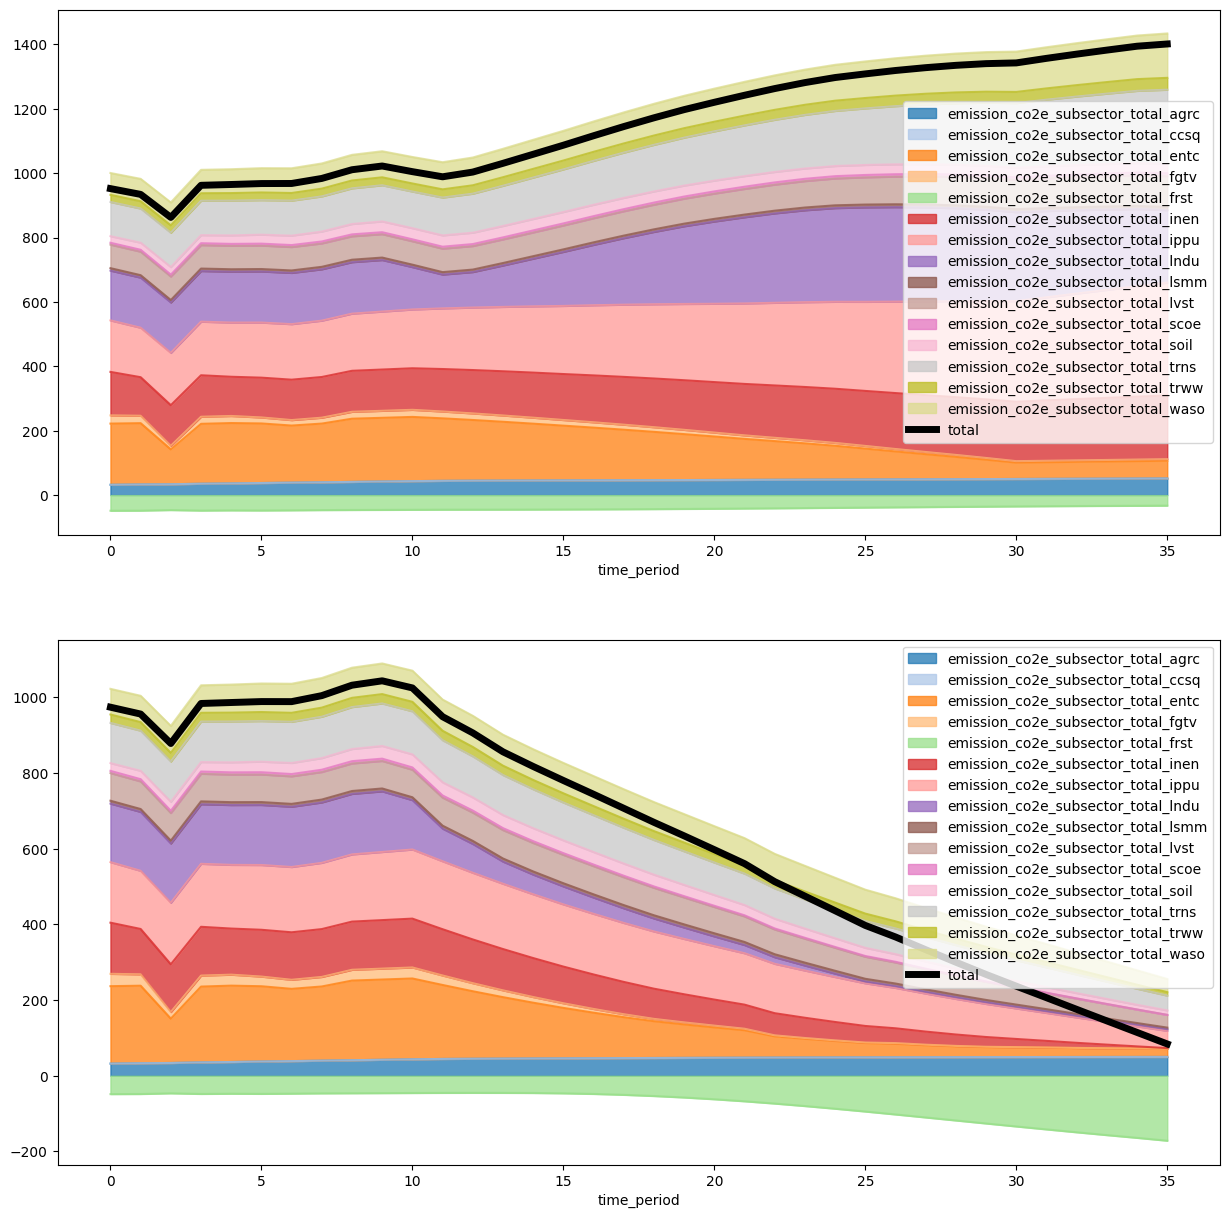

In [18]:
region = "mexico"

# 3008, 3009, 303
strat_id, strat_id_intervention = 1014, 5009
future_id = 0
df_in = sisepuede.experimental_manager.dict_future_trajectories.get(region).generate_future_from_lhs_vector(None, None, future_id, True)
df_out = df_out_all[df_out_all[sisepuede.key_region] == region]
# baseline
dict_filt2 = {}
for k in dict_filt.keys():
    val = dict_filt.get(k) if (k != sisepuede.key_strategy) else [strat_id]
    val = [future_id] if (k == sisepuede.key_future) else val
    dict_filt2.update({k: val[0]})

primary_id = sisepuede.odpt_primary.get_key_value(**dict_filt2)
df_filt = df_out[
    df_out[sisepuede.key_primary].isin([primary_id])
]

# intervention
dict_filt_invervention = {}
for k in dict_filt.keys():
    val = dict_filt.get(k) if (k != sisepuede.key_strategy) else [strat_id_intervention]
    val = [future_id] if (k == sisepuede.key_future) else val
    dict_filt_invervention.update({k: val[0]})
primary_id_intervention = sisepuede.odpt_primary.get_key_value(**dict_filt_invervention)
df_filt_intervention = df_out[
    df_out[sisepuede.key_primary].isin([primary_id_intervention])
]


df_in_filt = df_in[
    df_in[sisepuede.key_strategy].isin([strat_id])
]

df_in_filt_intervention = df_in[
    df_in[sisepuede.key_strategy].isin([strat_id_intervention])
]


fig, ax = plt.subplots(2, 1, figsize = (15, 15))
#ax[0].set_ylim(-150, 350)
#ax[0].set_ylim(0, 900)
#ax[1].set_ylim(0, 900)

palette_func = plt.cm.tab20#plt.cm.hsv

flds = [sisepuede.key_time_period]
if False:
    flds += [
        x for x in df_filt.columns 
        if x.startswith("emission_co2e_subsector_total") 
        and (
            False
            or ("ccsq" in x) 
            or ("entc" in x)
            or ("enfu" in x)
            or ("fgtv" in x)
            or ("inen" in x)
            or ("scoe" in x)
            or ("trns" in x)
        )
    ]
    
if False:
    flds += [
        x for x in df_filt.columns 
        if x.startswith("emission_co2e_subsector_total") 
        and (
            #True
            ("agrc" in x)
            or ("frst" in x)
            or ("lndu" in x)
            or ("lsmm" in x)
            or ("lvst" in x)
            or ("soil" in x)
            #("entc" in x) 
            #or ("scoe" in x)
            #or ("lsmm" in x)
            #or ("soil" in x)
            #or ("frst" in x)
            #or ("lndu" in x)
        )
    ]
    
if False:
    flds = [x for x in flds if "trns" in x]
    
if True:
    flds += [
        x for x in df_filt.columns 
        if x.startswith("emission_co2e_") 
        and (
            True
            #and ("lvst" in x)
            #or ("fgtv" in x)
            #and ("subsector_total" not in x)
            and ("subsector_total" in x)
            and 
            (
                True
                #("lvst" in x)
                #or ("lsmm" in x)
                #or ("soil" in x)
            )
        )
    ]

if False:
    flds += [
        x for x in df_filt.columns 
        if x.startswith("energy_demand_enfu_") 
        and (
            True
            #("entc" in x)
            #or ("fgtv" in x)
            #("inen" in x)
            & ("subsector" in x)
            & ("electricity" in x)
        )
    ]

if False:
    #flds = [x for x in df_filt.columns if x.startswith("energy_demand_enfu") and ("total" in x) and ("subsector" not in x)]# and (("natural_gas" in x) or ("crude" in x) or ("electricity" in x) or ("hydrogen" in x))]
    cat = "rail_passenger"
    pre = "energy_consumption_trns"
    fld_ignore = f"{pre}_{cat}"
    flds = [sisepuede.key_time_period] + [x for x in df_filt.columns if x.startswith(pre) and (cat in x) and (x != fld_ignore)]
    #flds = [x for x in df_filt.columns if x.startswith("passenger_distance")]

add_total = True
plot_from_modvar = False

if True:

    # AFOLU
    # modvar_plot = sisepuede.models.model_afolu.modvar_lndu_area_by_cat
    # modvar_plot = sisepuede.models.model_afolu.modvar_lndu_area_converted_from_type
    # modvar_plot = sisepuede.models.model_afolu.modvar_lndu_area_by_cat
    # modvar_plot = sisepuede.models.model_afolu.modvar_soil_emissions_co2_urea
    modvar_plot = sisepuede.models.model_afolu.modvar_lvst_pop
    modvar_plot = sisepuede.models.model_afolu.modvar_lvst_adjusted_equivalent_exports

    # modvar_plot = sisepuede.models.model_afolu.modvar_frst_emissions_co2_sequestration
    # modvar_plot = sisepuede.models.model_afolu.modvar_lndu_emissions_conv
    # modvar_plot = sisepuede.models.model_afolu.modvar_lvst_emissions_ch4_ef
    # modvar_plot = sisepuede.models.model_afolu.modvar_lsmm_emissions_ch4
    
    
    # ENERGY
    #modvar_plot = sisepuede.models.model_electricity.modvar_entc_nemomod_emissions_co2_mne
    modvar_plot = sisepuede.models.model_electricity.modvar_entc_nemomod_production_by_technology
    #modvar_plot = sisepuede.models.model_energy.modvar_trns_energy_consumption_total
    #modvar_plot = sisepuede.models.model_energy.modvar_trns_passenger_distance_traveled
    #modvar_plot = sisepuede.models.model_energy.modvar_trns_passenger_distance_traveled
    #modvar_plot = sisepuede.models.model_energy.modvar_trde_demand_pkm
    #modvar_plot = sisepuede.models.model_energy.modvar_trns_mass_distance_traveled
    #modvar_plot = sisepuede.models.model_energy.modvar_fgtv_emissions_ch4
    #modvar_plot = sisepuede.models.model_energy.modvar_enfu_exports_fuel_adjusted
    #modvar_plot = sisepuede.models.model_energy.modvar_enfu_energy_demand_by_fuel_total
    #modvar_plot = sisepuede.models.model_energy.modvar_enfu_energy_demand_by_fuel_trns
    #modvar_plot = sisepuede.models.model_electricity.modvar_entc_nemomod_production_by_technology
    #modvar_plot = sisepuede.models.model_energy.modvar_fgtv_emissions_ch4
    #modvar_plot = sisepuede.models.model_energy.modvar_trns_vehicle_distance_traveled_electricity
    
    #IPPU
    #modvar_plot = sisepuede.models.model_ippu.modvar_ippu_qty_total_production
    
    
    
    # NO INTERVENTION
    
    df = sisepuede.model_attributes.get_standard_variables(
        df_filt,
        modvar_plot
    )
    df = pd.concat([df_filt[[sisepuede.key_time_period]].reset_index(drop = True), df], axis = 1)
    df = df[[x for x in df.columns if ("nuclear" not in x) and ("crude" not in x)]]
    df = df_filt[flds] if (not plot_from_modvar) else df
    if len(df) > 0:
        for k in df.columns:
            vec = np.array(df[k])
            bnds = (0, np.inf) if (vec[-1] >= 0) else (-np.inf, 0)
            if (max(vec) > 0) and (min(vec) < 0):
                k0 = f"{k}_positive"
                k1 = f"{k}_negative"
                df[k0] = sf.vec_bounds(np.array(df[k]), (0, np.inf))
                df[k1] = sf.vec_bounds(np.array(df[k]), (-np.inf, 0))
                df.drop([k], axis = 1, inplace = True)
            else:
                df[k] = sf.vec_bounds(np.array(df[k]), bnds)
    
    m, n = df.shape
    colors = [palette_func(x/n) for x in range(n)]
    
    alpha = 1 if not add_total else 0.75
    df.plot.area(x = sisepuede.key_time_period, ax = ax[0], color = colors, alpha = alpha)
    if add_total:
        df["total"] = df.drop([sisepuede.key_time_period], axis = 1).sum(axis = 1)
        df[[sisepuede.key_time_period, "total"]].plot(x = sisepuede.key_time_period, ax = ax[0], color = "black", linewidth = 5)
    df_plot_noint = df.copy()
        
        
    # INTERVENTION
    
    df = sisepuede.model_attributes.get_standard_variables(
        df_filt_intervention,
        modvar_plot
    )
    df = pd.concat([df_filt_intervention[[sisepuede.key_time_period]].reset_index(drop = True), df], axis = 1)
    df = df[[x for x in df.columns if ("nuclear" not in x) and ("crude" not in x)]]
    df = df_filt_intervention[flds] if (not plot_from_modvar) else df
    
    if False:
        # UNCOMMENT TO USE DIFF
        vec = np.array(df[sisepuede.key_time_period])
        flds = [x for x in df.columns if (x != sisepuede.key_time_period)]
        df = pd.DataFrame(np.array(df_filt_intervention[flds]) - np.array(df_filt[flds]), columns = flds)
        df[sisepuede.key_time_period] = vec

    
    
    for k in df.columns:
        vec = np.array(df[k])
        bnds = (0, np.inf) if (vec[-1] >= 0) else (-np.inf, 0)
        if (max(vec) > 0) and (min(vec) < 0):
            k0 = f"{k}_positive"
            k1 = f"{k}_negative"
            df[k0] = sf.vec_bounds(np.array(df[k]), (0, np.inf))
            df[k1] = sf.vec_bounds(np.array(df[k]), (-np.inf, 0))
            df.drop([k], axis = 1, inplace = True)
        else:
            df[k] = sf.vec_bounds(np.array(df[k]), bnds)
    
    m, n = df.shape
    colors = [palette_func(x/n) for x in range(n)]
    
    alpha = 1 if not add_total else 0.75
    df.plot.area(x = sisepuede.key_time_period, ax = ax[1], color = colors, alpha = alpha)
    if add_total:
        df["total"] = df.drop([sisepuede.key_time_period], axis = 1).sum(axis = 1)
        df[[sisepuede.key_time_period, "total"]].plot(x = sisepuede.key_time_period, ax = ax[1], color = "black", linewidth = 5)
    df_plot_int = df.copy()
    #df.plot(ax = ax[1], color = colors)



In [7]:
df_filt[["emission_co2e_subsector_total_entc"]]

,emission_co2e_subsector_total_entc
0,18.704226
1,18.221058
2,5.984976
3,19.540498
4,19.723638
5,20.056282
6,20.823536
7,22.130868
8,23.753421
9,24.486811


In [52]:
(
    df_in_filt[
        [
            x for x in df_in_filt.columns
            if True
            & ("scoe" in x)
            & ("consumpinit_scoe_" in x)
        ]
    ]
    .head()
)

,consumpinit_scoe_gj_per_hh_residential_elec_appliances,consumpinit_scoe_gj_per_hh_residential_heat_energy,consumpinit_scoe_tj_per_mmmgdp_commercial_municipal_elec_appliances,consumpinit_scoe_tj_per_mmmgdp_commercial_municipal_heat_energy,consumpinit_scoe_tj_per_mmmgdp_other_se_elec_appliances,consumpinit_scoe_tj_per_mmmgdp_other_se_heat_energy
504,42.790168,2.252114,791.052446,41.634339,0.0,0.0
505,43.342112,2.281164,790.454777,41.602883,0.0,0.0
506,45.417386,2.390389,817.533887,43.028099,0.0,0.0
507,41.509825,2.184728,737.320994,38.806368,0.0,0.0
508,43.376854,2.282992,759.503863,39.973888,0.0,0.0


In [48]:
(
    df_filt[
        [
            x for x in df_filt.columns
            if True
            & ("household" in x)
        ]
    ]
    .head()
)

,qty_gnrl_households
0,18781464
1,19118133
2,19452362
3,19772281
4,20062912


In [53]:
# residential fuel consumption
x = 18781464*2.252114/1000
x_res_inv = 587205
x_res_inv/x

13.882571931494374

In [55]:
x_res_inv

587205

In [26]:
df_tmp = pd.read_csv("/Users/jsyme/Documents/Projects/git_jbus/sisepuede_launcher/colombia_example.csv")

<AxesSubplot: >

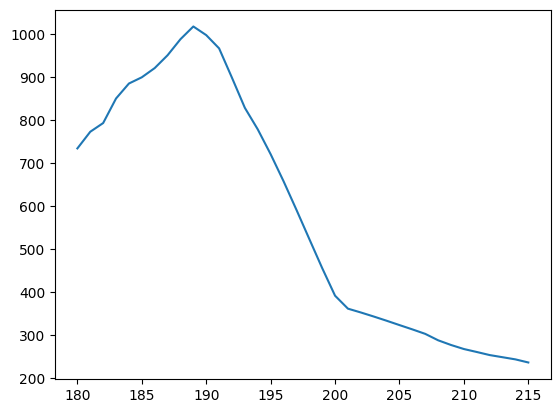

In [36]:
df_tmp[df_tmp["primary_id"].isin([125857])][
    [x for x in df_tmp.columns if x.startswith("emission_co2e_subsector_total")]
].sum(axis = 1).plot()

In [18]:
#df_in_filt[[x for x in df_in_filt.columns if x.startswith("exports_lvst")]]
df_filt[[x for x in df_filt.columns if x.startswith("emission_co2e_subsector")]].tail().sum(axis = 1)

31    3292.424960
32    3349.195064
33    3405.958095
34    3462.737743
35    3497.690592
dtype: float64

In [19]:
#df_filt[[x for x in df_filt.columns if ("emission_co2e" in x) & ("frst" in x)]]

In [20]:
area = 196437500
0.0006*0.38*area

44787.75

In [45]:
df_filt[
    [x for x in df_filt.columns if ("emission_co2e_co2" in x) and ("metal" in x)]
].tail().sum(axis = 1)

2551    174.267899
2552    178.834690
2553    183.280485
2554    187.601053
2555    191.792604
dtype: float64

In [54]:
sa.model_attributes.get_standard_variables(
    df_filt,
    model_afolu.modvar_lndu_area_converted_from_type
).head()

,area_lndu_conversion_from_croplands,area_lndu_conversion_from_forests_mangroves,area_lndu_conversion_from_forests_primary,area_lndu_conversion_from_forests_secondary,area_lndu_conversion_from_grasslands,area_lndu_conversion_from_other,area_lndu_conversion_from_settlements,area_lndu_conversion_from_wetlands
0,34259.528106,1290.749926,1.046884e+06,143.758774,139029.789638,10351.816780,1665.974155,5988.452273
1,34737.660993,1387.556829,1.053775e+06,226.819061,140721.691235,11502.495387,1813.990762,6188.327866
2,35215.960720,1488.422663,1.059969e+06,312.865803,142419.581860,12694.055942,1964.014433,6386.192557
3,35690.757330,1593.393318,1.065468e+06,401.646669,144123.231522,13924.976806,2115.686503,6581.985642
4,36158.226832,1702.510773,1.070278e+06,492.909864,145832.664332,15193.738765,2268.660211,6775.649455


In [50]:
sa.model_attributes.get_standard_variables(
    df_filt_intervention,
    model_afolu.modvar_lndu_area_converted_to_type
).tail()

,area_lndu_conversion_to_croplands,area_lndu_conversion_to_forests_mangroves,area_lndu_conversion_to_forests_primary,area_lndu_conversion_to_forests_secondary,area_lndu_conversion_to_grasslands,area_lndu_conversion_to_other,area_lndu_conversion_to_settlements,area_lndu_conversion_to_wetlands
31,157357.062645,37970.044233,0.0,1.097878e+06,2541.747847,63277.246174,838.109221,0.0
32,153095.345389,37938.279233,0.0,1.040758e+06,2624.657364,47784.764492,474.779753,0.0
33,148612.159926,37884.350339,0.0,9.809019e+05,2711.027314,32351.521687,214.253740,0.0
34,143942.036712,37805.697454,0.0,9.197510e+05,2796.984229,16964.996037,56.339077,0.0
35,142520.597925,37955.452220,0.0,9.058818e+05,2808.063557,16960.071252,56.322722,0.0


In [44]:
df_filt_intervention[
    [x for x in df_filt_intervention.columns if ("emission_co2e_co2" in x) and ("metal" in x)]
].tail().sum(axis = 1)

2731    58.191944
2732    56.074297
2733    53.874267
2734    51.603679
2735    49.274082
dtype: float64

In [41]:
df_filt[
    [x for x in df_filt.columns if ("emission_co2e" in x) and ("metal" in x)]
].sum(axis = 1)

2520     66.733555
2521     62.952373
2522     64.726351
2523     68.608067
2524     70.595169
2525     72.326768
2526     74.194818
2527     76.067225
2528     77.930395
2529     79.782779
2530     81.622862
2531     85.791599
2532     89.976830
2533     94.171132
2534     98.367276
2535    102.558248
2536    107.067163
2537    111.561497
2538    116.033872
2539    120.477204
2540    124.884707
2541    129.532077
2542    134.131095
2543    138.675092
2544    143.157754
2545    147.573127
2546    152.303259
2547    156.951171
2548    161.511015
2549    165.977362
2550    170.345187
2551    175.049285
2552    179.636553
2553    184.102282
2554    188.442222
2555    192.652568
dtype: float64